## Import libraries

In [19]:
import glob
from tqdm import tqdm
import datetime
import re
import pandas as pd
import seaborn as sns
import warnings
import os
import pickle
import numpy as np
import utils as ut
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import PA_Utils as pa_ut
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from matplotlib.lines import Line2D

warnings.simplefilter(action='ignore', category=FutureWarning)

In [20]:
# !pip install statsmodels

## Functions

In [21]:
def compute_p_stay(sub_df):
    # calculate p_stay independent of reward
    p_stay = (sub_df['choice'] == sub_df['choice_1']).mean()
    
    # Given reward
    reward_df = sub_df[sub_df['correct_1'] == 1]
    p_stay_given_reward = (reward_df['choice'] == reward_df['choice_1']).mean()

    # No reward
    no_reward_df = sub_df[sub_df['correct_1'] == 0]
    p_stay_given_no_reward = (no_reward_df['choice'] == no_reward_df['choice_1']).mean()

    return p_stay, p_stay_given_reward, p_stay_given_no_reward

def compute_p_switch(sub_df):
    # calculate p_switch independent of reward
    p_switch = (sub_df['choice'] != sub_df['choice_1']).mean()
    
    # Given reward
    reward_df = sub_df[sub_df['correct_1'] == 1]
    p_switch_given_reward = (reward_df['choice'] != reward_df['choice_1']).mean()

    # No reward
    no_reward_df = sub_df[sub_df['correct_1'] == 0]
    p_switch_given_no_reward = (no_reward_df['choice'] != no_reward_df['choice_1']).mean()

    return p_switch, p_switch_given_reward, p_switch_given_no_reward

def add_previous_n_trials_data(group, n=7):
    """
    Add previous n trial data (stim_relative_binned, choice, and correct) to the DataFrame for each participant.
    
    Parameters
    ----------
    group : pd.DataFrame
        The data for a single participant, assumed to have the columns 'Trial', 'No_response',
        'stim_relative_binned', 'choice', and 'correct'.
    n : int
        Number of previous trials to include.
        
    Returns
    -------
    group : pd.DataFrame
        The modified input DataFrame with additional columns for previous trial data
        ('stim_relative_1', 'choice_1', 'correct_1', ... up to n).
    """
    for i in range(1, n+1):
        # Shift the stim_relative_binned, choice, and correct columns by i rows to get previous trial data
        group[f'stim_relative_binned_{i}'] = group['stim_relative_binned'].shift(i)
        group[f'stim_relative_{i}'] = group['Stim_Relative'].shift(i)
        group[f'choice_{i}'] = group['choice'].shift(i)
        group[f'correct_{i}'] = group['correct'].shift(i)
        
        # Set the new columns to NaN for the first i trials of each participant
        group.loc[group['Trial'] < i, [f'stim_relative_{i}', f'choice_{i}', f'correct_{i}']] = np.nan
        
        # Set choice_i and correct_i to NaN for trials where the previous trial had no response
        group.loc[group['No_response'].shift(i) == True, [f'choice_{i}', f'correct_{i}']] = np.nan

    return group

def compute_p_switch_given_n_repeats_and_m_rewards(sub_df, n, m):
    '''
    Compute the probability of switching choice given n successive same actions and m rewards in the last n trials
    Args:
        sub_df (pd.DataFrame): The dataframe containing the relevant columns
        n (int): The number of successive same actions
        m (int): The number of rewards in the last n trials
    Returns:
        p_switch (float): The probability of switching choice given n successive same actions and m rewards in the last n trials
    '''
    # Check for n successive same actions and m rewards in the last n trials
    same_action_conditions = [(sub_df['choice_1'] == sub_df[f'choice_{i}']) for i in range(2, n+1)]
    n_successive_actions = np.all(same_action_conditions, axis=0)
    m_rewards = (sub_df[[f'correct_{i}' for i in range(1, n+1)]].sum(axis=1) == m)
    
    # Filter the dataframe based on these conditions
    sequence_df = sub_df[n_successive_actions & m_rewards]

    # If there are no sequences matching the criteria, return nan
    if len(sequence_df) == 0:
        return np.nan
    
    # Calculate the probability of switch given n successive same actions and m rewards
    p_switch = (sequence_df['choice'] != sequence_df['choice_1']).mean()

    return p_switch

def plot_perf_and_bias(df, Animal_List, save_path=None):
    """
    Creates and displays a plot showing performance and bias for each participant.
    
    :param df: The input dataframe
    :param Animal_List: The list of participant IDs to plot
    :param save_path: The file path to save the resulting plot, if None, plot is not saved
    """
    # Define the number of rows and columns for subplots
    n_rows = 3  # Number of rows
    n_cols = 5  # Number of columns
    filtered_df = df[df.No_response == False]

    # Create subplots with specified number of rows and columns
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 8 * n_rows))
    
    for i, participant_id in enumerate(Animal_List):
        participant_df = filtered_df[filtered_df.Participant_ID == participant_id]
        ax1 = axs.flatten()[i]
        sns.pointplot(data=participant_df, x='Date', y='correct', errorbar=('ci', 95), 
                      ax=ax1, scale=0.5, errwidth=1.5, color='k')
        
        ax1.set_title(f"Participant ID: {participant_id}", fontdict={'fontsize': 12})
        ax1.set_ylim(0, 1)
        # plot bias on a secondary y-axis
        ax2 = ax1.twinx()
        sns.pointplot(data=participant_df, x='Date', y='Choice_Rule_Diff', errorbar=('ci', 95), 
                      ax=ax2, scale=0.5, errwidth=1.5, color='r')
        ax2.set_ylim(-1, 1)
        # change label and tick color
        ax2.tick_params(axis='y', colors='r')
        ax2.set_ylabel('Bias', color='r', rotation=270, labelpad=15)
        # horizontal line at 0.5
        ax1.axhline(y=0.5, color='k', linestyle='--', label='Chance')
        ax1.set_ylabel('Proportion Correct', color='k')
        ax1.set_xlabel('Date', color='k')
        # rotate x-axis labels
        for tick in ax1.get_xticklabels():
            tick.set_rotation(45)
        # only show every 5th x-axis label
        for i, label in enumerate(ax1.xaxis.get_ticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

    # remove empty subplots
    for i in range(len(Animal_List), n_rows * n_cols):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_p_stay(df, Animal_List, save_path = None):
    """
    Creates and displays a plot showing P(Stay), P(Stay/R), and P(Stay/¬R) for each participant.
    
    :param df: The input dataframe
    :param Animal_List: The list of participant IDs to plot
    :param compute_p_stay: The function to compute P(Stay), P(Stay/R), and P(Stay/¬R)
    :param title: The title of the plot, which will be used in the saved filename if save_path is provided
    :param save_dir: The directory to save the resulting plot, if None, plot is not saved
    """
    # Define the number of rows and columns for subplots
    n_rows = 3  # Number of rows
    n_cols = 5  # Number of columns

    # Create subplots with specified number of rows and columns
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 8 * n_rows))

    # Flatten the axs array for easy iteration
    axs = axs.ravel()
    line_colors = {'P(Stay)': 'blue', 'P(Stay/R)': 'magenta', 'P(Stay/¬R)': 'green'}

    for idx, participant in enumerate(Animal_List):
        participant_df = df[df['Participant_ID'] == participant]
        dates = participant_df['Date'].unique()

        # p_stay = []
        p_reward = []
        p_no_reward = []

        for date in dates:
            date_df = participant_df[participant_df['Date'] == date]
            p, p_r, p_nr = compute_p_stay(date_df)
            # p_stay.append(p)
            p_reward.append(p_r)
            p_no_reward.append(p_nr)

        # Plot lines with specified colors from the dictionary
        # axs[idx].plot(dates, p_stay, '-o', label='P(Stay)', color=line_colors['P(Stay)'])
        axs[idx].plot(dates, p_reward, '-o', label='P(Stay/R)', color=line_colors['P(Stay/R)'])
        axs[idx].plot(dates, p_no_reward, '-x', label='P(Stay/¬R)', color=line_colors['P(Stay/¬R)'])
        axs[idx].set_ylim(0, 1)
        axs[idx].axhline(y=0.5, color='k', linestyle='--', label='Chance')
        axs[idx].set_xlabel('Date')
        axs[idx].set_ylabel('Probability')
        axs[idx].set_title(f'Participant {participant}', fontdict={'fontsize': 12})
        axs[idx].legend()
        # rotate the xticks
        axs[idx].tick_params(axis='x', rotation=45)
        # only show every 5th xtick
        for i, label in enumerate(axs[idx].get_xticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

    # Hide any remaining unused subplots
    for j in range(idx + 1, n_rows * n_cols):
        axs[j].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()

def plot_psycho_individual(df, Animal_List, save_path=None):
    """
    Plots the psychometric curves for each participant.

    :param df: DataFrame containing the data
    :param Animal_List: List of participant IDs
    :param psycho_fit: Function to fit the psychometric curve, must return a tuple where the first element is the fit parameters
    :param psycho_plot: Function to plot the psychometric curve
    :param save_dir: Directory to save the plot, if None the plot is not saved
    """
    cols = 5
    rows = 2
    fig, axes = plt.subplots(rows, cols, figsize=(cols*8, rows*8))
    axes = axes.ravel()  # Flatten axes for easier indexing
    for i, p_id in enumerate(Animal_List):
        participant_df = df[df['Participant_ID'] == p_id]
        popt = ut.psycho_fit(participant_df)[0]
        ut.psycho_plot(participant_df, popt, label=None, color='k', ax=axes[i], legend=False)        
        axes[i].set_title('Psychometric for ' + p_id, fontdict={'fontsize': 30})
    # remove empty subplots
    for i in range(len(Animal_List), rows * cols):
        fig.delaxes(axes[i])
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def filter_min_rows(df, threshold = 100, iterator = 'Participant_ID', feature = 'block'):
    '''
    For every unique value in the iterator column, remove every 'block' which has less than threshold rows
    Args:
        df (pd.DataFrame): The dataframe to filter
        threshold (int): The minimum number of rows per block
        iterator (str): The column to iterate over
        feature (str): The column to count rows for
    Returns:
        df (pd.DataFrame): The filtered dataframe
    '''
    new_df = pd.DataFrame()
    for pid in df[iterator].unique():
        pid_df = df[df[iterator] == pid]
        new_df = pd.concat([new_df, pid_df.groupby(feature).filter(lambda x: len(x) >= threshold).reset_index(drop=True)])
    return new_df

## Fetch Data

In [1]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'SOUND_CAT'
data_type = 'Trial_Summary'

Animal_List = [
    'QP093', 
    'QP094', 
    # 'QP096', 
    'QP097', 
    'QP098', 'QP099', 
               'QP0100', 'QP0101', 'QP0103',
               'QP0109', 
            #    'QP0110',
               ] 

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_SC.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_SC = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_SC = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = pa_ut.get_animal_data(data_path,
                                             animal, 
                                             protocol,
                                             data_type)
            all_data_SC = pd.concat([all_data_SC, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_SC, f)

NameError: name 'os' is not defined

## Process


In [23]:
# Processing the data
# Step 1: Data Preparation
df = all_data_SC.copy()
df['Datetime'] = pd.to_datetime(df['Date'])
df['Animal_ID'] = pd.Categorical(df['Animal_ID'], categories=Animal_List, ordered=True)

# Step 2: Adding Block Column
# Assuming add_block_column function adds a 'block' column to the dataframe
df = pa_ut.add_block_column(df, participant_col='Animal_ID', datetime_col='Datetime', 
                             trial_end_time='Trial_End_Time', trial_col='Trial_Number')

# Step 3: Outcome and Choice Columns
# Using assign() for cleaner syntax and potential performance improvement
df = df.assign(
    Correct=lambda x: (x['Trial_Outcome'] == 'Correct').astype(int),
    Incorrect=lambda x: (x['Trial_Outcome'] == 'Incorrect').astype(int),
    No_Response=lambda x: (x['Trial_Outcome'] == 'Abort').astype(int),
    choice=lambda x: (x['First_Lick'] == 'Right').astype(int),
    block=lambda x: x['block'] - 1,
    Trial_Number=lambda x: x['Trial_Number'] - 1
)

# Renaming columns
df.rename(columns={
    'Animal_ID': 'Participant_ID', 
    'Trial_Number': 'Trial',
    'Correct': 'correct',
    'Abort_Trial': 'No_response'
}, inplace=True)

# Step 4: Adjustments and Rule Calculations
df['Rule_Right'] = (df['Stim_Relative'] > 0).astype(int)
df['Choice_Rule_Diff'] = df['choice'] - df['Rule_Right']

# Step 5: Handling No Response Trials
# Using loc for in-place modification
no_response_mask = df['No_response'] == 1
df.loc[no_response_mask, ['correct', 'choice', 'Response_Latency', 'Choice_Rule_Diff']] = np.nan

# Step 6: Binning Stim_Relative Values
# Define bins and labels outside the main logic for clarity
bins = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
labels = [-0.875, -0.625, -0.375, -0.125, 0.125, 0.375, 0.625, 0.875]

# Using cut() directly, as it can handle both negative and positive values with different inclusivity
df['stim_relative_binned'] = pd.cut(
    df['Stim_Relative'], bins=bins, labels=labels, right=False, include_lowest=True
).astype(float)

# Step 7: Re-indexing
df.reset_index(drop=True, inplace=True)

In [24]:
# old code (just in case)
# df = all_data_SC
# df['Datetime'] = pd.to_datetime(df['Date'])
# df['Animal_ID'] = pd.Categorical(df['Animal_ID'], categories=Animal_List, ordered=True)
# df = pa_ut.add_block_column(df, participant_col = 'Animal_ID', datetime_col = 'Datetime', trial_end_time =  'Trial_End_Time', trial_col =  'Trial_Number')

# df['Correct'] = np.where(df['Trial_Outcome']=='Correct', 1, 0)
# df['Incorrect'] = np.where(df['Trial_Outcome']=='Incorrect', 1, 0)
# df['No_Response'] = np.where(df['Trial_Outcome']=='Abort', 1, 0)
# df['choice'] = np.where(df['First_Lick']=='Right', 1, 0) # choice is 2 for right lick, 1 for left lick

# df['block'] = df['block'].apply(lambda x: x - 1) # apply 0 indexing to block
# df['Trial_Number'] = df['Trial_Number'].apply(lambda x: x - 1) # apply 0 indexing to TrialNumber
# df = df.rename(columns={'Animal_ID': 'Participant_ID', 'Trial_Number': 'Trial', 
#                         'Correct': 'correct', 'Abort_Trial': 'No_response'})
# df['Rule_Right'] = np.where(df['Stim_Relative']>0, 1, 0)
# df['Choice_Rule_Diff'] = df['choice'] - df['Rule_Right']
# # label relevant rows as np.nan for no_response trials
# df.loc[df['No_response'] == True, 'correct'] = np.nan
# df.loc[df['No_response'] == True, 'choice'] = np.nan
# df.loc[df['No_response'] == True, 'Response_Latency'] = np.nan
# df.loc[df['No_response'] == True, 'Choice_Rule_Diff'] = np.nan
# # Define the bins
# bins_negative = [-1.0, -0.75, -0.5, -0.25, 0.0]
# bins_positive = [0.0, 0.25, 0.5, 0.75, 1.0]

# # Create masks for negative and positive values
# mask_negative = df['Stim_Relative'] < 0
# mask_positive = df['Stim_Relative'] > 0

# # Bin the negative values with left inclusivity
# binned_negative = pd.cut(df[mask_negative]['Stim_Relative'], bins=bins_negative, right=False, labels = np.arange(-0.875, 0, 0.25))

# # Bin the positive values with right inclusivity
# binned_positive = pd.cut(df[mask_positive]['Stim_Relative'], bins=bins_positive, right=True, labels = np.arange(0.125, 1, 0.25))

# # Convert the binned categories to strings
# binned_negative = binned_negative.astype(str)
# binned_positive = binned_positive.astype(str)

# # Assign binned values using masks
# df.loc[mask_negative, 'stim_relative_binned'] = binned_negative
# df.loc[mask_positive, 'stim_relative_binned'] = binned_positive
# # df['stim_relative_binned'] = df['stim_relative_binned'].astype('category')
# df['stim_relative_binned'] = pd.to_numeric(df['stim_relative_binned'], errors='coerce')
# # re-index the dataframe
# df = df.reset_index(drop=True)

## Set plot fonts

In [25]:
ut.set_plot_font(font_family='sans-serif', title_font_size=14, label_font_size=14, sans_serif_font='Helvetica')

## Break execution

In [26]:
# Break execution at this cell 
# raise KeyboardInterrupt("Stopped execution at this cell.")

## Performance and Bias

ValueError: min() arg is an empty sequence

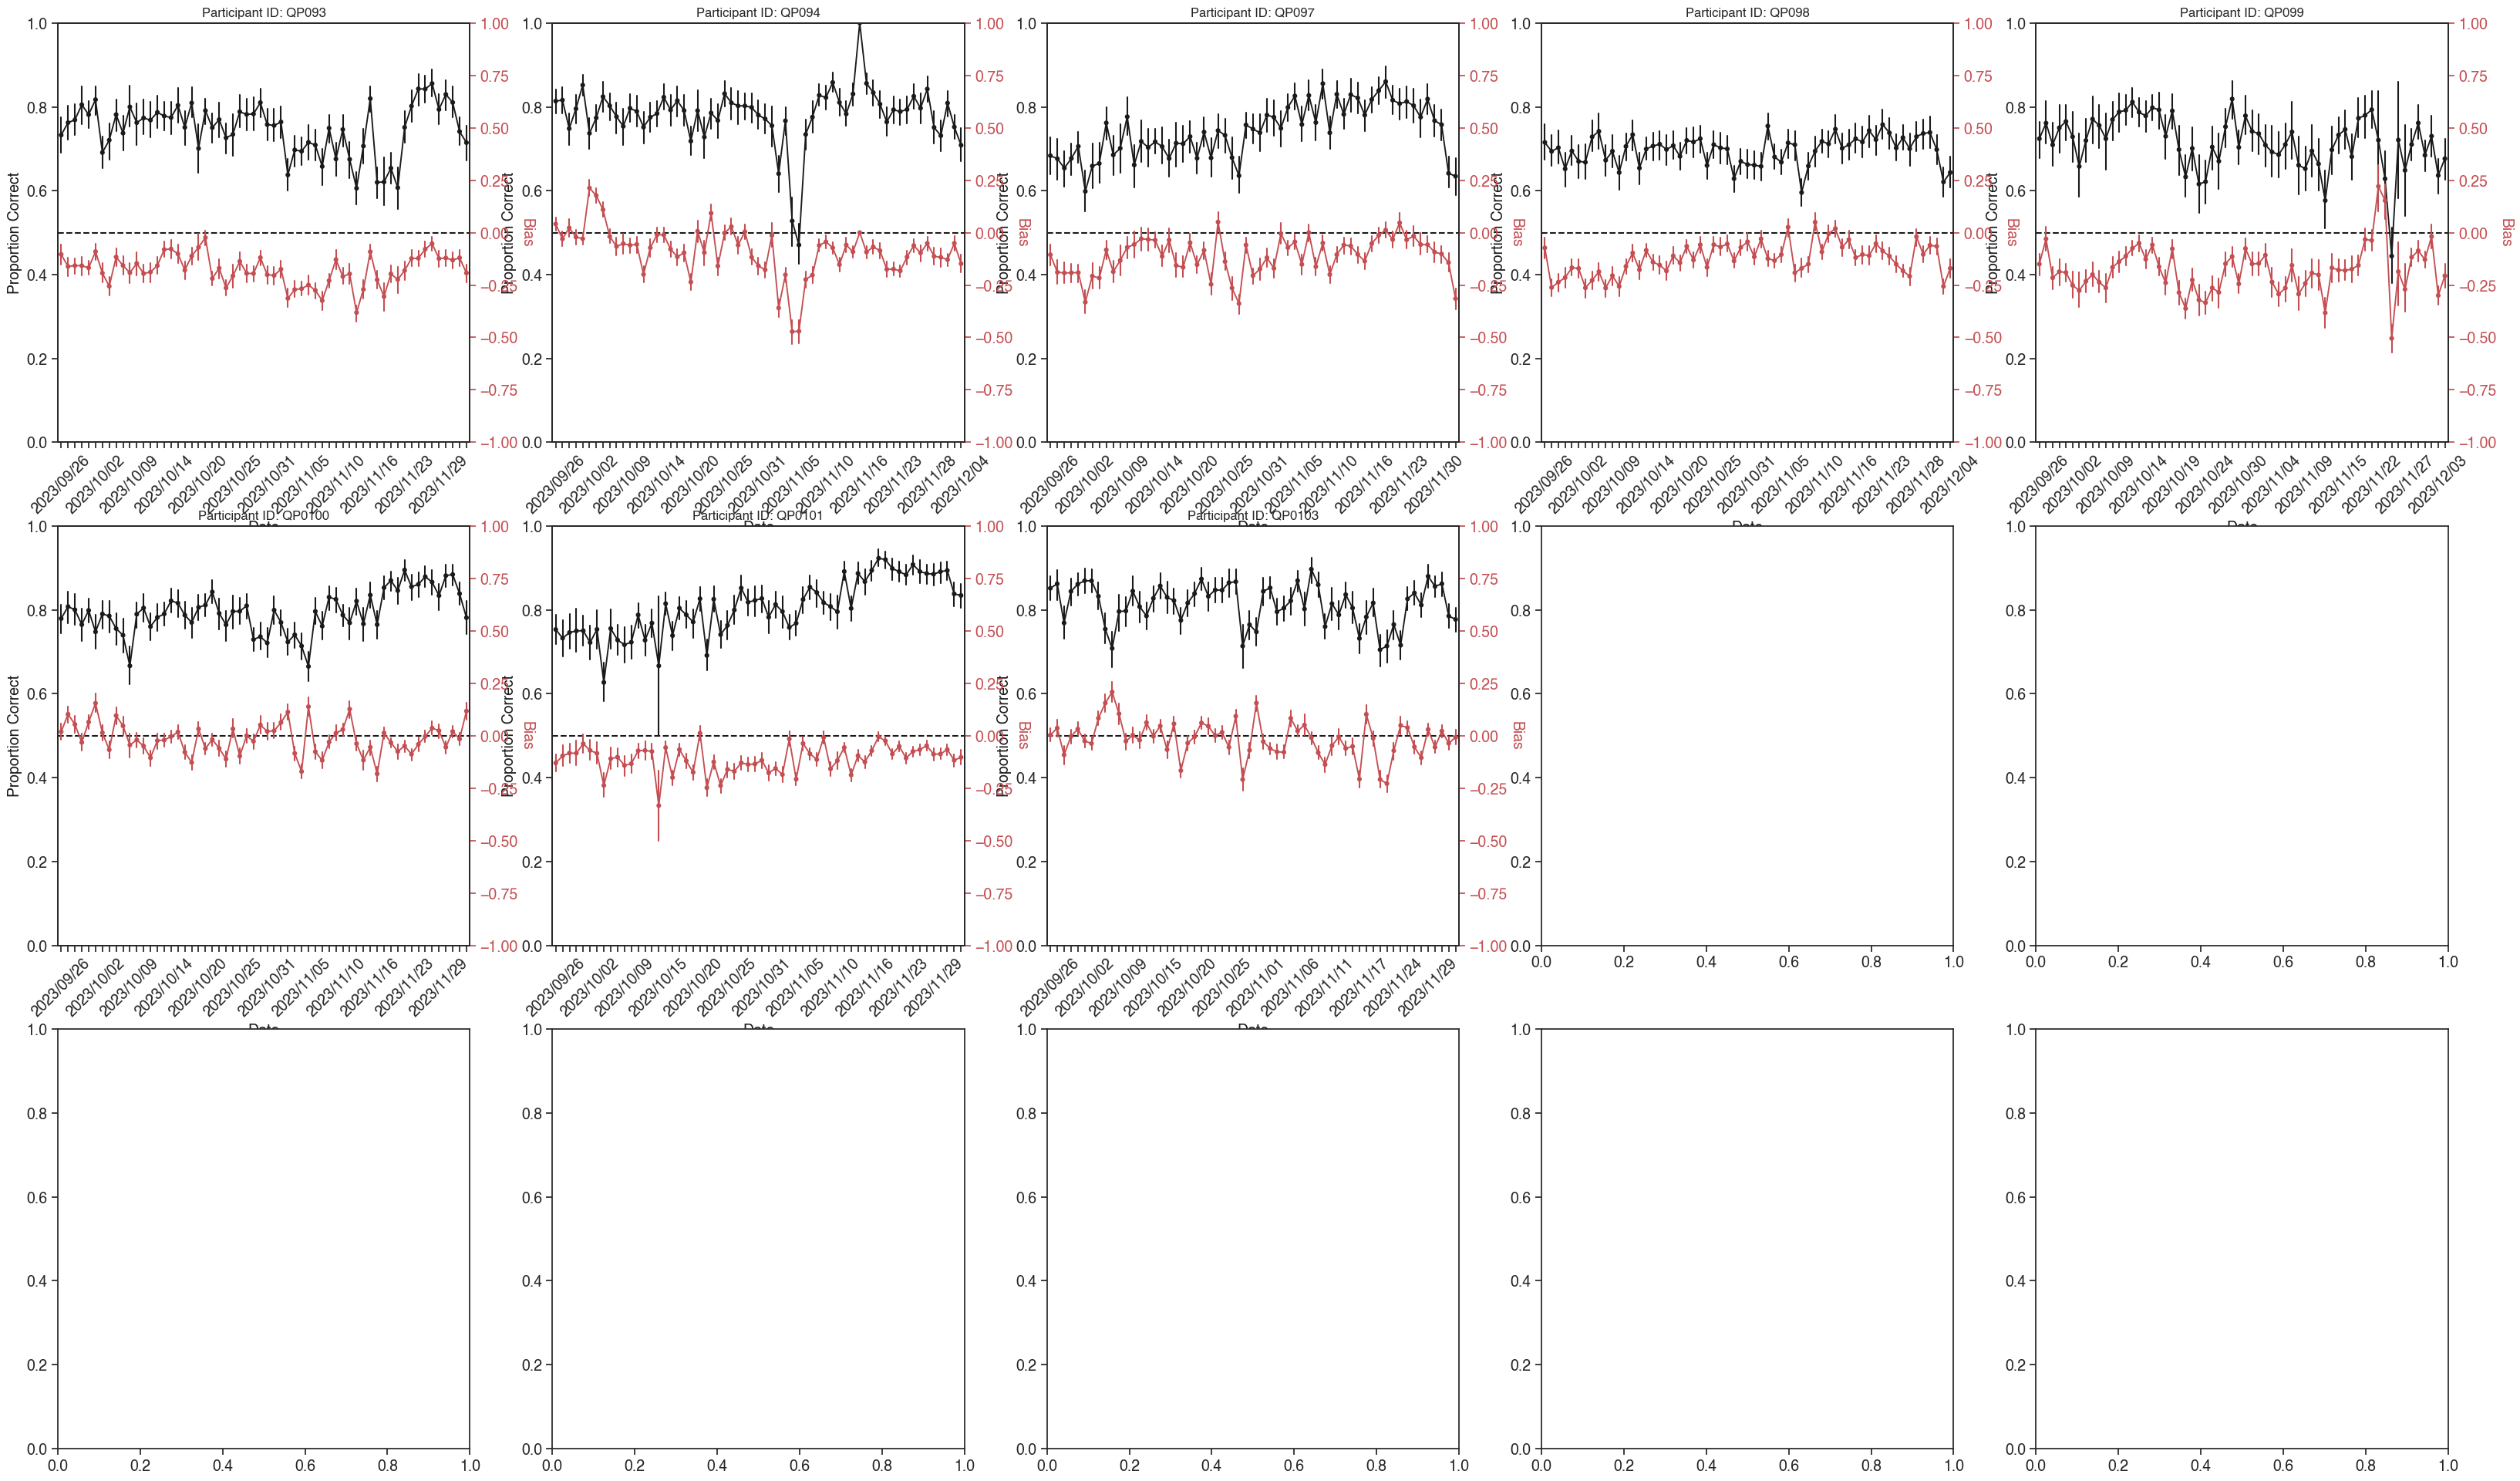

In [27]:
plot_perf_and_bias(df, Animal_List, save_path= figs_path + 'ACC_PPC_Performance_And_Bias.pdf')

## Choice scatter plots

KeyboardInterrupt: 

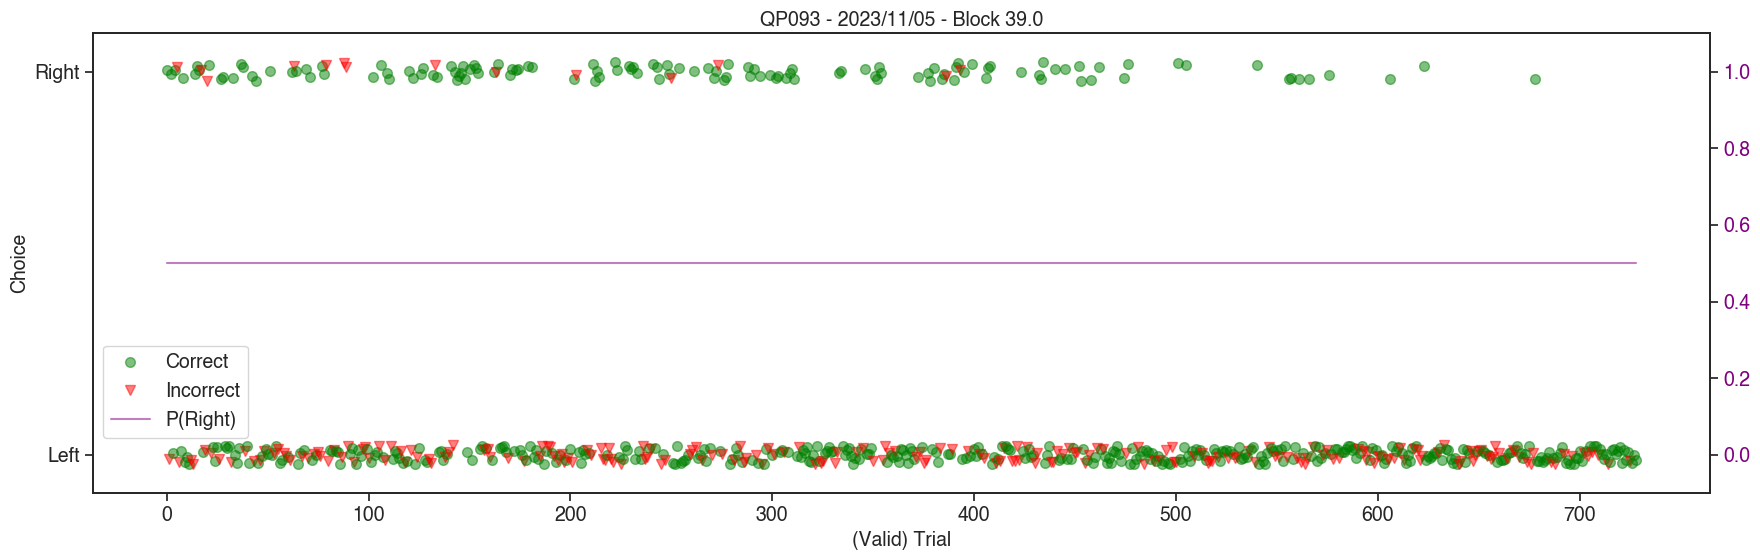

In [ ]:
for p_id in Animal_List:
    ut.plot_choice_scatter_V2(df = df, p_id= p_id, save_path = figs_path + p_id + '_Choice_Scatter.pdf', show_plot=False,
                              plot_P_Right= True, jitter= 0.025)

## P(Stay/R) and P(Stay/¬R)

In [28]:
# apply the add_previous_trial_data to each group
# df = df.groupby('Participant_ID', group_keys=False).apply(ut.add_previous_trial_data)
df = df.groupby('Participant_ID').apply(add_previous_n_trials_data)
df = df.groupby('Participant_ID', group_keys= False).apply(add_previous_n_trials_data)

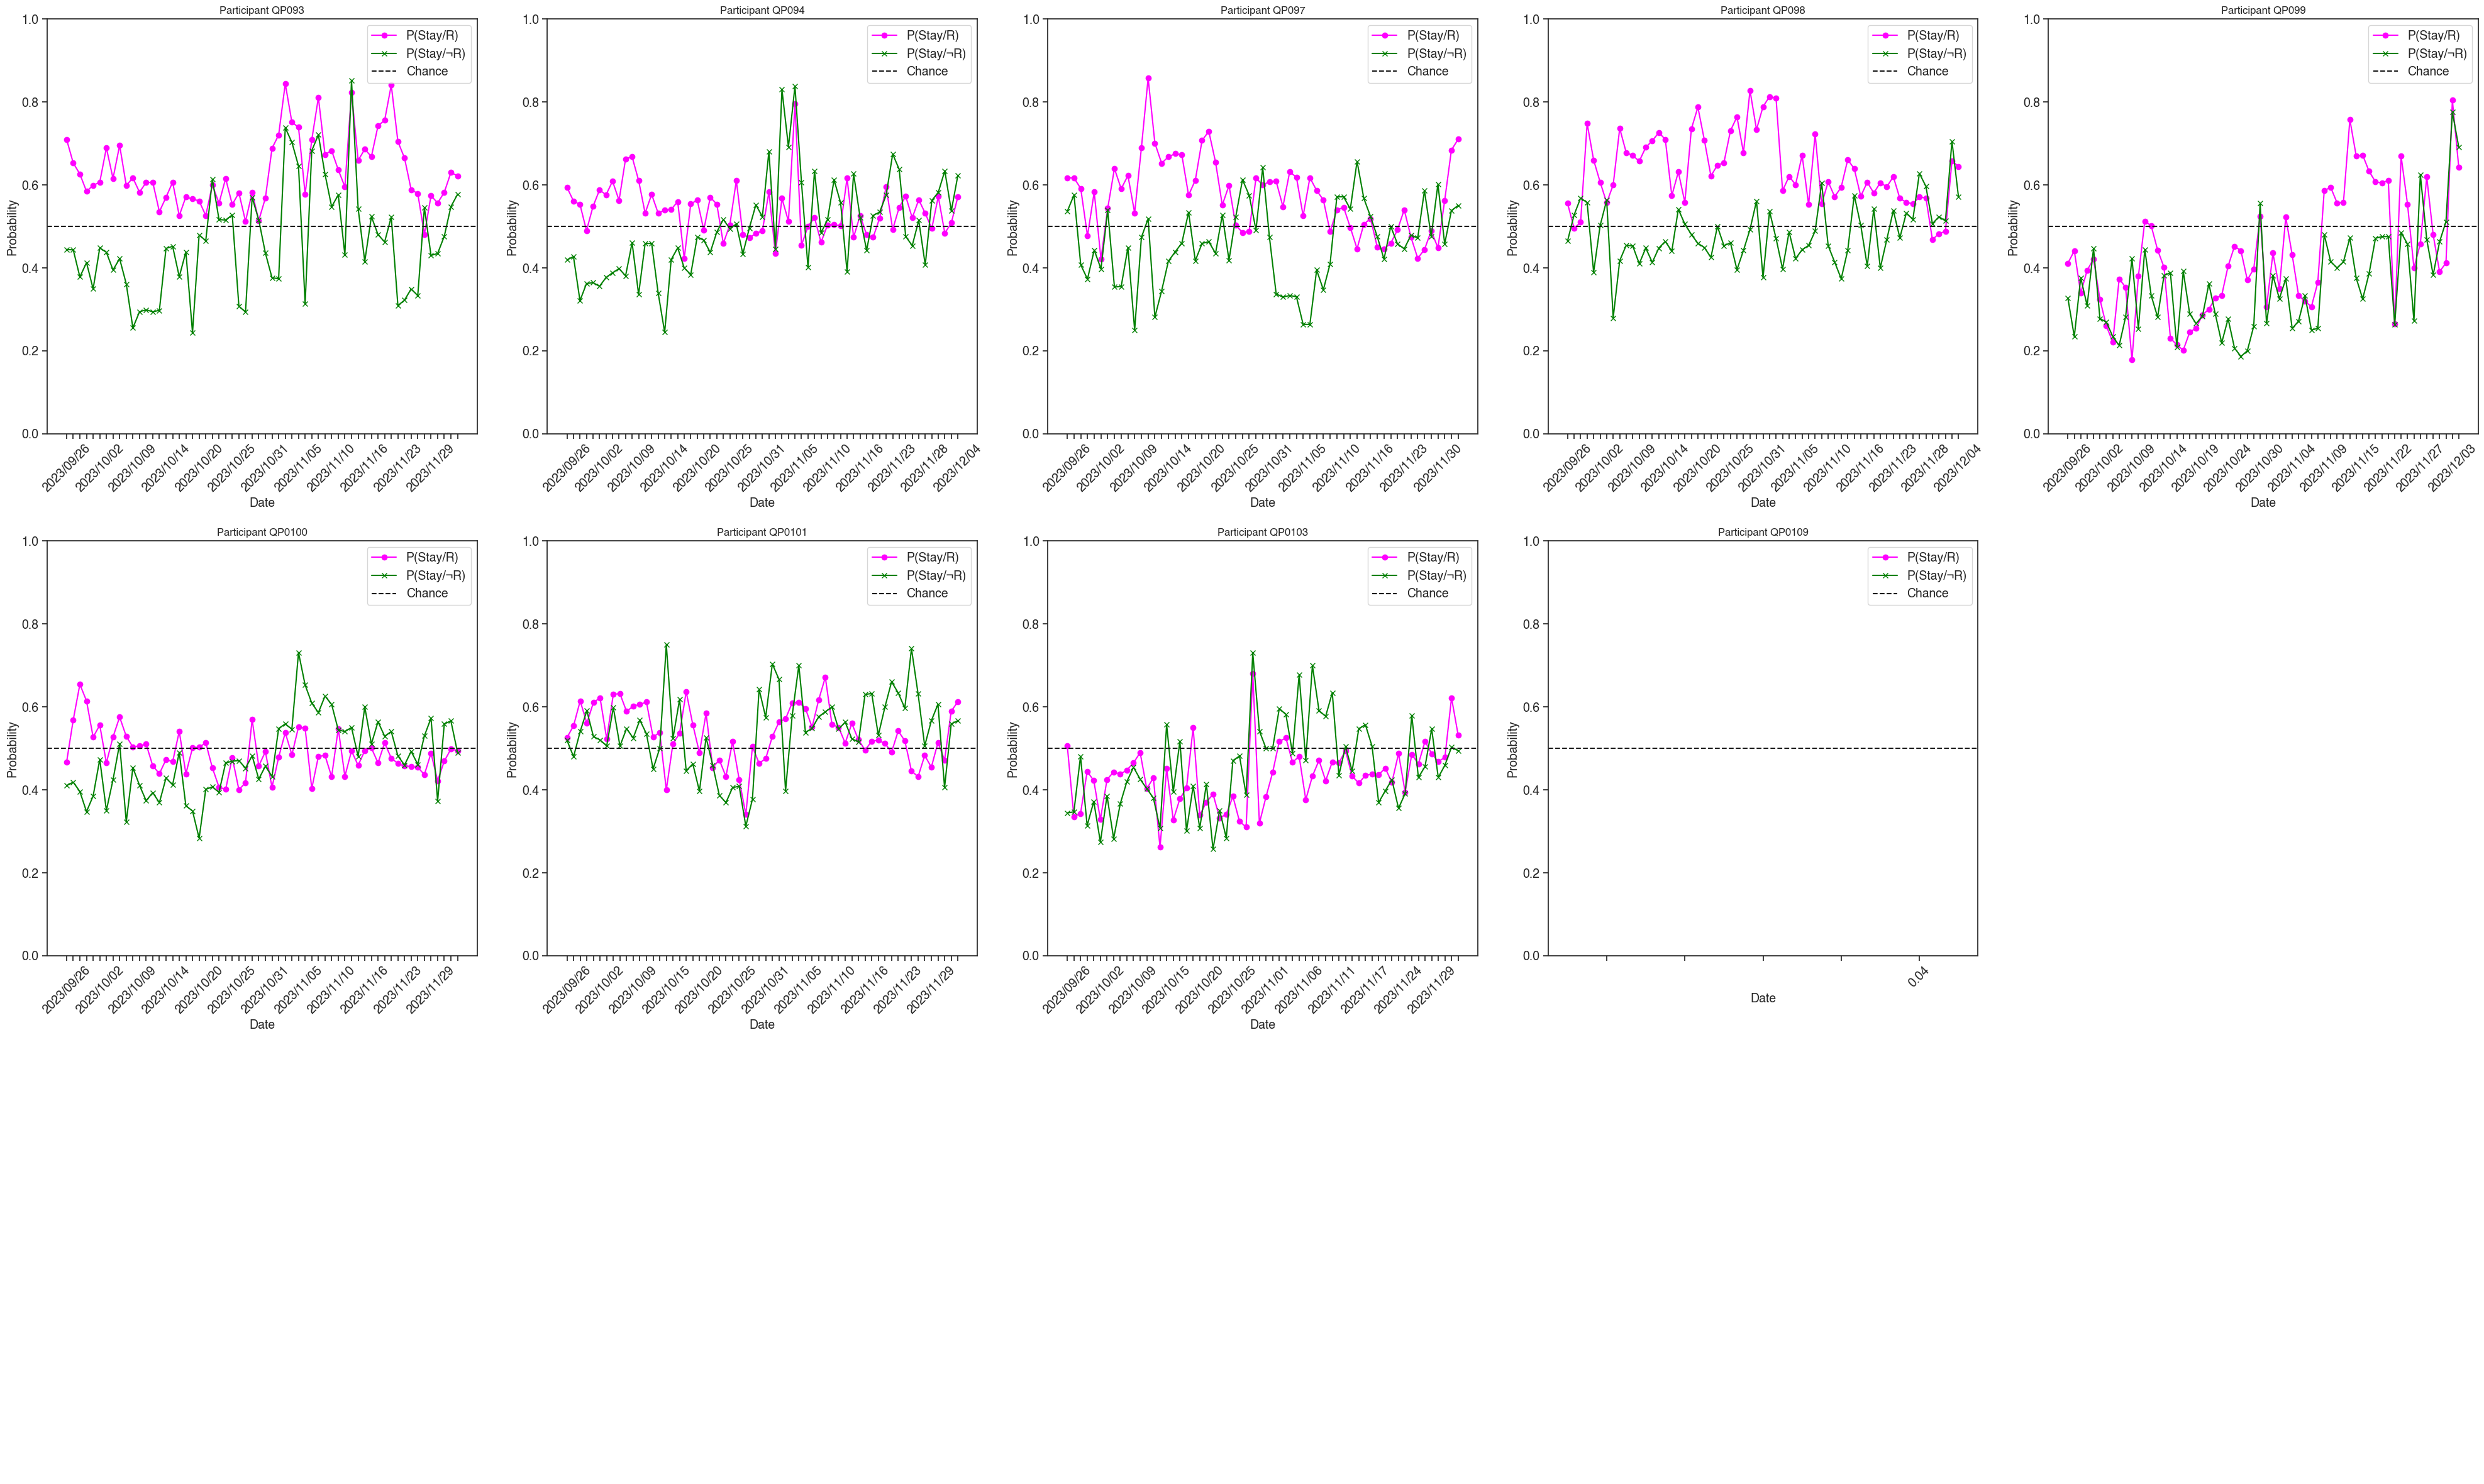

In [29]:
plot_p_stay(df, Animal_List, save_path= figs_path + 'ACC_PPC_PStay.pdf')

In [ ]:
# Break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

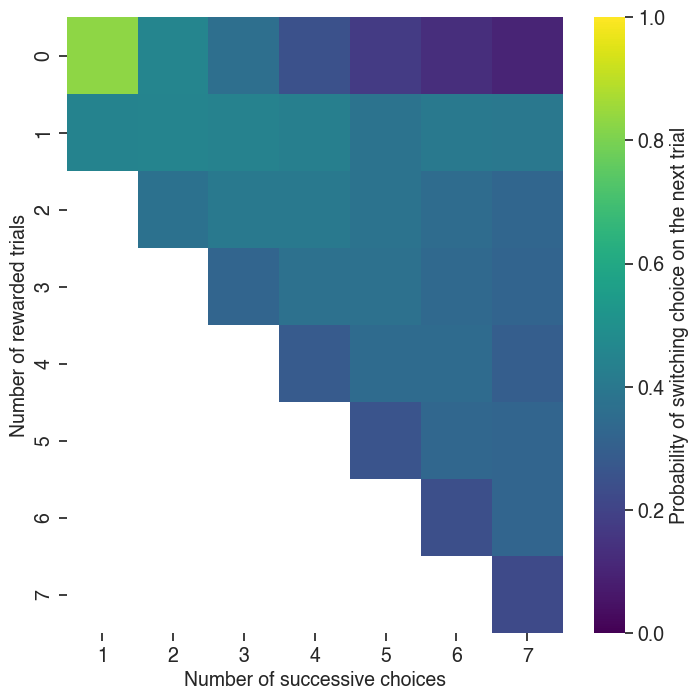

In [ ]:
# df = df.groupby('Participant_ID').apply(add_previous_n_trials_data)
columns_to_keep = ['choice', 'choice_1', 'choice_2', 'choice_3', 'choice_4', 'choice_5', 'choice_6', 'choice_7',
                   'correct', 'correct_1', 'correct_2', 'correct_3', 'correct_4', 'correct_5', 'correct_6', 'correct_7']

sub_df = df[columns_to_keep]

matrix = np.empty((8, 7))
matrix[:] = np.nan

for col in range(1, 8):
    for row in range(8):
        matrix[row, col-1] = compute_p_switch_given_n_repeats_and_m_rewards(sub_df, col, row)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(matrix, annot=False, cmap="viridis", vmin=0, vmax=1, 
            cbar_kws={'label': 'Probability of switching choice on the next trial'})
# xlabel i
plt.xlabel('Number of successive choices')
# ylabel 
plt.ylabel('Number of rewarded trials')
# relabel the xticks for 1 indexing
plt.xticks(np.arange(7) + 0.5, np.arange(1, 8))
# title
plt.show()

## Psychometrics

In [ ]:
sub_df = df[df['Date'] == '2023/11/24']

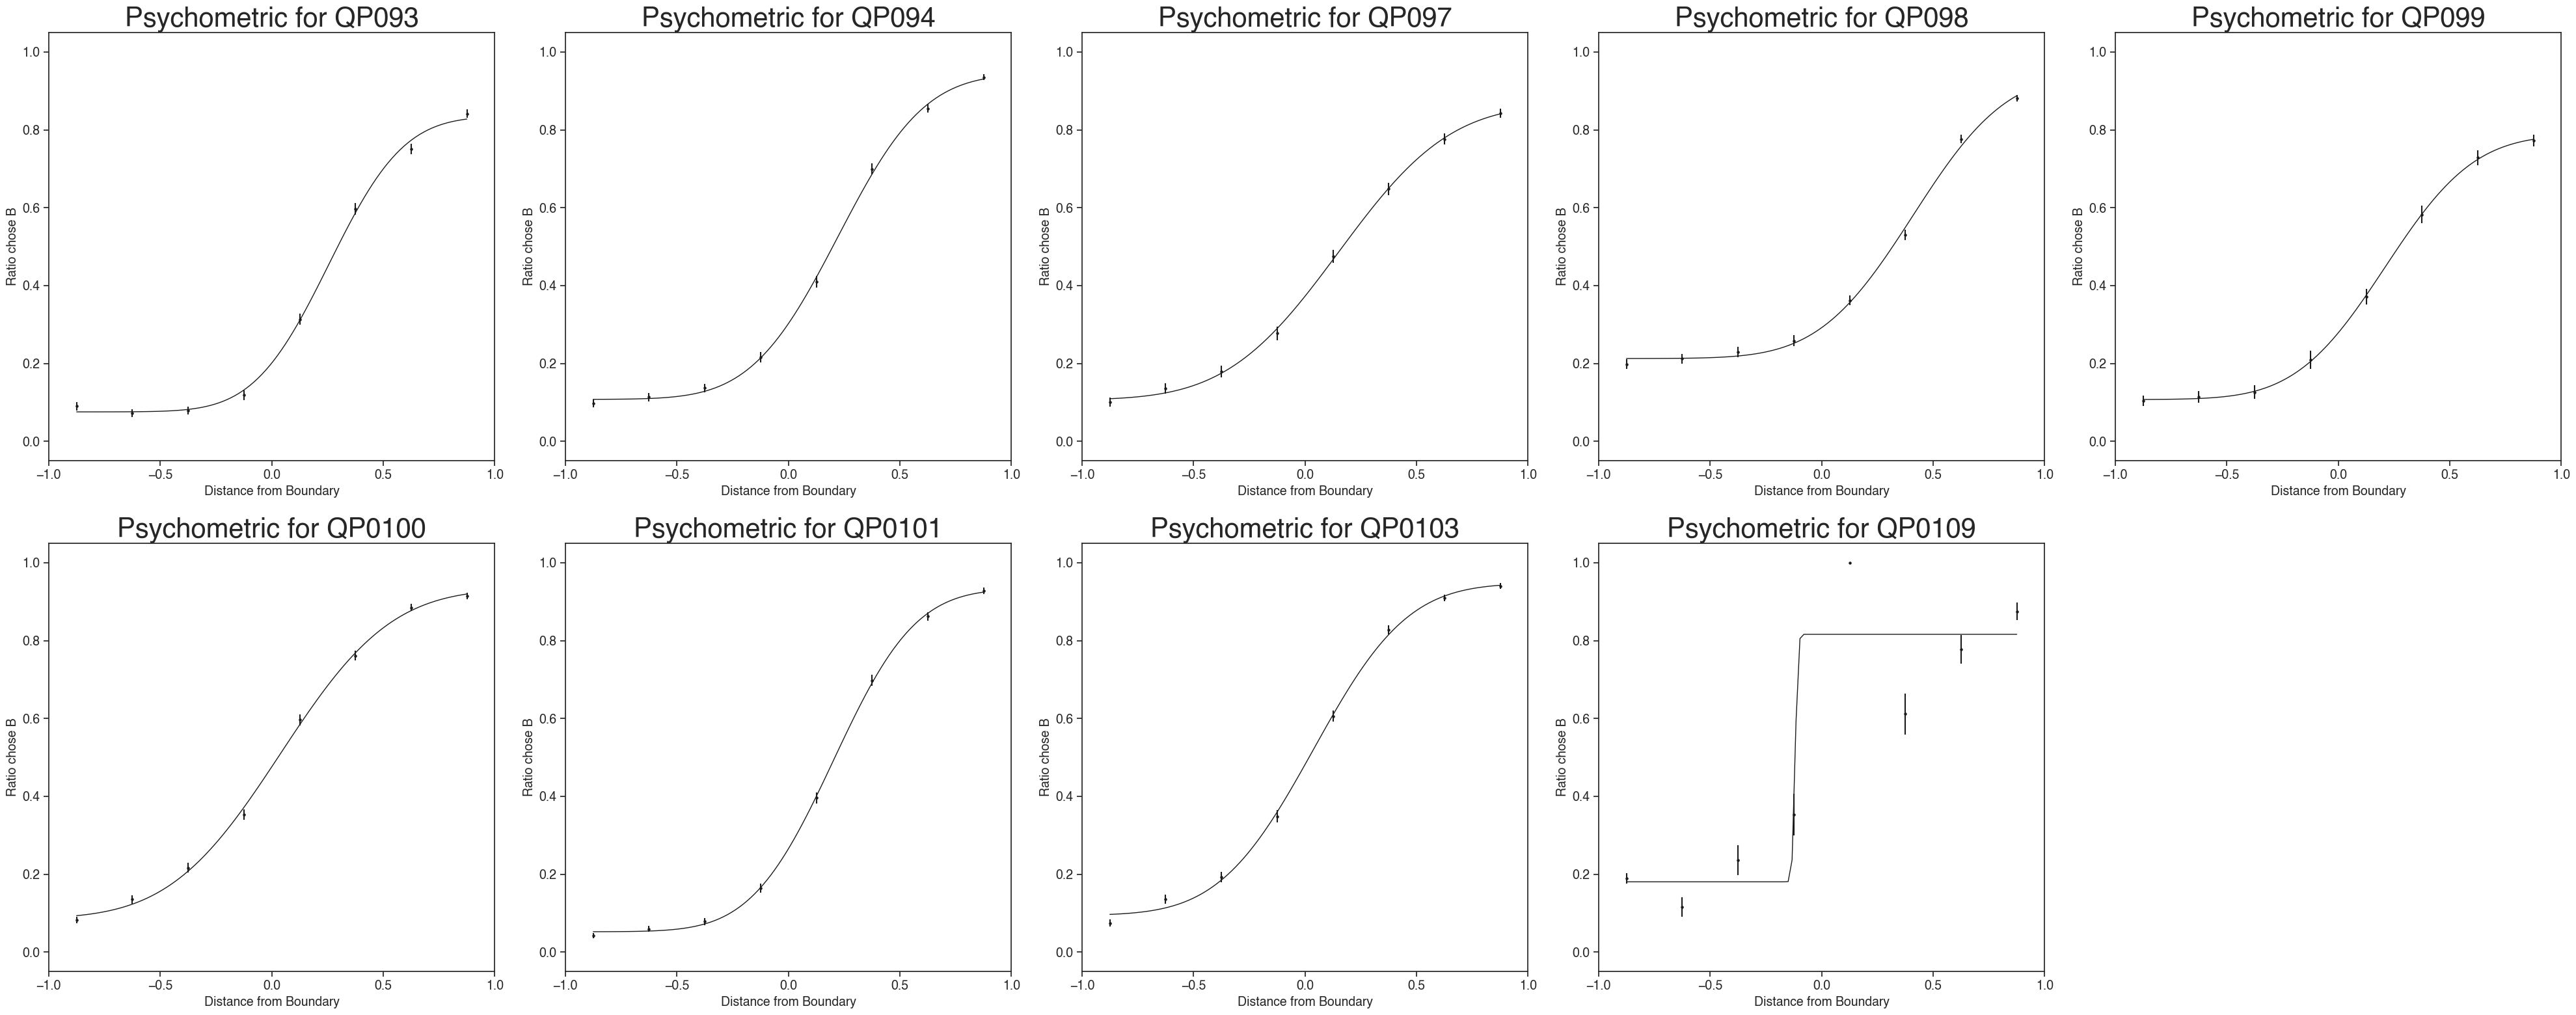

In [ ]:
plot_psycho_individual(df, Animal_List, save_path= figs_path + 'ACC_PPC_Psychometrics.pdf')

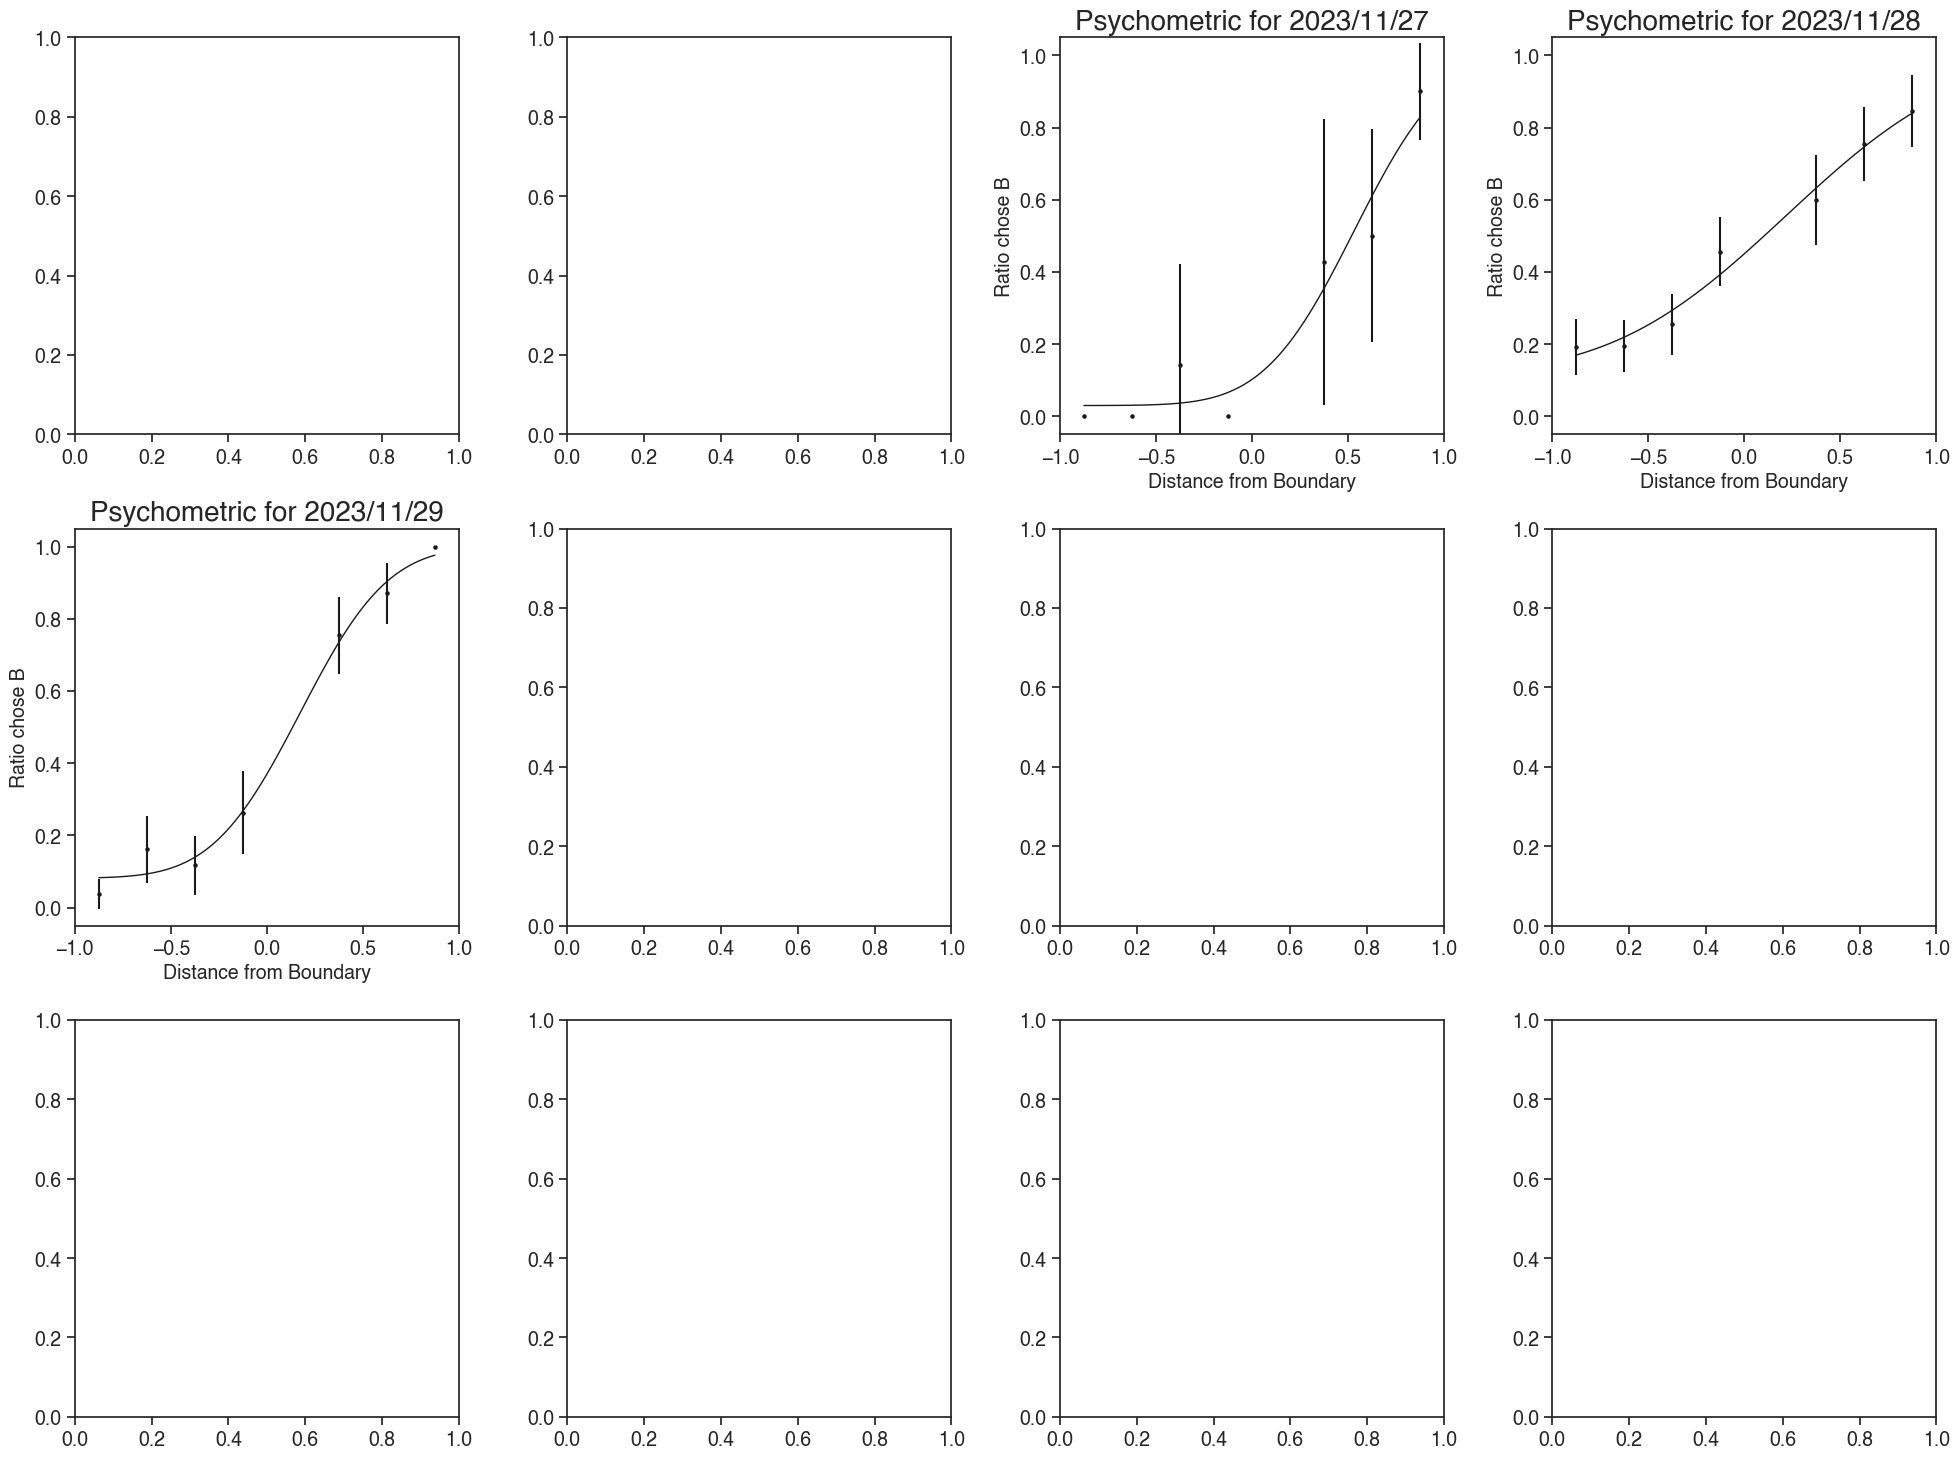

In [ ]:
sub_df = df[df.Participant_ID == 'QP0109']
# sub_df = sub_df[sub_df['Date'] == '2023/11/06']
dates = [
    '2023/11/25',
    '2023/11/26',
    '2023/11/27',
    '2023/11/28',
    '2023/11/29',
]
sub_df = sub_df[sub_df['Date'].isin(dates)]
# dates = sub_df['Date'].unique()
sub_df = sub_df[sub_df['No_Response'] == False].reset_index(drop=True)

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i, date in enumerate(dates):
    row = i // 4  # Integer division to determine row
    col = i % 4   # Modulo operation to determine column

    try:
        dates_df = sub_df[sub_df['Date'] == date]
        popt = ut.psycho_fit(dates_df)[0]
        ut.psycho_plot(dates_df, popt, label=None, color='k', ax=axes[row, col], legend=False)
        axes[row, col].set_title('Psychometric for ' + date, fontdict={'fontsize': 20})
    except:
        pass
plt.tight_layout()
plt.show()

In [ ]:
# KDEs


In [ ]:
# Step 1: Define the Gaussian kernel function
def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

# Step 2: Set the bandwidth using a simple rule of thumb
sigma = df['Stim_Relative'].std()
N = len(df['Stim_Relative'])
bandwidth = 1.06 * sigma * N**(-1/5)

# Step 3: Calculate KDE
# Generate a range of values for Stim_Relative
x_range = np.linspace(-1, 1, 1000)
kde_values = np.zeros_like(x_range)

# Calculate KDE for each point in x_range
for x in x_range:
    u = (x - df['Stim_Relative']) / bandwidth
    kde_values[np.where(x_range == x)] = np.mean(gaussian_kernel(u))

# Step 4: Plot KDE
plt.figure(figsize=(8, 6))
plt.plot(x_range, kde_values, label='Stim_Relative')
plt.title('Manually Calculated KDE of Stim_Relative')
plt.xlabel('Stim_Relative')
plt.ylabel('Density')
plt.legend()
plt.show()




In [ ]:
subj = 'QP0103'
dates = ['2023/11/01', '2023/11/02', '2023/11/03', '2023/11/04', '2023/11/05', '2023/11/06', '2023/11/07', '2023/11/08', '2023/11/09']
sub_df = df[(df['Participant_ID'] == subj) & (df['Date'].isin(dates))]
sub_df = sub_df[sub_df['No_Response'] == False].reset_index(drop=True)

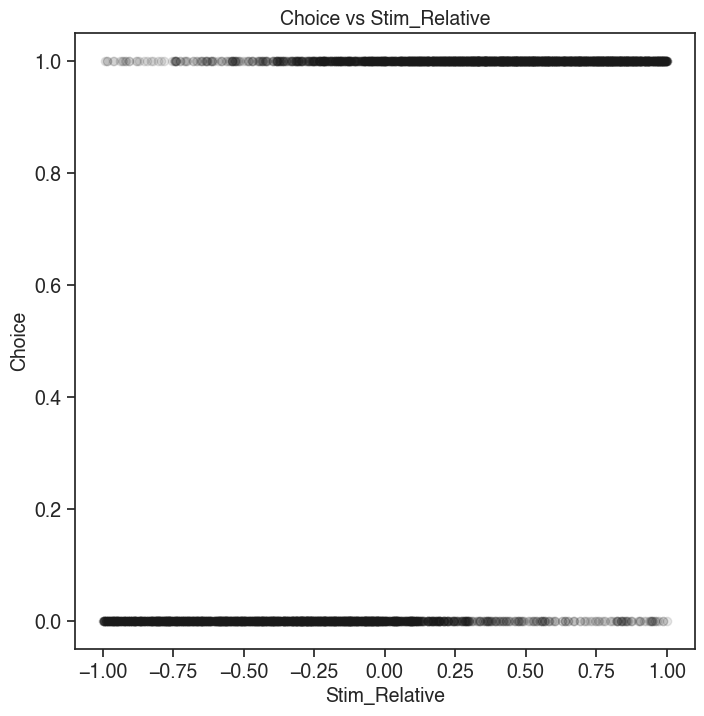

In [ ]:
# pot choice Vs Stim_Relative

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plt.plot(sub_df['Stim_Relative'], sub_df['choice'], 'o', color='k', alpha=0.1)
plt.xlabel('Stim_Relative')
plt.ylabel('Choice')
plt.title('Choice vs Stim_Relative')
plt.show()

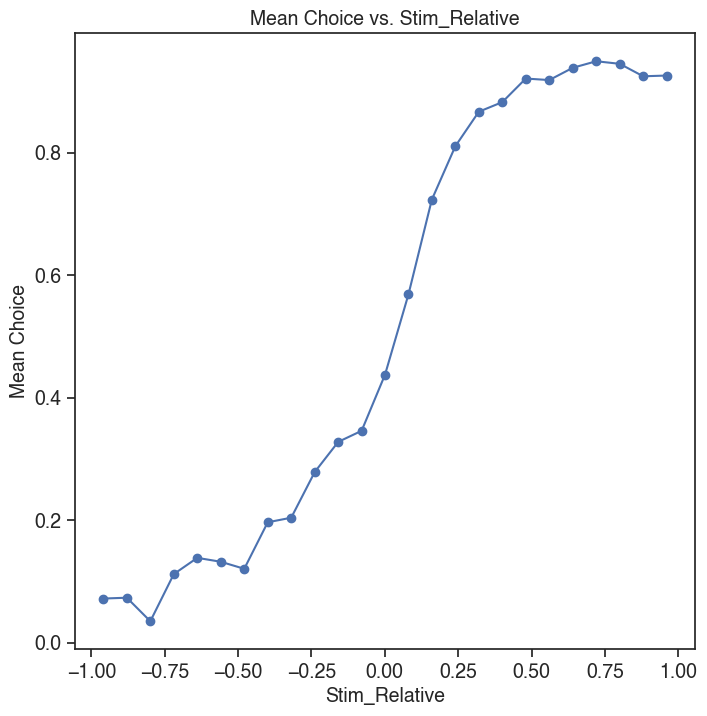

In [ ]:
# # Binning the Stim_Relative values
bin_count = 25  # You can adjust this for finer or coarser bins
sub_df['binned_stim_relative'] = pd.cut(sub_df['Stim_Relative'], bins=bin_count)

# Calculating mean choice for each bin
binned_mean = sub_df.groupby('binned_stim_relative')['choice'].mean()

# Getting the mid-point of each bin for plotting
bin_midpoints = binned_mean.index.map(lambda x: x.mid).astype(float)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(bin_midpoints, binned_mean, marker='o')
plt.title('Mean Choice vs. Stim_Relative')
plt.xlabel('Stim_Relative')
plt.ylabel('Mean Choice')
# plt.grid(True)
plt.show()


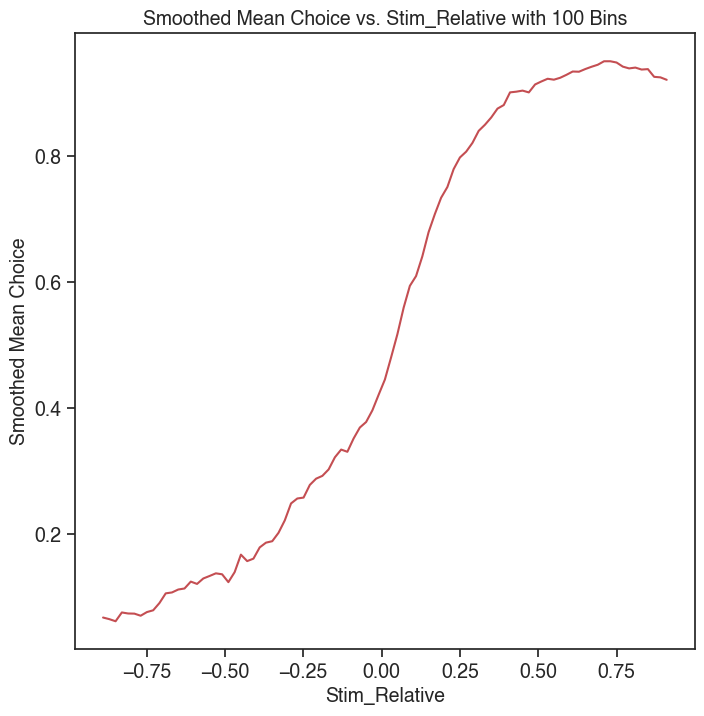

In [ ]:
# Increasing bin count to 100
bin_count = 100
sub_df['binned_stim_relative'] = pd.cut(sub_df['Stim_Relative'], bins=bin_count)

# Calculating mean choice for each bin
binned_mean = sub_df.groupby('binned_stim_relative')['choice'].mean()

# Getting the mid-point of each bin for plotting
bin_midpoints = binned_mean.index.map(lambda x: x.mid).astype(float)

# Applying a moving average for smoothing
window_size = 10  # Adjust this for more or less smoothing
smoothed_mean = binned_mean.rolling(window=window_size, center=True).mean()

# Plotting the smoothed line
plt.figure(figsize=(8, 8))
plt.plot(bin_midpoints, smoothed_mean, 
        #  marker='o',
          color='r')
plt.title('Smoothed Mean Choice vs. Stim_Relative with 100 Bins')
plt.xlabel('Stim_Relative')
plt.ylabel('Smoothed Mean Choice')
# plt.grid(True)
plt.show()


In [ ]:
# Break execution at this cell 
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Unif - Asym_R - Asym_L 

/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_31644/3516332198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Distribution'] = df['Distribution'].astype('category')
/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_31644/3516332198.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Distribution'] = df['Distribution'].astype('category')


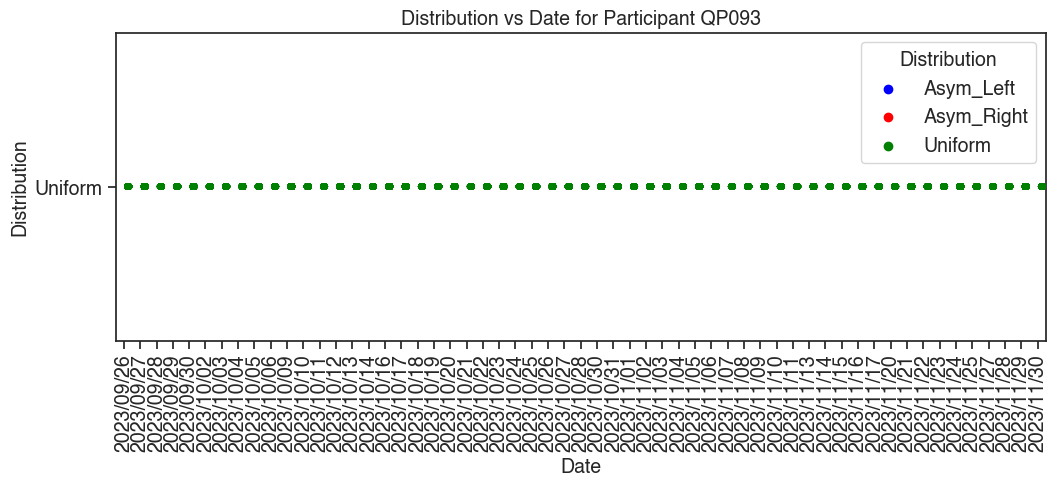

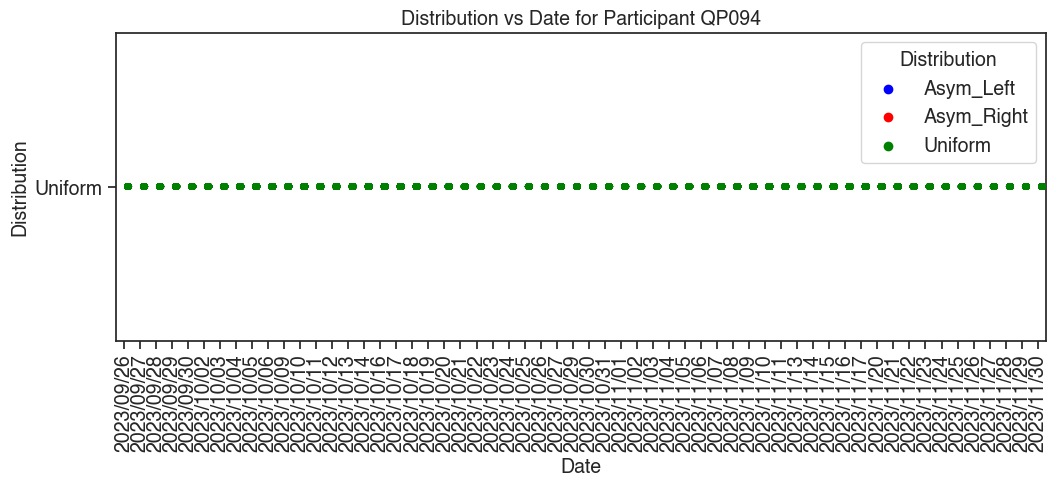

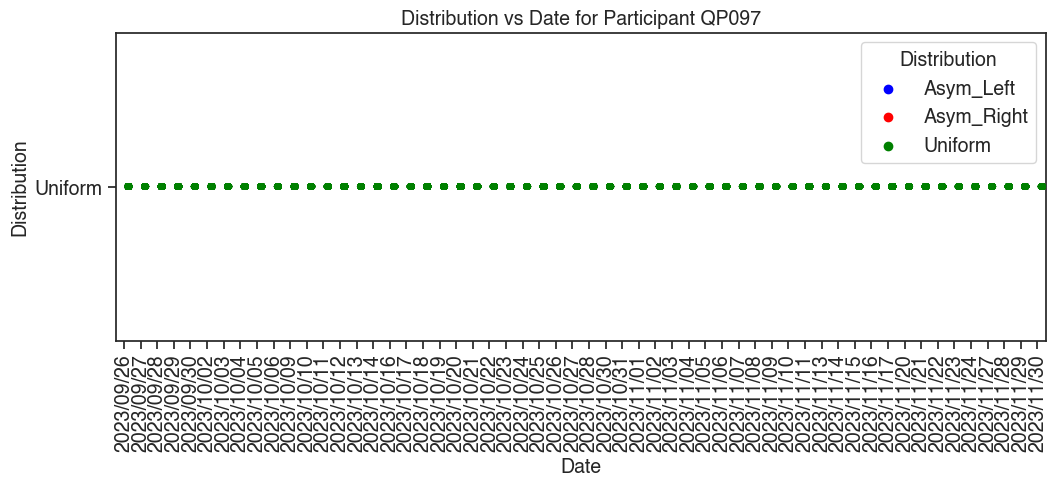

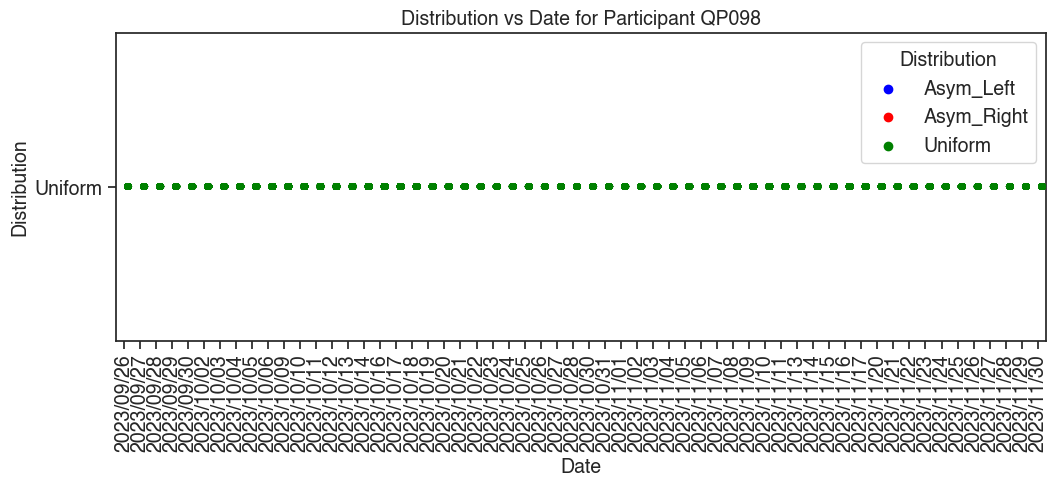

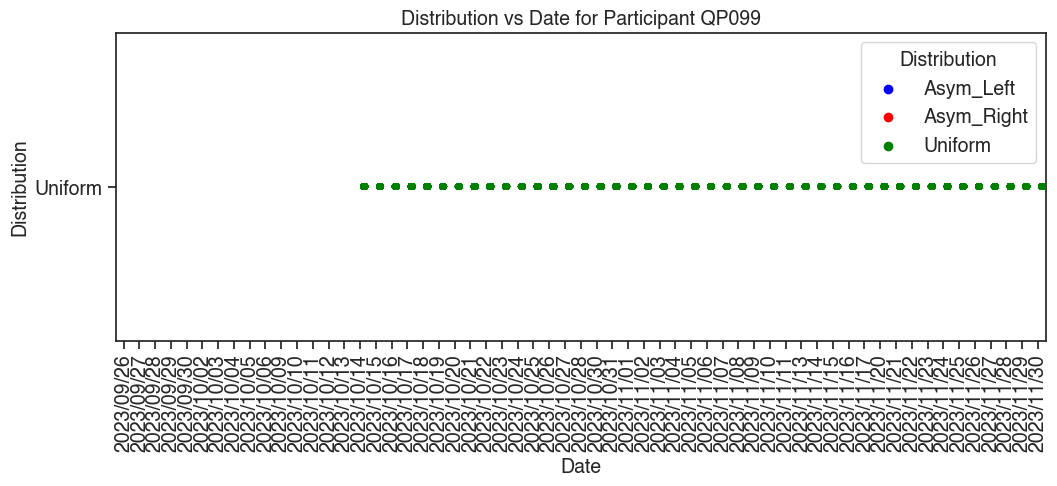

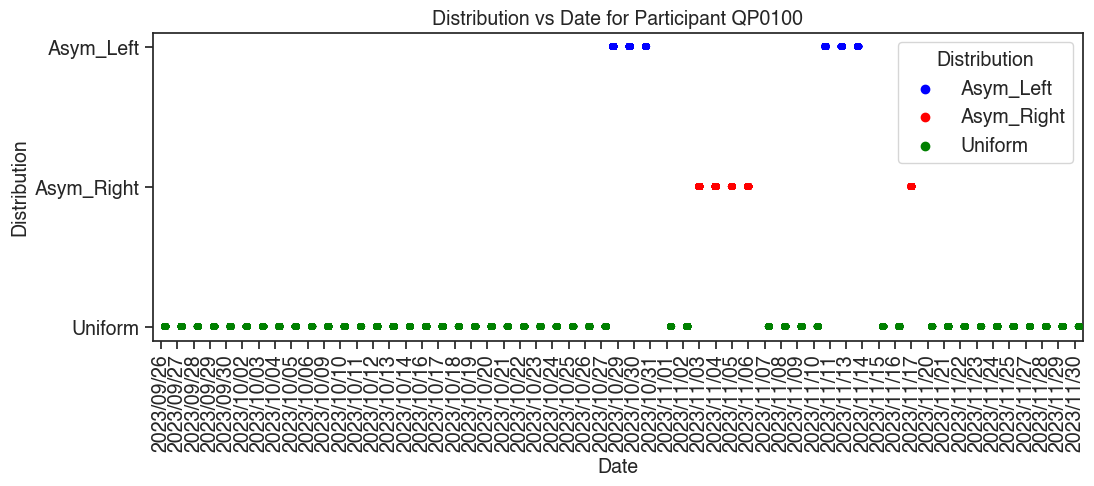

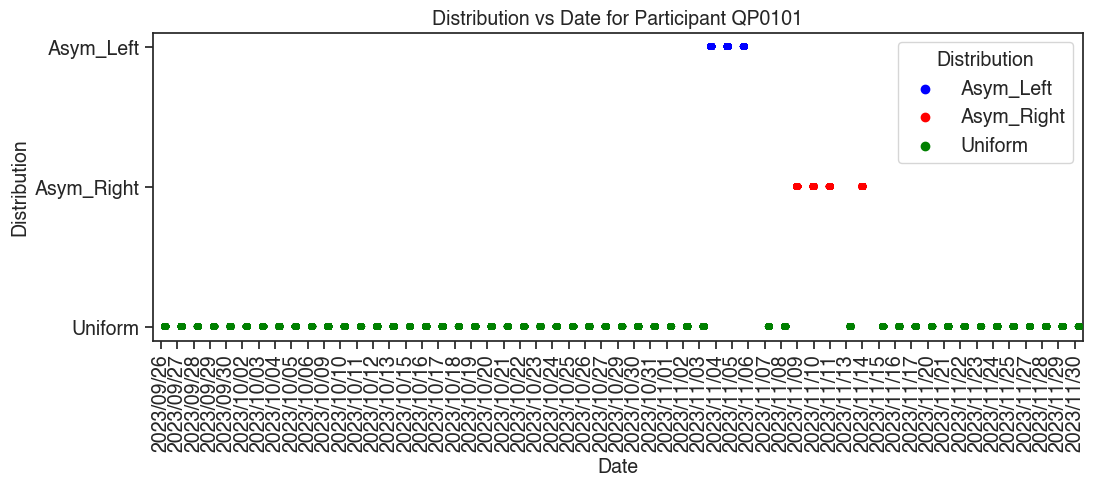

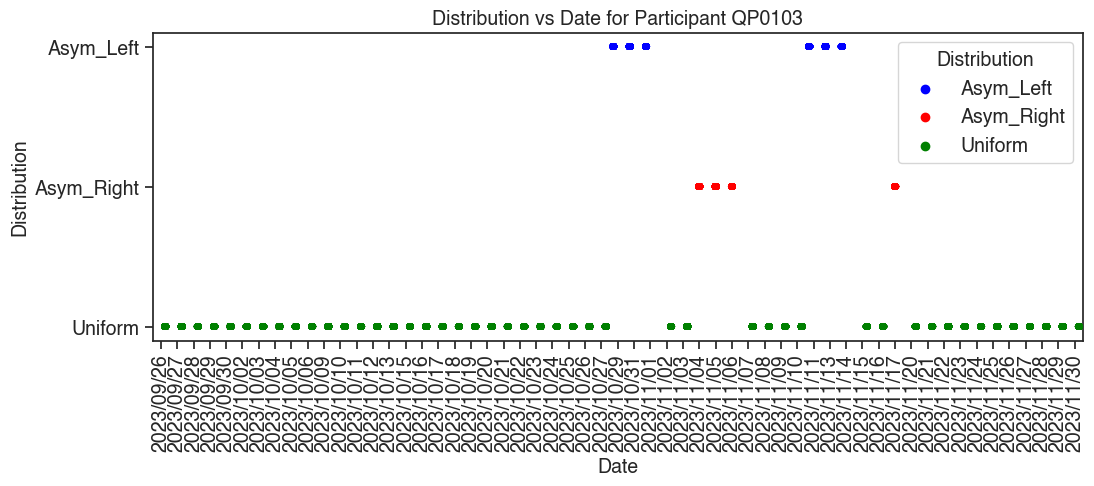

An error occurred for Participant_ID QP0109: The palette dictionary is missing keys: {'2023/11/02', '2023/11/07', '2023/11/15', '2023/11/27', '2023/11/13', '2023/11/03', '2023/11/21', '2023/11/28', '2023/11/14', '2023/10/31', '2023/11/08', '2023/11/20', '2023/11/11', '2023/11/16', '2023/11/22', '2023/11/17', '2023/11/10', '2023/11/06', '2023/11/29', '2023/11/30', '2023/11/09'}
An error occurred for Participant_ID nan: 'NoneType' object is not iterable


/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_31644/3516332198.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.stripplot(data=participant_df, x='Date', y='Distribution', hue='Distribution', jitter=True, dodge=True, marker='o', alpha=0.7, palette=color_dict)


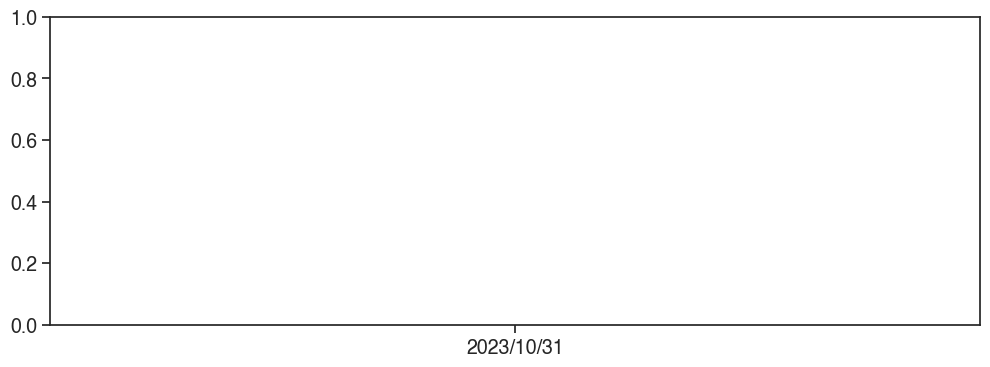

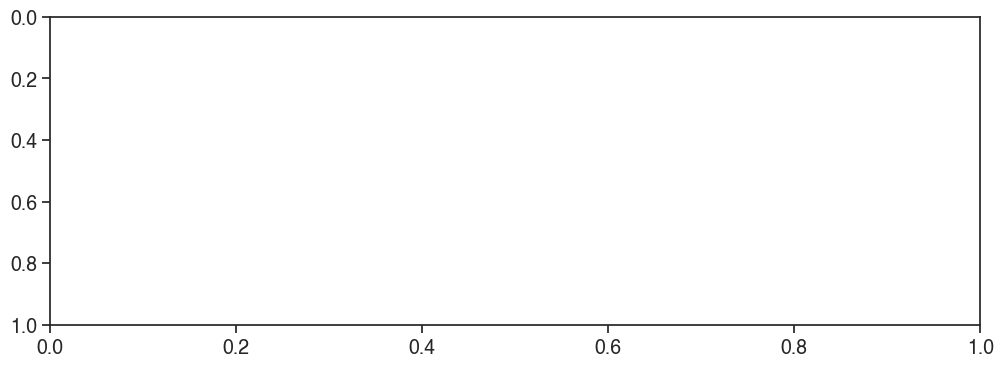

In [ ]:
# only keep date where Distribution is in ['Uniform', 'Asym_Left', 'Asym_Right', np.nan]
df = df[df['Distribution'].isin(['Uniform', 'Asym_Left', 'Asym_Right', np.nan])]
df['Distribution'] = df['Distribution'].astype('category')
# Convert 'Distribution' to categorical type if it's not already
df['Distribution'] = df['Distribution'].astype('category')

# Get unique Participant IDs
participant_ids = df['Participant_ID'].unique()
color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}

# Create a separate plot for each Participant_ID
for pid in participant_ids:
    plt.figure(figsize=(12, 4))
    
    # Filter the DataFrame for the current Participant_ID
    participant_df = df[df['Participant_ID'] == pid]
    
    try:
        # Create the plot
        sns.stripplot(data=participant_df, x='Date', y='Distribution', hue='Distribution', jitter=True, dodge=True, marker='o', alpha=0.7, palette=color_dict)
        
        # Customize the plot
        plt.title(f'Distribution vs Date for Participant {pid}')
        plt.xlabel('Date')
        plt.ylabel('Distribution')
        plt.xticks(rotation=90)
        plt.legend(title='Distribution')
        
        # Show the plot
        plt.show()
        
    except Exception as e:
        print(f"An error occurred for Participant_ID {pid}: {str(e)}")
        continue


In [ ]:
# select data for:
# QP0100, between 2023/10/26 and 2023/10/08
# QP0103, between 2023/10/26 and 2023/10/05
sub_df = df[((df['Participant_ID'] == 'QP0100') & (df['Date'] >= '2023/10/26') & (df['Date'] <= '2023/11/30')) | 
            ((df['Participant_ID'] == 'QP0103') & (df['Date'] >= '2023/10/26') & (df['Date'] <= '2023/11/30'))].reset_index(drop=True)

# remove blocks with less than 100 rows/trials
sub_df = filter_min_rows(sub_df, threshold=100, iterator='Participant_ID', feature='block')

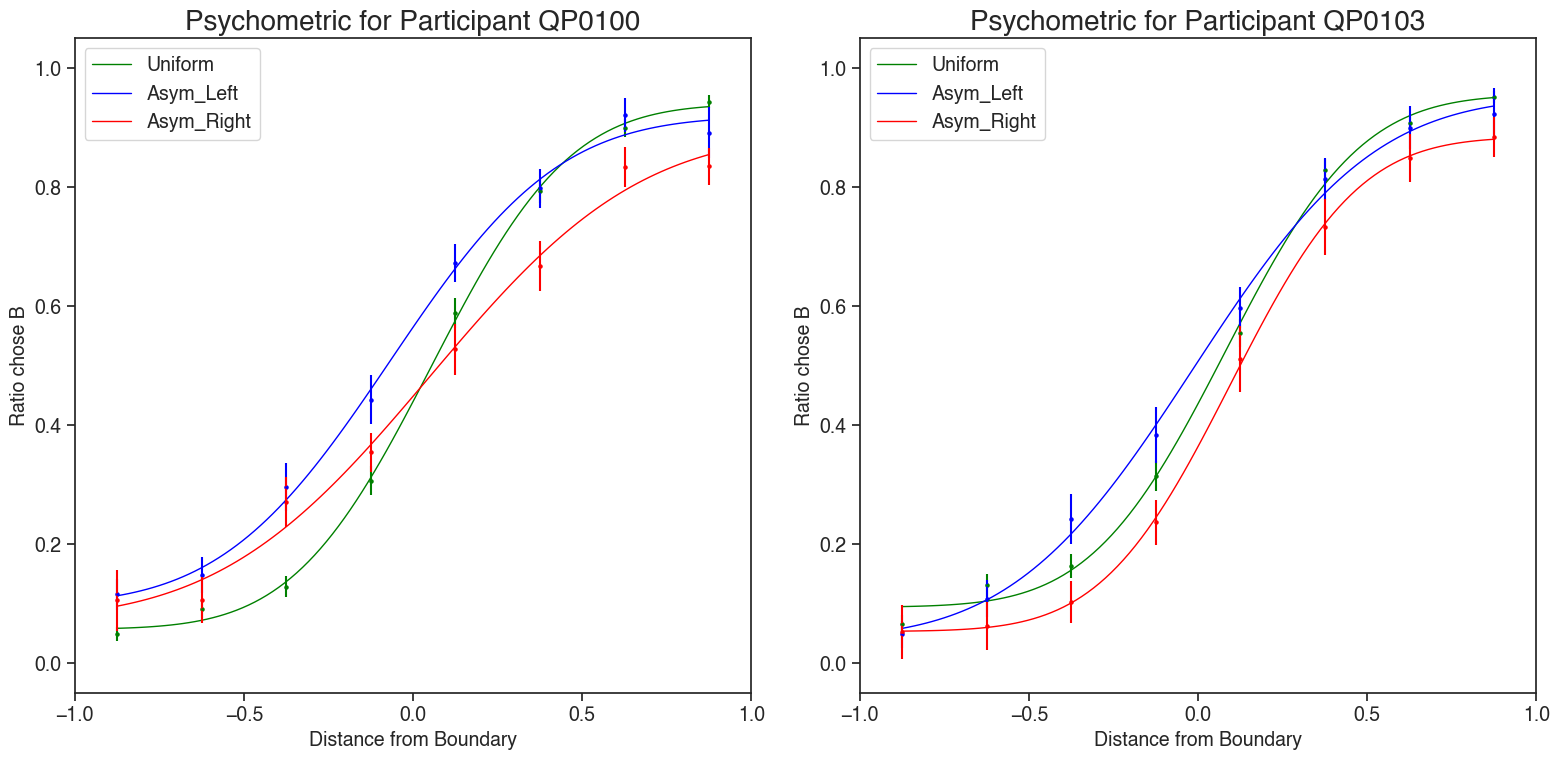

In [ ]:
dist_color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}

participant_ids = sub_df['Participant_ID'].unique()
n_participants = len(participant_ids)

# Create a figure with a subplot for each participant
fig, axes = plt.subplots(1, n_participants, figsize=(n_participants * 8, 8))

for i, p_id in enumerate(participant_ids):
    pid_df = sub_df[sub_df['Participant_ID'] == p_id]
    ax = axes[i]  # Select the i-th subplot
    # ax = axes  # Select the i-th subplot

    for dist in pid_df['Distribution'].unique():
        dist_df = pid_df[pid_df['Distribution'] == dist]
        popt = ut.psycho_fit(dist_df)[0]
        ut.psycho_plot(dist_df, popt, label=dist, color=dist_color_dict[dist], ax=ax)

    ax.set_title(f'Psychometric for Participant {p_id}', fontdict={'fontsize': 20})
    # Only add legend to the last subplot
    # if i == n_participants - 1:
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
# save the figure as a pdf in the figures folder
plt.savefig(figs_path + 'QP0100_QP0103_Psychometrics.pdf', dpi=300, bbox_inches='tight')
plt.show()




In [ ]:
p_ids = sub_df['Participant_ID'].unique()
psych_params_df = ut.gen_blockwise_psych_params(sub_df, p_ids)


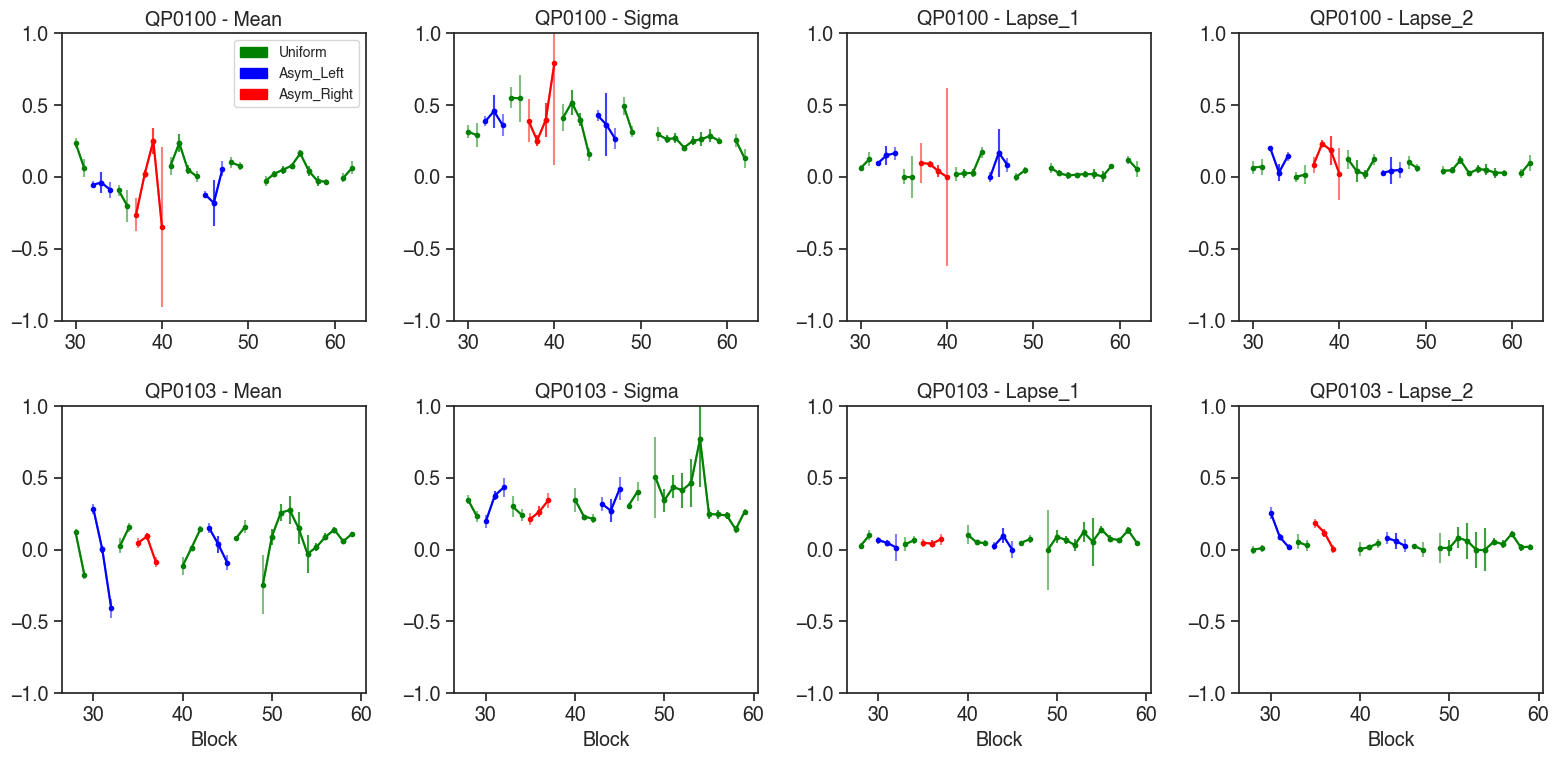

In [ ]:
# remove outliers
# clean_psych_params_df = psych_params_df[psych_params_df.Block_Means_Std <= 100000.25].reset_index(drop=True) 
ut.plot_blockwise_psych_params(df = psych_params_df, 
                               participant_ids = p_ids, 
                               distributions= ['Uniform', 'Asym_Left', 'Asym_Right'],
                               color_dict = dist_color_dict,
                               )

In [ ]:
# psych_params_df

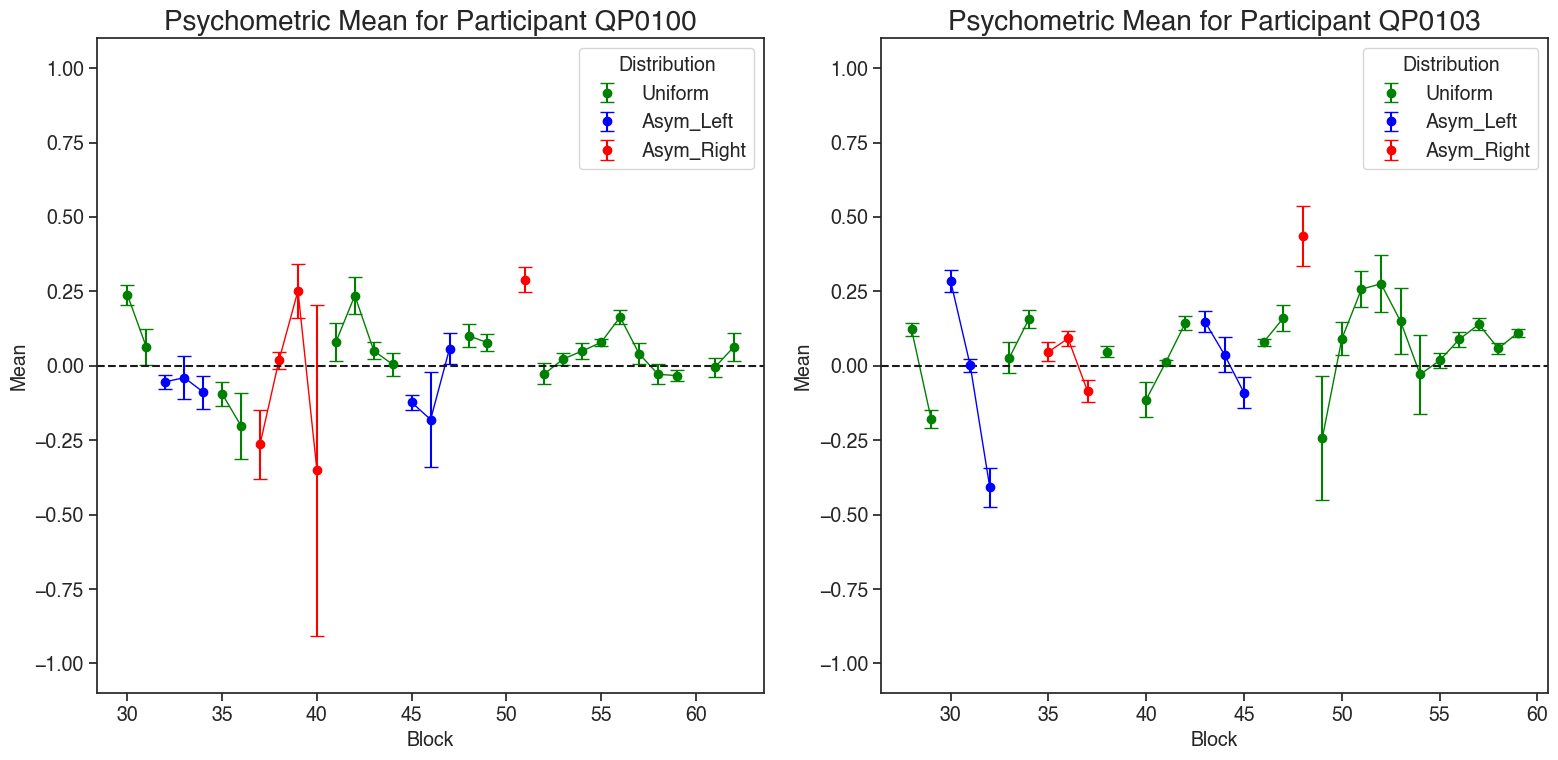

In [ ]:
fig, axes = plt.subplots(1, len(p_ids), figsize=(len(p_ids) * 8, 8))

color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}
for i, p_id in enumerate(p_ids):
    ax = axes[i]  # Select the i-th subplot
    pid_df = psych_params_df[psych_params_df['Participant_ID'] == p_id]

    # Iterate over each unique distribution
    for dist in pid_df['Distribution'].unique():
        dist_df = pid_df[pid_df['Distribution'] == dist].sort_values(by='Block')

        # Plot error bars for each distribution
        ax.errorbar(x=dist_df['Block'], y=dist_df['Block_Means'], yerr=dist_df['Block_Means_Std'], fmt='o', ecolor=color_dict[dist], capsize=5, label=dist, color=color_dict[dist]) 

        # Plot lines for adjacent blocks within the same distribution
        for k, grp in dist_df.groupby((dist_df['Block'].diff() != 1).cumsum()):
            ax.plot(grp['Block'], grp['Block_Means'], color=color_dict[dist], linestyle='-', linewidth=1)

    ax.set_title(f'Psychometric Mean for Participant {p_id}', fontdict={'fontsize': 20})
    ax.legend(title='Distribution')
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel('Block')
    ax.set_ylabel('Mean')

# Adjust layout to prevent overlap
plt.tight_layout()
# save the figure as a pdf in the figures folder
plt.savefig(figs_path + 'QP0100_QP0103_Psychometrics_Mean.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
participant_ids = ['QP094', 'QP097','QP0100', 'QP0101', 'QP0103']
date_limit = '2023/10/15'
sub_df = df[(df['Participant_ID'].isin(participant_ids)) & (df['Date'] <= date_limit)].reset_index(drop=True)
# remove no_response trials
sub_df = sub_df[sub_df['No_Response'] == False].reset_index(drop=True)
# only keen the data where Stim_Relative is in [-1, 1]
sub_df = sub_df[(sub_df['Stim_Relative'] >= -1) & (sub_df['Stim_Relative'] <= 1)].reset_index(drop=True)

In [ ]:
def compute_kde(df, x_range, stimuli, choices, sigma = 0.1):
    """
    Computes the KDE for a given range of x values.
    Args:
        df (pd.DataFrame): The dataframe containing the data
        x_range (np.array): The range of x values to compute the KDE for
        stimuli (np.array): The array of stimuli
        choices (np.array): The array of choices
        sigma (float): The kernel width
    Returns:
        p (np.array): The KDE values for each x value    
    """
    # Calculate the distances between each x value and each stimulus
    d = np.abs(x_range[:, np.newaxis] - stimuli[np.newaxis, :])
    
    # Calculate the weights using the Gaussian kernel
    w = np.exp(-(1/2)*(d/sigma)**2)
    
    # Normalize the weights
    w = w / np.sum(w, axis=1)[:, np.newaxis]
    
    # Calculate the KDE values
    p = np.dot(w, choices)
    
    return p

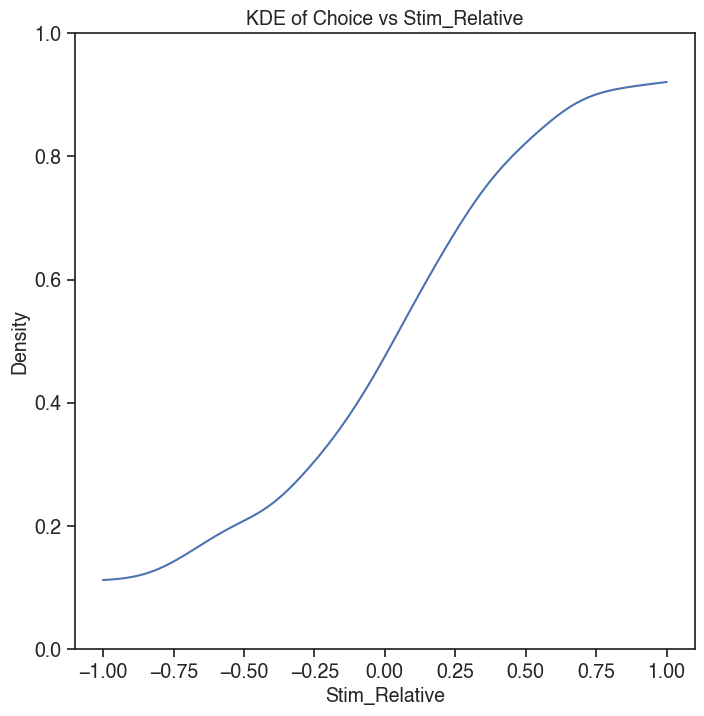

In [ ]:
kde = compute_kde(df = sub_df, x_range = np.linspace(-1, 1, 101),
            stimuli = sub_df.Stim_Relative.values,
            choices = sub_df.choice.values,
            sigma = 0.1)

fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.linspace(-1, 1, 101), kde)
plt.ylim(0, 1)
ax.set_title('KDE of Choice vs Stim_Relative')
ax.set_xlabel('Stim_Relative')
ax.set_ylabel('Density')
plt.show()

In [ ]:
def compute_bootstrap_kdes(df, x_range, s, c, sigma=0.1, n_bootstraps=100):
    """
    Optimized version of the compute_bootstrap_kdes function for computing KDE.
    """
    indices = np.random.choice(len(s), size=(n_bootstraps, len(s)), replace=True)
    stimuli_resampled = s[indices]
    choices_resampled = c[indices]
    x_range_reshaped = x_range.reshape(len(x_range), 1, 1)

    # Using broadcasting for efficient computation
    d = x_range_reshaped - stimuli_resampled
    w_new = np.exp(-(1 / 2) * (d / sigma) ** 2)

    # Combining sum and division in a single step
    w_new /= np.sum(w_new, axis=2, keepdims=True)

    bootstrap_kdes = np.zeros((n_bootstraps, len(x_range)))  # Pre-allocate array for performance
    for boot in range(n_bootstraps):
        kde = np.dot(w_new[:, boot, :], choices_resampled[boot])
        bootstrap_kdes[boot] = kde  # Store the result in pre-allocated array

    return bootstrap_kdes

In [ ]:
kde = compute_kde(df = sub_df, x_range = np.linspace(-1, 1, 101),
            stimuli = sub_df.Stim_Relative.values,
            choices = sub_df.choice.values,
            sigma = 0.1)

In [ ]:
num_iterations = 10
boots_per_iter = 100
n = len(np.linspace(-1, 1, 101))
kde_boot_tensor = np.zeros((num_iterations, boots_per_iter, n))

for i in range(num_iterations):
    # print every 10th iteration
    if i % 1 == 0:
        print('Iteration: ', i)
    kde_boot_tensor[i] = compute_bootstrap_kdes(df = sub_df, x_range = np.linspace(-1, 1, 101),
            s = sub_df.Stim_Relative.values,
            c = sub_df.choice.values,
            sigma = 0.1,
            n_bootstraps = boots_per_iter)

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9


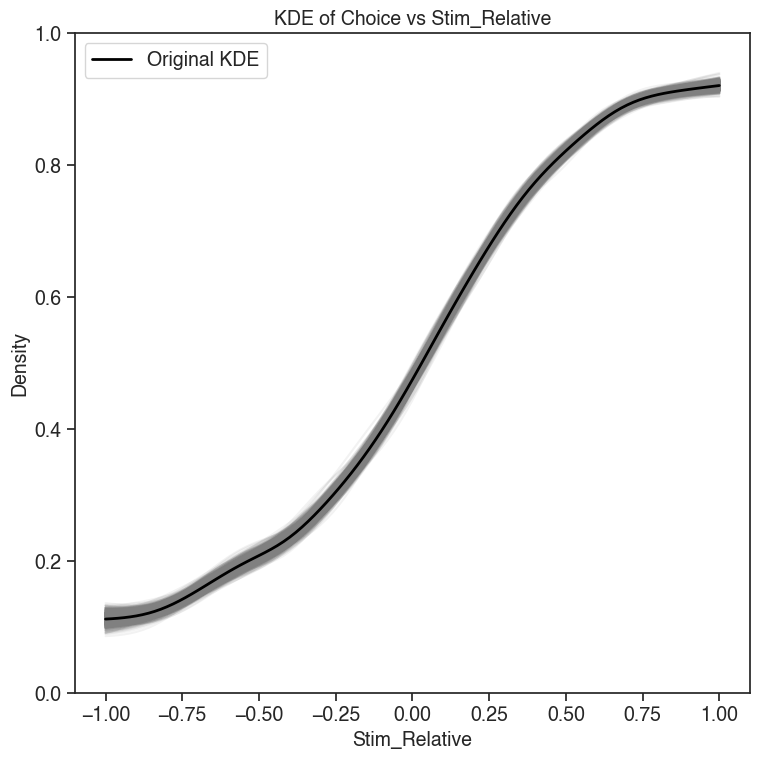

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(num_iterations):
    for j in range(boots_per_iter):
        plt.plot(np.linspace(-1, 1, 101), kde_boot_tensor[i, j, :], color='gray', alpha=0.1)
ax.plot(np.linspace(-1, 1, 101), kde, label='Original KDE', lw=2, color = 'black')
plt.ylim(0, 1)
ax.set_title('KDE of Choice vs Stim_Relative')
ax.set_xlabel('Stim_Relative')
ax.set_ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Opto psychometrics

In [ ]:
# select data for:
# QP0100, between 2023/10/26 and 2023/10/08
# QP0103, between 2023/10/26 and 2023/10/05
sub_df = df[((df['Participant_ID'] == 'QP0100') & (df['Date'] >= '2023/11/09')) | 
            ((df['Participant_ID'] == 'QP0103') & (df['Date'] >= '2023/11/09'))].reset_index(drop=True)

# remove blocks with less than 100 rows/trials
sub_df = filter_min_rows(sub_df, threshold=100, iterator='Participant_ID', feature='block')


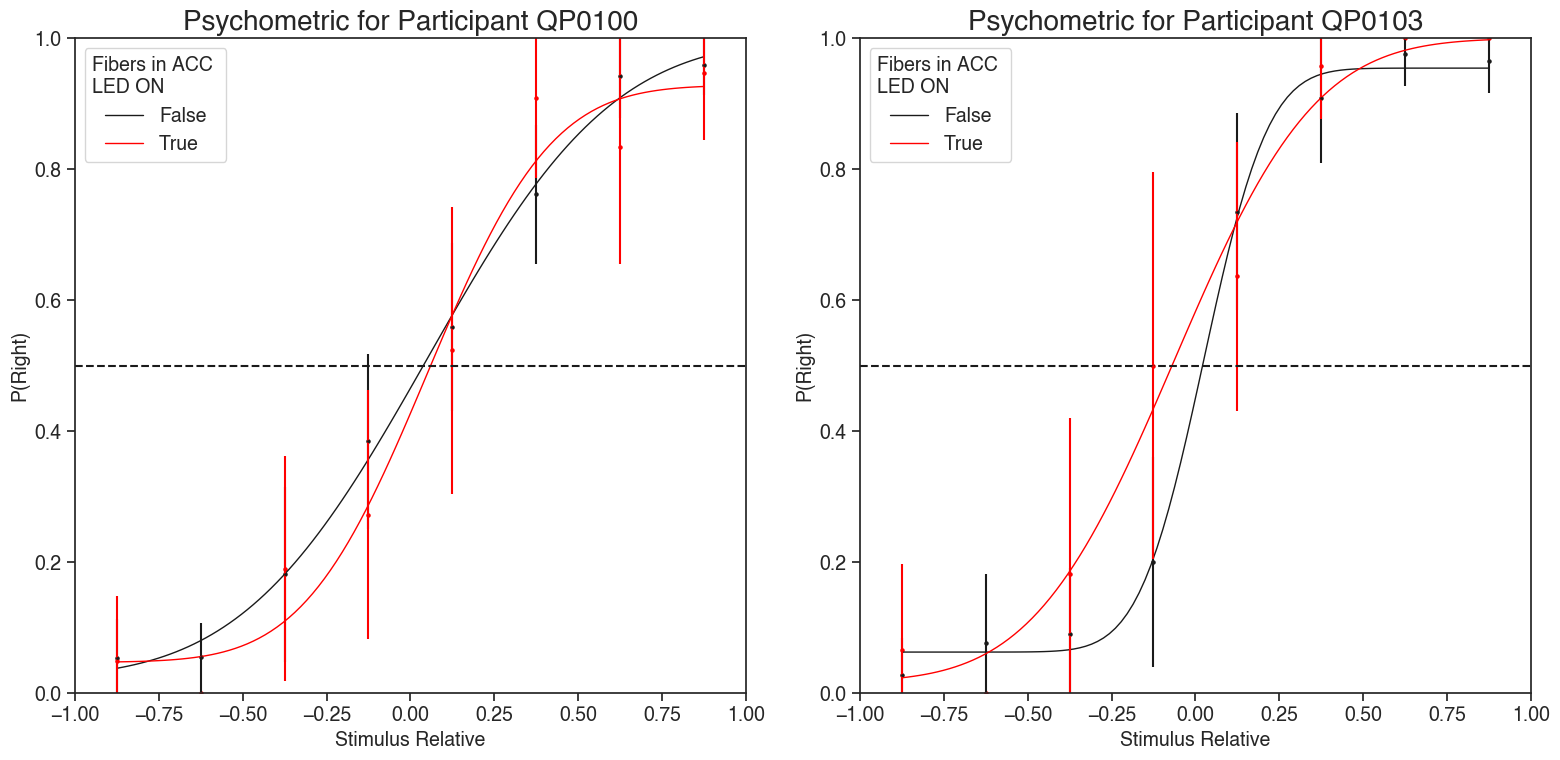

In [ ]:
# plot, for each participant, the psychometric curve for Fiber = True and Fiber = False

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
color_dict = {True: 'red', False: 'k'}

for i, p_id in enumerate(['QP0100', 'QP0103']):
    ax = axes[i]  # Select the i-th subplot
    pid_df = sub_df[sub_df['Participant_ID'] == p_id]

    # Iterate over each unique distribution
    for condition in pid_df['Fiber'].unique():
        condition_df = pid_df[pid_df['Fiber'] == condition]

        # Plot error bars for each distribution
        popt = ut.psycho_fit(condition_df)[0]
        ut.psycho_plot(condition_df, popt, label=condition, color=color_dict[condition], ax=ax)

        # # Plot lines for adjacent blocks within the same distribution
        # for k, grp in fiber_df.groupby((fiber_df['Stim_Relative'].diff() != 0).cumsum()):
        #     ax.plot(grp['Stim_Relative'], grp['P_Right'], color=color_dict[fiber], linestyle='-', linewidth=1)

    ax.set_title(f'Psychometric for Participant {p_id}', fontdict={'fontsize': 20})
    ax.legend(title='Fiber')
    ax.axhline(y=0.5, color='k', linestyle='--')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Stimulus Relative')
    ax.set_ylabel('P(Right)')
    ax.set_xticks(np.arange(-1, 1.1, 0.25))
    # create a legend for the plot
    legend = ax.legend()
    legend.set_title("Fibers in ACC \nLED ON")
# Adjust layout to prevent overlap
plt.tight_layout()
# save the figure as a pdf in the figures folder
# plt.savefig(figs_path + 'QP0100_QP0103_Psychometrics_Fiber.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# show all columns in the dataframe
pd.set_option('display.max_columns', None)

In [ ]:
# isolate data for QP094, Date = 2023-10-18
subj = 'QP094'
dates_to_keep = [
                '2023/10/20', 
                 '2023/10/21', 
                 '2023/10/22', 
                 '2023/10/23', 
                 '2023/10/24',
                 '2023/11/02',
                 ]
opto_df = df[(df['Participant_ID'] == subj) & (df['Date'].isin(dates_to_keep))]

alm_left_dates = ['2023/10/20', '2023/10/22', '2023/10/24']
alm_right_dates = ['2023/10/21', '2023/10/23', '2023/11/02']

In [ ]:
def psycho_plot(df, popt, label, color, ax, marker='o', x='stim_relative_binned', y='choice', scatter=True, legend=True):
    # Aggregate choice data for plotting
    choice_data = df.groupby(x)[y].agg(['mean', 'count', 'sem'])
    x_data = choice_data.index
    y_data = choice_data['mean'].values

    # Scatter plot with error bars if specified
    if scatter:
        ax.errorbar(x_data, y_data, yerr=None, 
                    fmt=marker, markersize=10, color=color, linestyle='None')  # No line connecting the points

    # Plot the psychometric function
    x_fit = np.linspace(min(x_data), max(x_data), 100)
    y_fit = ut.psychometric(x_fit, *popt)
    ax.plot(x_fit, y_fit, label=label, color=color, linewidth=2)

    # Set plot limits and labels if needed
    ax.set_ylim(0, 1)
    ax.set_xlim(x_data.min(), x_data.max())
    if legend:
        ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


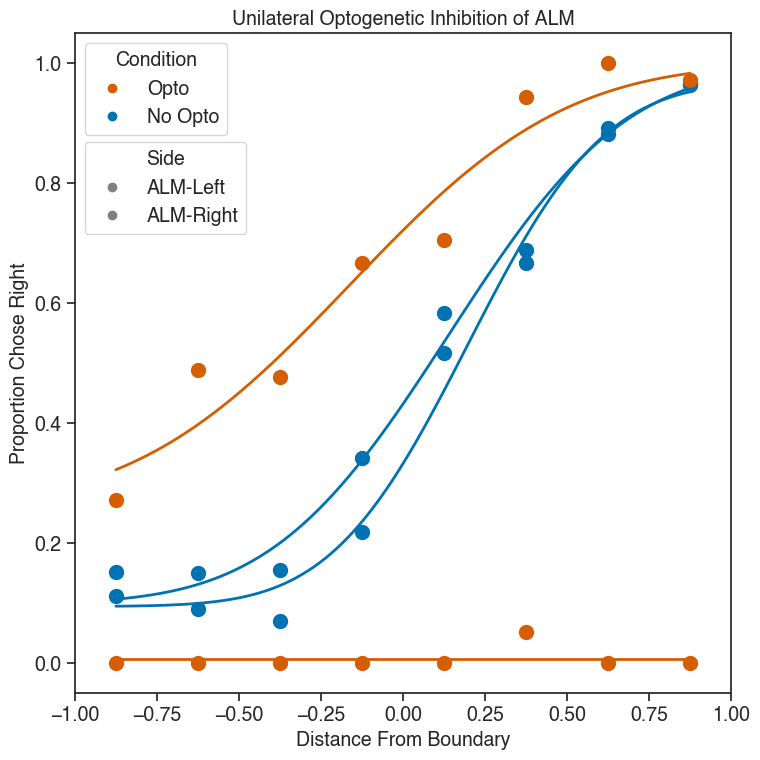

In [ ]:
# Define color and marker mappings
color_dict = {True: '#D55E00', False: '#0072B2'}  # Orange for True (opto), Blue for False (no opto)
marker_dict = {'alm_left': 'o', 'alm_right': 'o'}  # Circle for left, X for right

fig, ax = plt.subplots(figsize=(8, 8))

# Plot psychometric curves for each condition and side, but don't include legend labels here
for side, dates in zip(['alm_left', 'alm_right'], [alm_left_dates, alm_right_dates]):
    side_df = opto_df[opto_df['Date'].isin(dates)]
    for condition in side_df['Zapit'].unique():
        condition_df = side_df[side_df['Zapit'] == condition]
        popt = ut.psycho_fit(condition_df)[0]
        psycho_plot(condition_df, popt, 
                       label=None,  # Don't specify a label here
                       color=color_dict[condition], 
                       marker=marker_dict[side],
                       ax=ax)

ax.set_xlabel('Distance From Boundary')
ax.set_ylabel('Proportion Chose Right')
ax.set_title('Unilateral Optogenetic Inhibition of ALM')
# set x and y limits
ax.set_xlim(-1, 1)
ax.set_ylim(-0.05, 1.05)
# set x_ticks
# ax.set_xticks([-0.875, -0.625, -0.375, -0.125, 0.125, 0.375, 0.625, 0.875])
# x label

# Create custom legends
# Legend for colors
legend_color = [Line2D([0], [0], color=color_dict[True], marker='o', linestyle='None', label='Opto'),
                Line2D([0], [0], color=color_dict[False], marker='o', linestyle='None', label='No Opto')]
legend_marker = [Line2D([0], [0], color='gray', marker=marker_dict['alm_left'], linestyle='None', label='ALM-Left'),
                 Line2D([0], [0], color='gray', marker=marker_dict['alm_right'], linestyle='None', label='ALM-Right')]

# Plot legends
first_legend = ax.legend(handles=legend_color, title='Condition', loc='upper left')
ax.add_artist(first_legend)
ax.legend(handles=legend_marker, title='Side', bbox_to_anchor=(0.0, 0.85), loc='upper left')

plt.tight_layout()
# If you have a path to save the figure, uncomment the next line
plt.savefig(figs_path + 'QP094_ALM_Opto.pdf', dpi=300, bbox_inches='tight')

plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


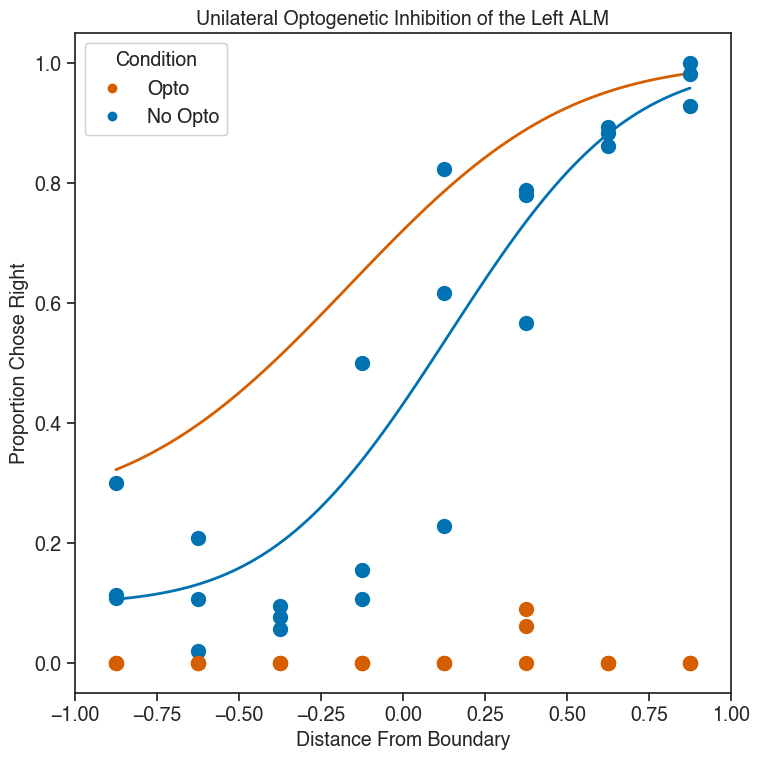

In [ ]:
# generate the same plot, but just for the ALM-Left condition
fig, ax = plt.subplots(figsize=(8, 8))

# Plot psychometric curves for each condition and side, but don't include the data
side_df = opto_df[opto_df['Date'].isin(dates)]
for condition in side_df['Zapit'].unique():
    condition_df = side_df[side_df['Zapit'] == condition]
    popt = ut.psycho_fit(condition_df)[0]
    psycho_plot(condition_df, popt, 
                    label=None,  # Don't specify a label here
                    color=color_dict[condition], 
                    marker=marker_dict[side],
                    ax=ax, scatter=False)
    
# plot the raw data
for date in alm_left_dates:
    date_df = opto_df[opto_df['Date'] == date]
    for condition in date_df['Zapit'].unique():
        condition_df = date_df[date_df['Zapit'] == condition]
        choice_data = condition_df.groupby('stim_relative_binned')['choice'].agg(['mean', 'count', 'sem'])
        x_data = choice_data.index
        y_data = choice_data['mean'].values
        ax.errorbar(x_data, y_data, yerr=None,
                    fmt=marker_dict['alm_left'], markersize=10, color=color_dict[condition], linestyle='None')
        
ax.set_xlabel('Distance From Boundary')
ax.set_ylabel('Proportion Chose Right')
ax.set_title('Unilateral Optogenetic Inhibition of the Left ALM')
# set x and y limits
ax.set_xlim(-1, 1)
ax.set_ylim(-0.05, 1.05)

# Legend for colors
legend_color = [Line2D([0], [0], color=color_dict[True], marker='o', linestyle='None', label='Opto'),
                Line2D([0], [0], color=color_dict[False], marker='o', linestyle='None', label='No Opto')]

# Plot legends
first_legend = ax.legend(handles=legend_color, title='Condition', loc='upper left')
ax.add_artist(first_legend)

plt.tight_layout()
# plt.savefig(figs_path + 'QP094_ALM_Left_Opto.pdf', dpi=300, bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


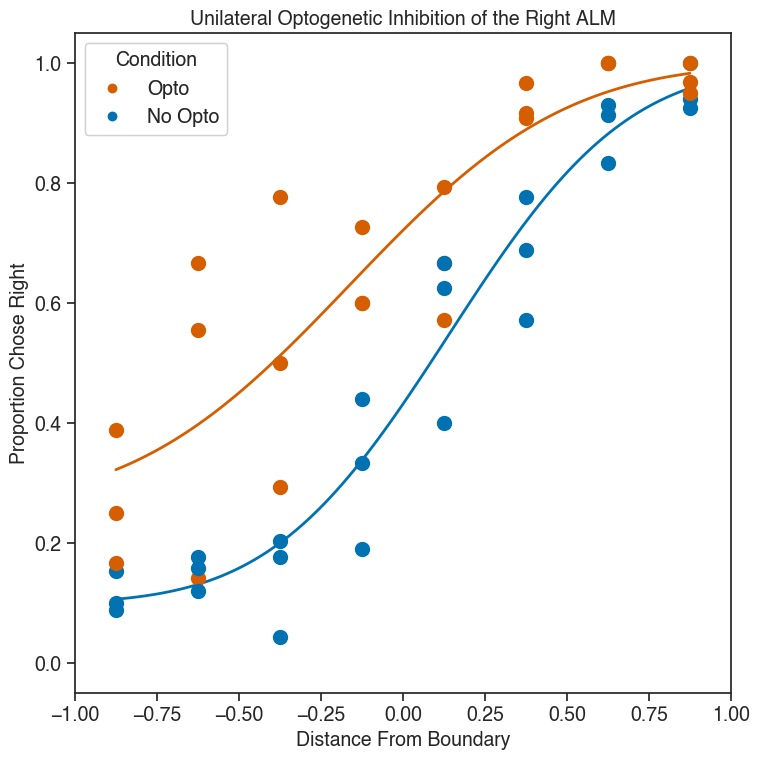

In [ ]:
# make the same plot, but just for the ALM-Right condition
fig, ax = plt.subplots(figsize=(8, 8))

# Plot psychometric curves for each condition and side, but don't include the data
side_df = opto_df[opto_df['Date'].isin(dates)]
for condition in side_df['Zapit'].unique():
    condition_df = side_df[side_df['Zapit'] == condition]
    popt = ut.psycho_fit(condition_df)[0]
    psycho_plot(condition_df, popt, 
                    label=None,  # Don't specify a label here
                    color=color_dict[condition], 
                    marker=marker_dict[side],
                    ax=ax, scatter=False)

# plot the raw data
for date in alm_right_dates:
    date_df = opto_df[opto_df['Date'] == date]
    for condition in date_df['Zapit'].unique():
        condition_df = date_df[date_df['Zapit'] == condition]
        choice_data = condition_df.groupby('stim_relative_binned')['choice'].agg(['mean', 'count', 'sem'])
        x_data = choice_data.index
        y_data = choice_data['mean'].values
        ax.errorbar(x_data, y_data, yerr=None,
                    fmt=marker_dict['alm_right'], markersize=10, color=color_dict[condition], linestyle='None')
        
ax.set_xlabel('Distance From Boundary')
ax.set_ylabel('Proportion Chose Right')
ax.set_title('Unilateral Optogenetic Inhibition of the Right ALM')
# set x and y limits
ax.set_xlim(-1, 1)
ax.set_ylim(-0.05, 1.05)

# Legend for colors
legend_color = [Line2D([0], [0], color=color_dict[True], marker='o', linestyle='None', label='Opto'),
                Line2D([0], [0], color=color_dict[False], marker='o', linestyle='None', label='No Opto')]
# Plot legends
first_legend = ax.legend(handles=legend_color, title='Condition', loc='upper left')
ax.add_artist(first_legend)

plt.tight_layout()
# plt.savefig(figs_path + 'QP094_ALM_Right_Opto.pdf', dpi=300, bbox_inches='tight')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


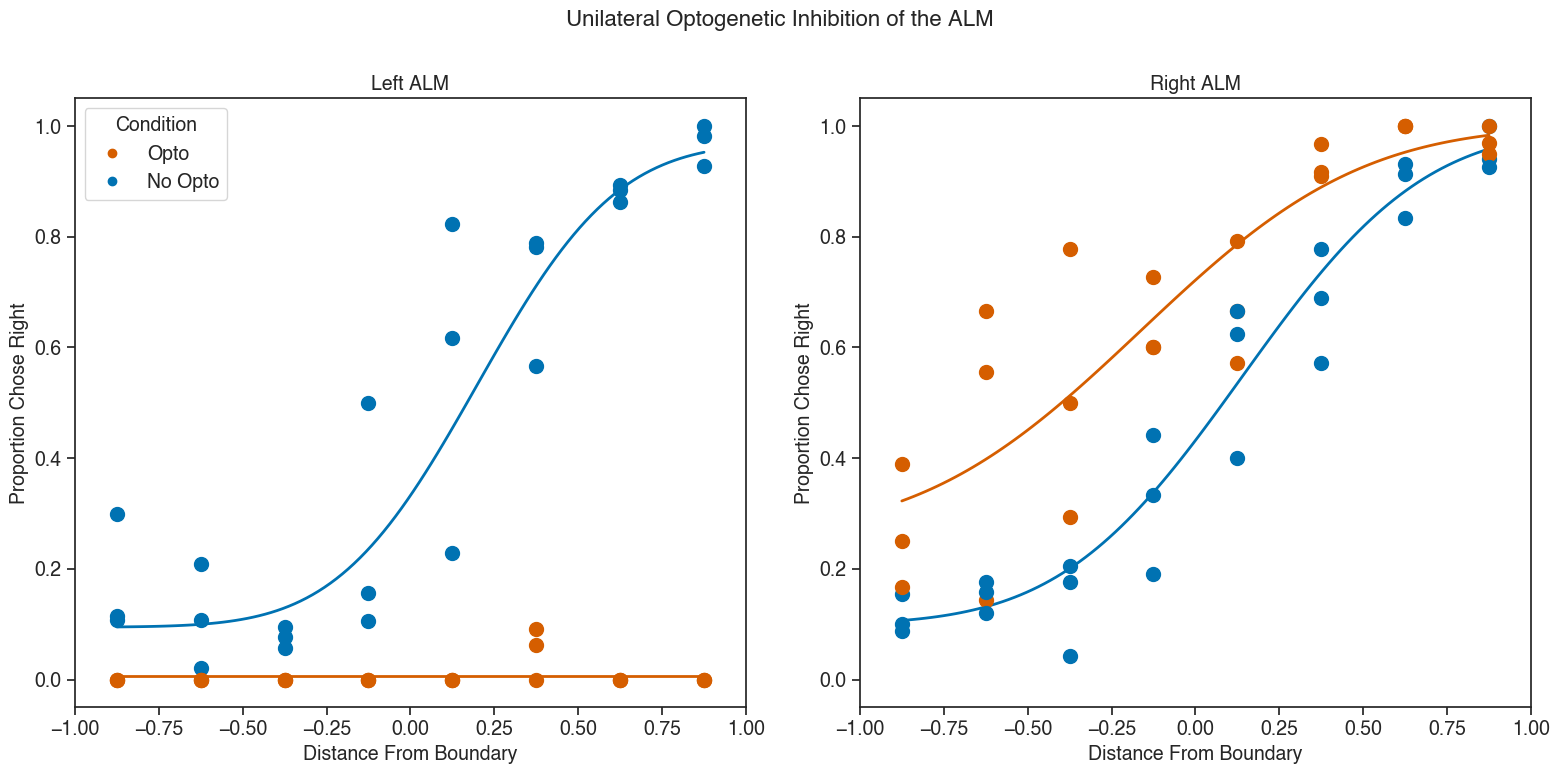

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# I assume that 'psycho_plot', 'opto_df', 'dates', 'alm_left_dates', 'alm_right_dates', 'color_dict', and 'marker_dict' 
# are defined in your previous code, as they are not provided here.

# Setup figure and axes grid
fig, axs = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# Plot for ALM-Left condition
alm_left_df = opto_df[opto_df['Date'].isin(alm_left_dates)]
for condition in alm_left_df['Zapit'].unique():
    condition_df = alm_left_df[alm_left_df['Zapit'] == condition]
    popt = ut.psycho_fit(condition_df)[0]
    psycho_plot(condition_df, popt, 
                label=None,  # Don't specify a label here
                color=color_dict[condition], 
                marker=marker_dict['alm_left'],
                ax=axs[0], scatter=False)  # Use the first subplot

# Plot the raw data for ALM-Left
for date in alm_left_dates:
    date_df = opto_df[opto_df['Date'] == date]
    for condition in date_df['Zapit'].unique():
        condition_df = date_df[date_df['Zapit'] == condition]
        choice_data = condition_df.groupby('stim_relative_binned')['choice'].agg(['mean', 'count', 'sem'])
        x_data = choice_data.index
        y_data = choice_data['mean'].values
        axs[0].errorbar(x_data, y_data, yerr=None,
                        fmt=marker_dict['alm_left'], markersize=10, color=color_dict[condition], linestyle='None')

axs[0].set_xlabel('Distance From Boundary')
axs[0].set_ylabel('Proportion Chose Right')
axs[0].set_title('Left ALM')
axs[0].set_xlim(-1, 1)
axs[0].set_ylim(-0.05, 1.05)

# Plot for ALM-Right condition
alm_right_df = opto_df[opto_df['Date'].isin(alm_right_dates)]
for condition in alm_right_df['Zapit'].unique():
    condition_df = alm_right_df[alm_right_df['Zapit'] == condition]
    popt = ut.psycho_fit(condition_df)[0]
    psycho_plot(condition_df, popt, 
                label=None,  # Don't specify a label here
                color=color_dict[condition], 
                marker=marker_dict['alm_right'],
                ax=axs[1], scatter=False)  # Use the second subplot

# Plot the raw data for ALM-Right
for date in alm_right_dates:
    date_df = opto_df[opto_df['Date'] == date]
    for condition in date_df['Zapit'].unique():
        condition_df = date_df[date_df['Zapit'] == condition]
        choice_data = condition_df.groupby('stim_relative_binned')['choice'].agg(['mean', 'count', 'sem'])
        x_data = choice_data.index
        y_data = choice_data['mean'].values
        axs[1].errorbar(x_data, y_data, yerr=None,
                        fmt=marker_dict['alm_right'], markersize=10, color=color_dict[condition], linestyle='None')

axs[1].set_xlabel('Distance From Boundary')
axs[1].set_ylabel('Proportion Chose Right')
axs[1].set_title('Right ALM')
axs[1].set_xlim(-1, 1)
axs[1].set_ylim(-0.05, 1.05)

# Super title for the entire figure
fig.suptitle('Unilateral Optogenetic Inhibition of the ALM', fontsize=16)

# remove all legends
axs[0].legend().remove()
axs[1].legend().remove()


# put a legend to explaun the colors
axs[0].legend(handles=legend_color, title='Condition', loc='upper left')

plt.tight_layout()
# save the figure
plt.savefig(figs_path + 'QP094_ALM_Opto_Split.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
opto_df_valid = opto_df[opto_df['No_response'] == False]
df_alm_left = opto_df_valid[opto_df_valid['Date'].isin(alm_left_dates)]
df_alm_right = opto_df_valid[opto_df_valid['Date'].isin(alm_right_dates)]

In [ ]:
# get the number of Zapit = True and Zapit = False trials
alm_left_n_opto = len(df_alm_left[df_alm_left['Zapit'] == True])
alm_left_n_no_opto = len(df_alm_left[df_alm_left['Zapit'] == False])

alm_right_n_opto = len(df_alm_right[df_alm_right['Zapit'] == True])
alm_right_n_no_opto = len(df_alm_right[df_alm_right['Zapit'] == False])

total_n_opto = alm_left_n_opto + alm_right_n_opto

print(f'ALM-Left: {alm_left_n_opto} opto trials, {alm_left_n_no_opto} no opto trials')
print(f'ALM-Right: {alm_right_n_opto} opto trials, {alm_right_n_no_opto} no opto trials')
print(f'Total: {total_n_opto} opto trials, {alm_left_n_no_opto + alm_right_n_no_opto} no opto trials')

ALM-Left: 376 opto trials, 869 no opto trials
ALM-Right: 410 opto trials, 687 no opto trials
Total: 786 opto trials, 1556 no opto trials


In [ ]:
df

Date Participant_ID   Protocol           Stage Trial  \
0       2023/09/26          QP093  SOUND_CAT  Full_Task_Cont     0   
1       2023/09/26          QP093  SOUND_CAT  Full_Task_Cont     1   
2       2023/09/26          QP093  SOUND_CAT  Full_Task_Cont     2   
3       2023/09/26          QP093  SOUND_CAT  Full_Task_Cont     3   
4       2023/09/26          QP093  SOUND_CAT  Full_Task_Cont     4   
...            ...            ...        ...             ...   ...   
233183  2023/11/04         QP0103  SOUND_CAT  Full_Task_Cont   599   
233184  2023/11/04         QP0103  SOUND_CAT  Full_Task_Cont   600   
233185  2023/11/04         QP0103  SOUND_CAT  Full_Task_Cont   601   
233186  2023/11/04         QP0103  SOUND_CAT  Full_Task_Cont   602   
233187  2023/11/04         QP0103  SOUND_CAT  Full_Task_Cont   603   

       Correct_Count    Sound_Contingency  Stim_Relative  correct No_response  \
0                  1  Low_Left_High_Right       0.046772      1.0       False   
1                  2  Low_Left_High_Right       0.182538      1.0       False   
2                  2  Low_Left_High_Right      -0.048634      0.0       False   
3                  2  Low_Left_High_Right      -0.558526      0.0       False   
4                  3  Low_Left_High_Right      -0.781096      1.0       False   
...              ...                  ...            ...      ...         ...   
233183           472  Low_Left_High_Right      -0.023959      0.0       False   
233184           473  Low_Left_High_Right      -0.815535      1.0       False   
233185           474  Low_Left_High_Right      -0.988108      1.0       False   
233186           474  Low_Left_High_Right       0.208504      0.0       False   
233187           475  Low_Left_High_Right       0.649911      1.0       False   

        ... Trial_End_Time                                            File_ID  \
0       ...   33240.432666  /Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...   
1       ...   33245.609600  /Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...   
2       ...   33251.475558  /Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...   
3       ...   33259.644301  /Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...   
4       ...   33262.661299  /Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...   
...     ...            ...                                                ...   
233183  ...   57457.789466  /Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...   
233184  ...   57460.166477  /Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...   
233185  ...   57464.180186  /Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...   
233186  ...   57471.520986  /Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...   
233187  ...   57473.907776  /Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...   

         Datetime  block Incorrect No_Response choice Rule_Right  \
0      2023-09-26      0         0           0    1.0          1   
1      2023-09-26      0         0           0    1.0          1   
2      2023-09-26      0         1           0    1.0          0   
3      2023-09-26      0         1           0    1.0          0   
4      2023-09-26      0         0           0    0.0          0   
...           ...    ...       ...         ...    ...        ...   
233183 2023-11-04     35         1           0    1.0          0   
233184 2023-11-04     35         0           0    0.0          0   
233185 2023-11-04     35         0           0    0.0          0   
233186 2023-11-04     35         1           0    0.0          1   
233187 2023-11-04     35         0           0    1.0          1   

       Choice_Rule_Diff stim_relative_binned  
0                   0.0                0.125  
1                   0.0                0.125  
2                   1.0               -0.125  
3                   1.0               -0.625  
4                   0.0               -0.875  
...                 ...                  ...  
233183              1.0               -0.125  
233184              0.0           

In [ ]:
# def plot_choice_scatter_V2(df, p_id, save_path, show_plot=True, jitter=0.025,
#                            title='Choice Scatter Plot'):
#     participant_df = df[df['Participant_ID'] == p_id]
#     participant_df = participant_df[participant_df['No_response'] == False]
    
#     with PdfPages(save_path) as pdf:
#         for block in participant_df['block'].unique():
#             block_df = participant_df[participant_df['block'] == block]
#             block_df = block_df[block_df['No_response'] == False].reset_index(drop=True)

#             fig, ax = plt.subplots(figsize=(18, 6))

#             ax.set_yticks([0, 1])
#             ax.set_yticklabels(['Left', 'Right'])
#             ax.set_ylim(-0.1, 1.1)
#             ax.set_xlabel('(Valid) Trial')
#             ax.set_ylabel('Choice')

#             for idx, row in block_df.iterrows():
#                 # Correct choices
#                 if row['correct']:
#                     color = 'green'
#                     if row['Zapit']:
#                         # Filled green circle for Zapit True
#                         ax.plot(idx, row['choice'] + np.random.uniform(-jitter, jitter), 'o', 
#                                 color=color, markersize=7, fillstyle='full')
#                     else:
#                         # Open green circle for Zapit False
#                         ax.plot(idx, row['choice'] + np.random.uniform(-jitter, jitter), 'o', 
#                                 color=color, markersize=7, fillstyle='none')
#                 # Incorrect choices
#                 else:
#                     color = 'red'
#                     if row['Zapit']:
#                         # Filled red triangle for Zapit True
#                         ax.plot(idx, row['choice'] + np.random.uniform(-jitter, jitter), '^', 
#                                 color=color, markersize=7, fillstyle='full')
#                     else:
#                         # Open red triangle for Zapit False
#                         ax.plot(idx, row['choice'] + np.random.uniform(-jitter, jitter), '^', 
#                                 color=color, markersize=7, fillstyle='none')

#             # Legend
#             custom_lines = [plt.Line2D([0], [0], marker='o', color='green', linestyle='None', markersize=7, fillstyle='full'),
#                             plt.Line2D([0], [0], marker='o', color='green', linestyle='None', markersize=7, fillstyle='none'),
#                             plt.Line2D([0], [0], marker='^', color='red', linestyle='None', markersize=7, fillstyle='full'),
#                             plt.Line2D([0], [0], marker='^', color='red', linestyle='None', markersize=7, fillstyle='none')]

#             ax.legend(custom_lines, ['Correct (Zapit On)', 'Correct (Zapit Off)',
#                                      'Incorrect (Zapit On)', 'Incorrect (Zapit Off)'],
#                       loc='lower left', bbox_to_anchor=(0, 0.2))

#             plt.title(title)
#             plt.tight_layout()
#             pdf.savefig()
#             if show_plot:
#                 plt.show()
#             else:
#                 plt.close()


# isolate data for QP094, Date = 2023-10-18
# subj = 'QP094'
# dates_to_keep = [
#                 '2023/10/20', 
#                  '2023/10/21', 
#                  '2023/10/22', 
#                  '2023/10/23', 
#                  '2023/10/24',
#                  '2023/11/02',
#                  ]
# opto_df = df[(df['Participant_ID'] == subj) & (df['Date'].isin(dates_to_keep))]
# plot_choice_scatter_V2(df = opto_df, p_id= 'QP094', save_path = figs_path + 'QP094_Choice_Scatter.pdf', 
#                        show_plot=True, jitter= 0.05, title = 'QP094 - Left ALM Stimulation')

TypeError: psycho_plot() got an unexpected keyword argument 'marker'

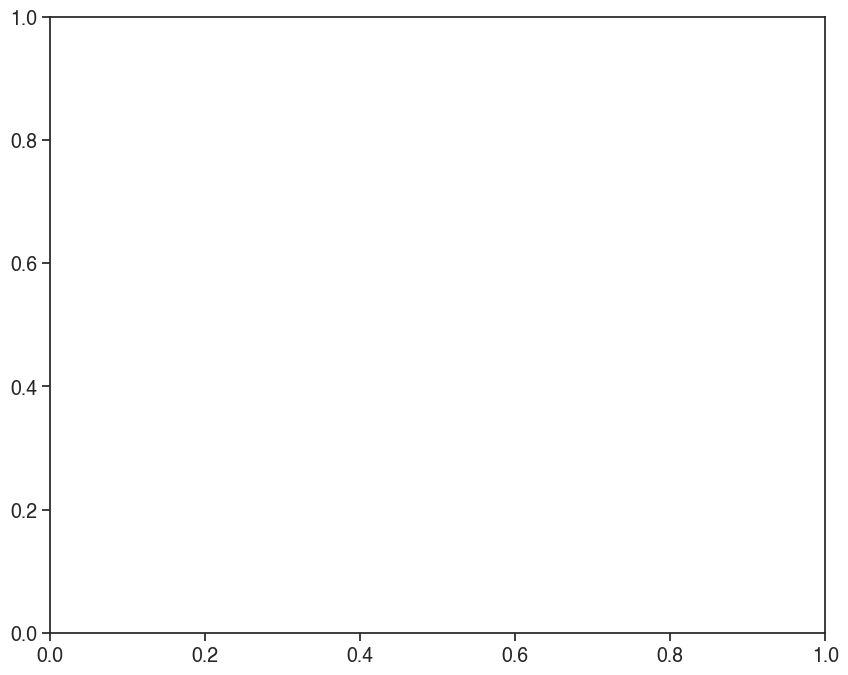

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `ut.psycho_fit` and `ut.psycho_plot` are utility functions available in your workspace

# ... [your existing code to create `opto_df`] ...

# Define color and linestyle mappings
color_dict = {True: '#D55E00', False: '#0072B2'}  # Orange for True (opto), Blue for False (no opto)
linestyle_dict = {'alm_left': '-', 'alm_right': '--'}  # Solid line for left, dashed for right
marker_dict = {True: 'o', False: 'X'}  # Circle for True (opto), X for False (no opto)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot psychometric curves for each condition and side
for side, dates in zip(['alm_left', 'alm_right'], [alm_left_dates, alm_right_dates]):
    side_df = opto_df[opto_df['Date'].isin(dates)]
    for condition in side_df['Zapit'].unique():
        condition_df = side_df[side_df['Zapit'] == condition]
        popt = ut.psycho_fit(condition_df)[0]
        psycho_plot(condition_df, popt, 
                       label=f"{side.split('_')[1].capitalize()} ALM, {'Opto' if condition else 'No Opto'}",
                       color=color_dict[condition], 
                       linestyle=linestyle_dict[side],
                       marker=marker_dict[condition],
                       ax=ax)

ax.set_xlabel('Stimulus Relative Binned')
ax.set_ylabel('Choice Proportion')
ax.set_title(f'Psychometric Curves for {subj}')

# Create custom legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color_dict[False], linestyle='-', marker='X'),
                Line2D([0], [0], color=color_dict[False], linestyle='--', marker='X'),
                Line2D([0], [0], color=color_dict[True], linestyle='-', marker='o'),
                Line2D([0], [0], color=color_dict[True], linestyle='--', marker='o')]

ax.legend(custom_lines, ['Left ALM, No Opto', 'Right ALM, No Opto',
                         'Left ALM, Opto', 'Right ALM, Opto'])

plt.tight_layout()

# If you have a path to save the figure, uncomment the next line
# plt.savefig(f'{figs_path}/ACC_PPC_Psychometrics_{subj}.png', dpi=300, bbox_inches='tight')

plt.show()


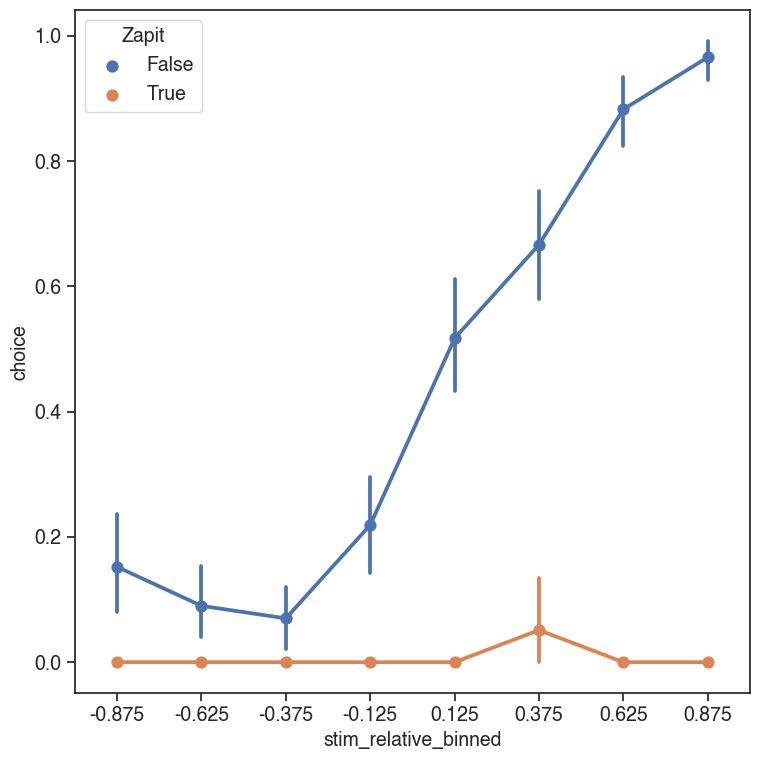

In [ ]:
# isolate data for QP094, Date = 2023-10-18
subj = 'QP094'
dates_to_keep = ['2023/10/20', 
                #  '2023/10/21', 
                 '2023/10/22', 
                #  '2023/10/23', 
                 '2023/10/24']
opto_df = df[(df['Participant_ID'] == subj) & (df['Date'].isin(dates_to_keep))]

fig, ax = plt.subplots(figsize=(8,8))
# plot choice Vs stim_relative_binned for each participant
sns.pointplot(x='stim_relative_binned', y='choice', data=opto_df, 
              hue = 'Zapit',
                ci = 95)

plt.tight_layout()
# save the figure
# fig.savefig(figs_path + 'ACC_PPC_Psychometrics.pdf', dpi=300, bbox_inches='tight')
plt.show()

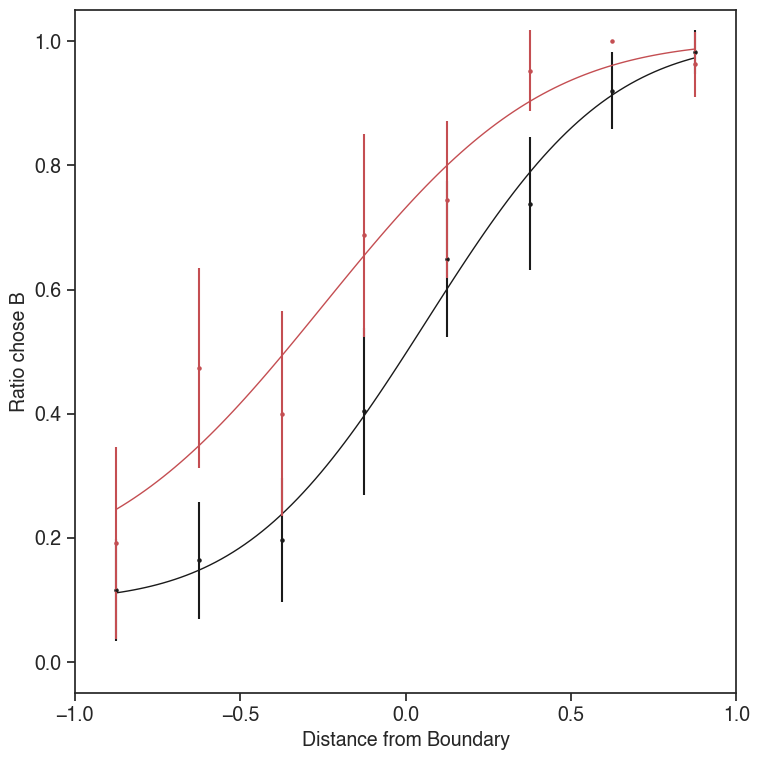

In [ ]:
# isolate data for QP094, Date = 2023-10-18
subj = 'QP094'
dates_to_keep = [
                 '2023/10/20', 
                 '2023/10/21', 
                 '2023/10/22', 
                 '2023/10/23', 
                 '2023/10/24'
                 ]
opto_df = df[(df['Participant_ID'] == subj) & (df['Date'].isin(dates_to_keep))]

fig, ax = plt.subplots(figsize=(8,8))
# plot choice Vs stim_relative_binned for each participant
# sns.pointplot(x='stim_relative_binned', y='choice', data=opto_df, 
#               hue = 'Zapit',
#                 ci = 95)
color_dict = {False: 'k',  True: 'r'}
for condition in opto_df.Zapit.unique():
    condition_df = opto_df[opto_df['Zapit'] == condition]
    popt = ut.psycho_fit(condition_df)[0]
    ut.psycho_plot(condition_df, popt, label=None, color=color_dict[condition], ax=ax, legend=False)

plt.tight_layout()
# save the figure
# fig.savefig(figs_path + 'ACC_PPC_Psychometrics.pdf', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_53685/422912748.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_df['Group'] = 'Unilateral_Left'


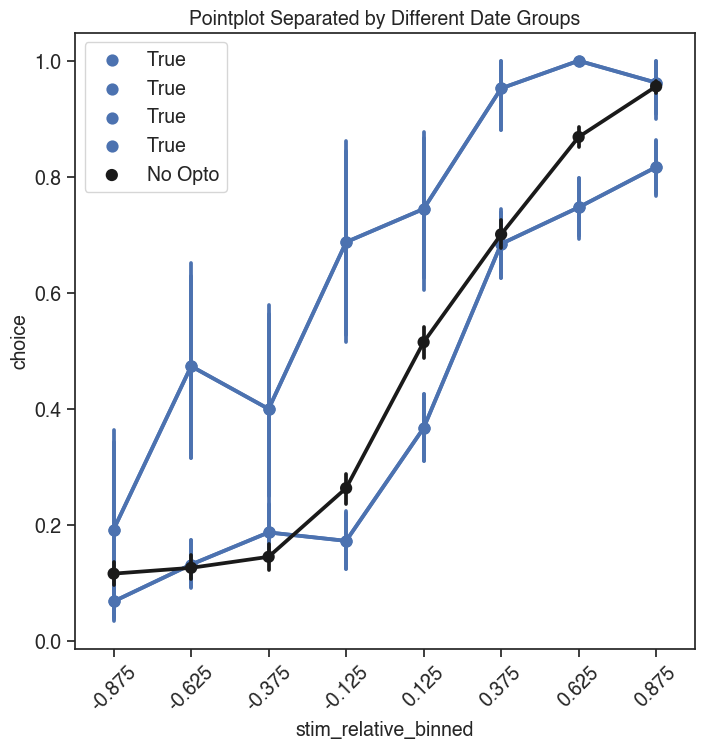

In [ ]:
unilateral_left_dates = ['2023/10/20', '2023/10/22', '2023/10/24']
unilateral_right_dates = ['2023/10/21', '2023/10/23']

subj_df = df[df['Participant_ID'] == 'QP094']
# Create a new column to categorize the dates
subj_df['Group'] = 'Unilateral_Left'
subj_df.loc[subj_df['Date'].isin(unilateral_left_dates), 'Group'] = 'Unilateral_Left'
subj_df.loc[subj_df['Date'].isin(unilateral_right_dates), 'Group'] = 'Unilateral_Right'

# Create a pointplot using Seaborn
plt.figure(figsize=(8, 8))
# sns.pointplot(data=subj_df, x='stim_relative_binned', y='choice', hue='Group', ci=None)
opto_on_df = subj_df[subj_df['Zapit'] == True]
for group in opto_on_df['Group'].unique():
    group_df = opto_on_df[(opto_on_df['Group'] == group) & (opto_on_df['Zapit'] == True)]
    sns.pointplot(data=group_df, x='stim_relative_binned', y='choice', ci=95, label=group, hue='Zapit', palette=['b', 'r'])
    sns.pointplot(data=group_df, x='stim_relative_binned', y='choice', ci=95, label=group, hue='Zapit')
opto_off_df = subj_df[subj_df['Zapit'] == False]
sns.pointplot(data=opto_off_df, x='stim_relative_binned', y='choice', ci=95, label='No Opto', color='k')
plt.xticks(rotation=45)
plt.legend()
plt.title('Pointplot Separated by Different Date Groups')
plt.show()

/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_63616/4084589342.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_df['Group'] = 'ALM_Unilateral_Left'


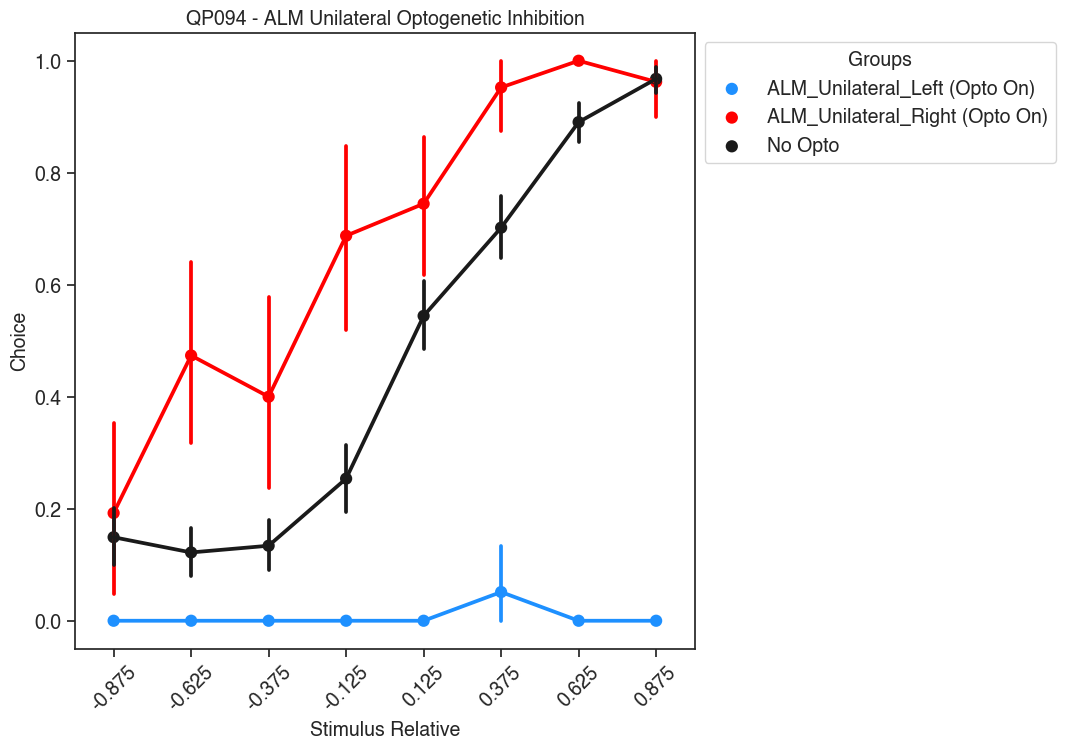

In [ ]:
plt.figure(figsize=(8, 8))

unilateral_left_dates = ['2023/10/20', '2023/10/22']
unilateral_right_dates = ['2023/10/21', '2023/10/23']

# Create a new column to categorize the dates
subj_df['Group'] = 'ALM_Unilateral_Left'
subj_df.loc[subj_df['Date'].isin(unilateral_left_dates), 'Group'] = 'ALM_Unilateral_Left'
subj_df.loc[subj_df['Date'].isin(unilateral_right_dates), 'Group'] = 'ALM_Unilateral_Right'

# Define your color mapping here
color_mapping = {
    'ALM_Unilateral_Left': 'dodgerblue',
    'ALM_Unilateral_Right': 'red'
}
# Loop through the groups and plot the points
opto_on_df = subj_df[subj_df.Zapit == True]
for group in opto_on_df['Group'].unique():
    group_df = opto_on_df[opto_on_df['Group'] == group]
    sns.pointplot(data=group_df, x='stim_relative_binned', y='choice', ci=95, label=f'{group} (Opto On)', color=color_mapping[group])

# i need two different shades of black
color_mapping = {
    'ALM_Unilateral_Left': 'darkblue',
    'ALM_Unilateral_Right': 'darkred'
}

# Loop through the groups and plot the points for Opto Off
opto_off_df = subj_df[subj_df.Zapit == False]
for group in opto_off_df['Group'].unique():
    group_df = opto_off_df[opto_off_df['Group'] == group]
    # sns.pointplot(data=group_df, x='stim_relative_binned', y='choice', ci=95, label=f'{group} (Opto Off)', color=color_mapping[group])


sns.pointplot(data=opto_off_df, x='stim_relative_binned', y='choice', ci=95, label='No Opto', color='k')

plt.xticks(rotation=45)

# Create a custom legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Groups', loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Stimulus Relative')
plt.ylabel('Choice')
plt.title(subj + ' - ALM Unilateral Optogenetic Inhibition')
plt.show()


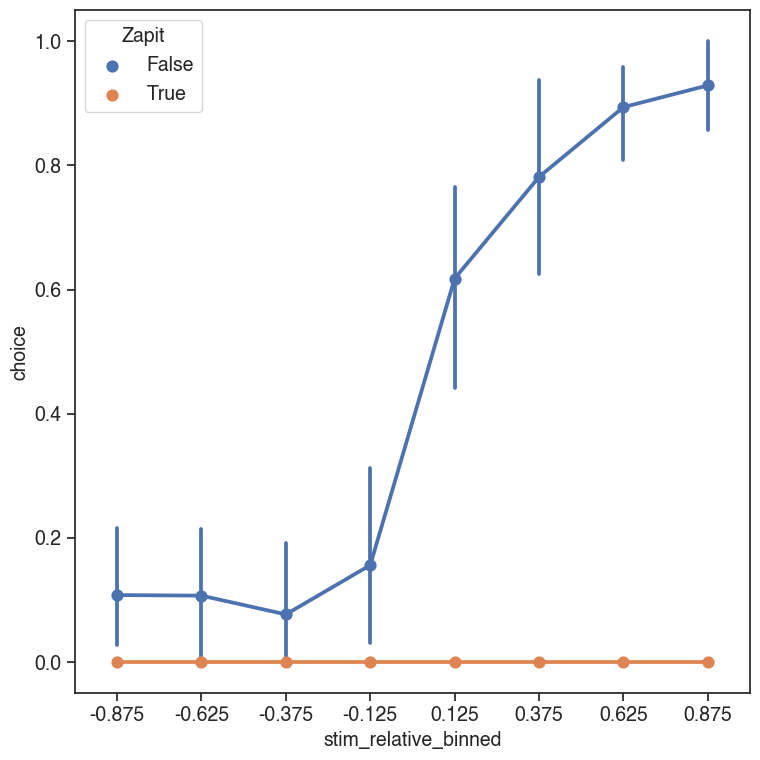

In [ ]:
subj = 'QP094'
date = datetime.datetime(2023, 10, 24)
date_df = df[df['Datetime'] == date]

subj_df = date_df[date_df['Participant_ID'] == subj]
subj_df = subj_df[subj_df.No_response == False].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,8))

# plot choice Vs stim_relative_binned for each participant
sns.pointplot(x='stim_relative_binned', y='choice', data=subj_df, 
              hue = 'Zapit',
            #   hue = 'Sound_Duration', palette = color_dict, 
            # color = 'k',
                ci = 95)


plt.tight_layout()
# save the figure
# fig.savefig(figs_path + 'ACC_PPC_Psychometrics.pdf', dpi=300, bbox_inches='tight')
plt.show()

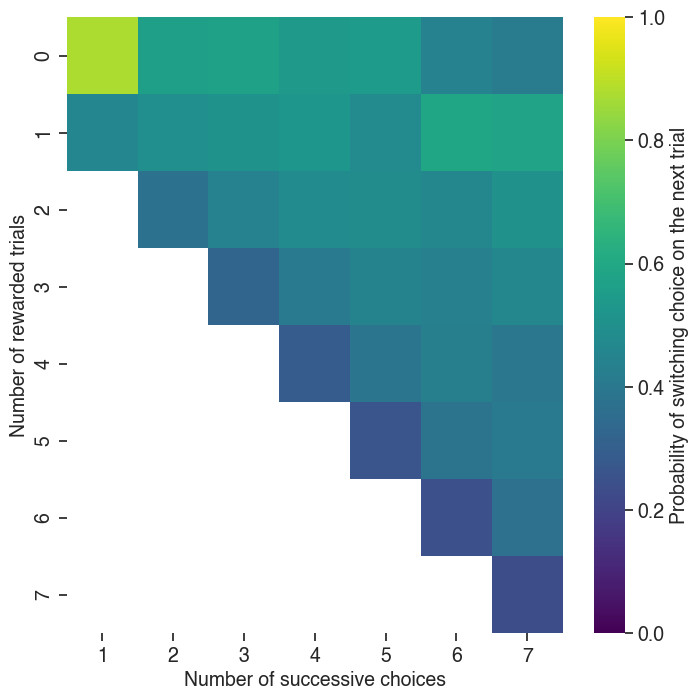

## GLM - Trial History

### Test with data from QP094

In [ ]:
# isolate data for QP094, with Anti_Bias = False
subj = 'QP094'
date_thresh = datetime.datetime(2023, 10, 20)
date_df = df[df['Datetime'] > date_thresh]
sub_df = date_df[(date_df['Participant_ID'] == subj) & (date_df['Datetime'] > date_thresh)]
sub_df = sub_df[sub_df.Opto_On == False].reset_index(drop=True)
sub_df = sub_df.groupby('Participant_ID').apply(add_previous_n_trials_data)
columns_to_keep = ['Date', 'Participant_ID','Trial', 'Stim_Relative', 'correct', 'No_response',
                   'First_Lick', 'P_Right','Response_Latency', 'Trial_Outcome', 
                   'Anti_Bias','Timeout_Duration', 'Emulator', 'Distribution','Datetime',
                   'block', 'Incorrect', 'No_Response', 'choice', 'Rule_Right',
                   'Choice_Rule_Diff', 'stim_relative_binned', 'stim_relative_1',
                   'choice_1', 'correct_1', 'stim_relative_2', 'choice_2', 'correct_2',
                     'stim_relative_3', 'choice_3', 'correct_3', 'stim_relative_4',
                        'choice_4', 'correct_4', 'stim_relative_5', 'choice_5', 'correct_5']
sub_df = sub_df[columns_to_keep]

In [ ]:
# add rewarded and unrewarded choice columns
for i in range(1, 6):
    sub_df[f'Rewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 1), 1, 
                                          np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 0), -1, 0))
    sub_df[f'Unrewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 1), 1, 
                                            np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 0), -1, 0))

In [ ]:
sub_df = sub_df[sub_df.No_response == False].reset_index(drop=True)
# drop any rows where choice_1, stim_relative_1, stim_relative_binned or choice is nan
sub_df = sub_df.dropna(subset=["stim_relative_binned", "stim_relative_1", "stim_relative_2", "stim_relative_3", "stim_relative_4", "stim_relative_5",
            "Rewarded_Choice_1", "Rewarded_Choice_2", "Rewarded_Choice_3", "Rewarded_Choice_4", "Rewarded_Choice_5",
            "Unrewarded_Choice_1", "Unrewarded_Choice_2", "Unrewarded_Choice_3", "Unrewarded_Choice_4", "Unrewarded_Choice_5", "choice"]).reset_index(drop=True)

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Assuming you have your data loaded into a DataFrame called 'sub_df'

# Feature selection
# Feature selection and data split
X = sub_df[[
            "Stim_Relative", 
            "stim_relative_1", "stim_relative_2", "stim_relative_3", "stim_relative_4", "stim_relative_5",
            "Rewarded_Choice_1", "Rewarded_Choice_2", "Rewarded_Choice_3", "Rewarded_Choice_4", "Rewarded_Choice_5",
            "Unrewarded_Choice_1", "Unrewarded_Choice_2", "Unrewarded_Choice_3", "Unrewarded_Choice_4", "Unrewarded_Choice_5"
            ]] 
y = sub_df['choice']

# Create a logistic regression model
# logistic = LogisticRegression()
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)

# Perform k-fold cross-validation (e.g., k=5)
k_fold = 5
cv_scores = cross_val_score(log_reg_l1, X, y, cv=k_fold, scoring='accuracy')  # You can change the scoring metric as needed

# Print the cross-validation scores
print(f"{k_fold}-Fold Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))


5-Fold Cross-Validation Scores: [0.8125     0.84027778 0.8125     0.84320557 0.8466899 ]
Mean Accuracy: 0.8310346496322106


In [ ]:
# Get the coefficients
coefficients = log_reg_l1.coef_[0]
intercept = log_reg_l1.intercept_[0]

In [ ]:
# Number of bootstrap samples to generate
bootstrap_samples = 100

# Number of folds for cross-validation
k = 5

# Initialize an array to store the coefficients for each bootstrap sample and fold
coefficients = np.zeros((bootstrap_samples, k, X.shape[1]))

# Initialize an array to store the accuracy for each bootstrap sample and fold
accuracies = np.zeros((bootstrap_samples, k))

# Create a KFold object for k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Perform bootstrap sampling
for i in range(bootstrap_samples):
    # Resample the data with replacement
    X_bootstrap, y_bootstrap = resample(X, y, replace=True)
    
    # Perform k-fold cross-validation
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_bootstrap)):
        # Split the data into training and testing sets for this fold
        X_train, X_test = X_bootstrap.iloc[train_index], X_bootstrap.iloc[test_index]
        y_train, y_test = y_bootstrap.iloc[train_index], y_bootstrap.iloc[test_index]
        
        # Initialize the Logistic Regression model with L1 penalty
        model = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
        
        # Train the model on the training data
        model.fit(X_train, y_train)
        
        # Store the coefficients from this fold
        coefficients[i, fold_idx, :] = model.coef_
        
        # Make predictions on the testing data
        y_pred = model.predict(X_test)
        
        # Calculate the accuracy for this fold and store it
        accuracies[i, fold_idx] = accuracy_score(y_test, y_pred)


# Calculate the mean of the coefficients across all folds for each bootstrap sample
coefficients_bootstrap_mean = np.mean(coefficients, axis=1)

# Then calculate the mean of these 1000 averages
coefficients_mean = np.mean(coefficients_bootstrap_mean, axis=0)

# Calculate the 2.5th and 97.5th percentiles of the coefficients
# to get the 95% confidence intervals across all bootstrap samples and folds
conf_int_low = np.percentile(coefficients, 2.5, axis=(0, 1))
conf_int_high = np.percentile(coefficients, 97.5, axis=(0, 1))

# Calculate the average accuracy across all bootstrap samples and folds
average_accuracy = np.mean(accuracies)

# Store regressors, coefficients, confidence intervals, and accuracy in a dataframe
coef_df = pd.DataFrame({
    'Regressor': X.columns, 
    'Coefficient': coefficients_mean, 
    'Conf_Int_Low': conf_int_low, 
    'Conf_Int_High': conf_int_high,
    'Accuracy': average_accuracy  # Storing the average accuracy
})

# Rename 'Stim_Relative' to 'stim_relative_0' in the 'Regressor' column
coef_df['Regressor'] = coef_df['Regressor'].replace('Stim_Relative', 'stim_relative_0')


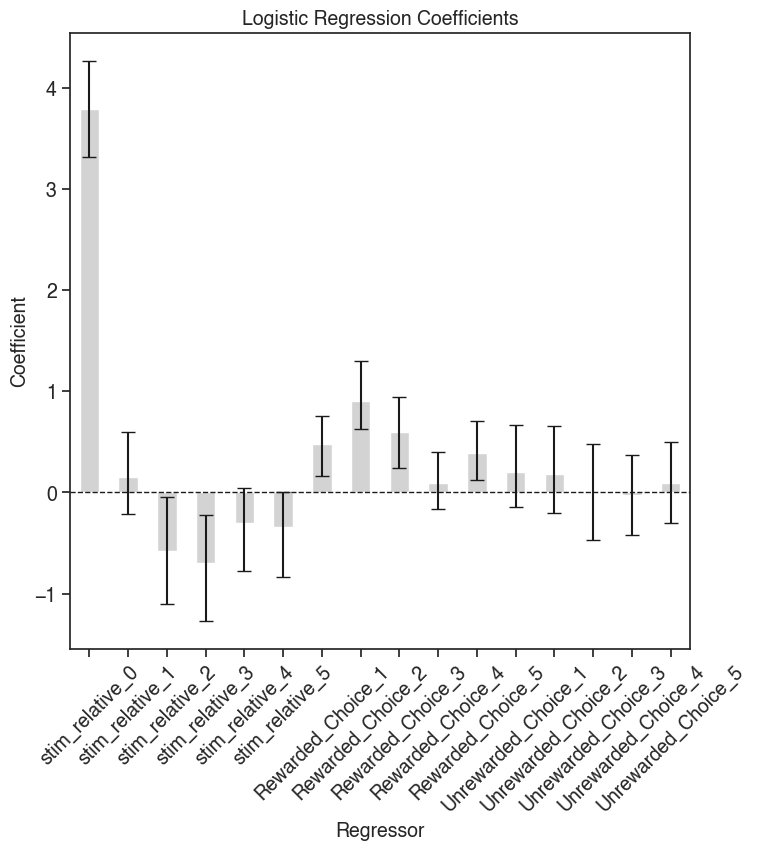

In [ ]:
# plot the coefficients Vs the regressors, with the confidence intervals
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the coefficients
coef_df.plot(x='Regressor', y='Coefficient', kind='bar', ax=ax, color='lightgray', legend=False)

# Plot the confidence intervals
plt.errorbar(x=np.arange(len(coef_df)), y=coef_df['Coefficient'],
                yerr=[coef_df['Coefficient'] - coef_df['Conf_Int_Low'], coef_df['Conf_Int_High'] - coef_df['Coefficient']],
                fmt='none', ecolor='k', capsize=5)

# Add a horizontal line at y=0
ax.axhline(y=0, linestyle='--', color='k', linewidth=1)

# Set the x-axis tick labels to be the regressors
ax.set_xticklabels(coef_df['Regressor'], rotation=45)

# Set the y-axis label
ax.set_ylabel('Coefficient')

# Set the title
ax.set_title('Logistic Regression Coefficients')

# Show the plot
plt.show()

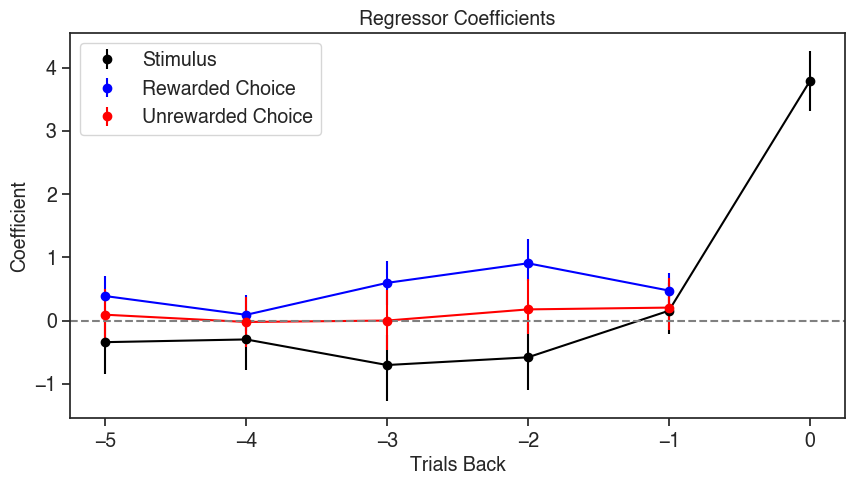

In [ ]:
# Separating the data based on categories
stim_data = coef_df[coef_df['Regressor'].str.contains('stim')]
rewarded_data = coef_df[coef_df['Regressor'].str.contains('Rewarded')]
unrewarded_data = coef_df[coef_df['Regressor'].str.contains('Unrewarded')]

# Mapping x-axis values
trial_numbers = np.arange(0, -6, -1)

plt.figure(figsize=(10, 5))

# Stimulus data
plt.errorbar(trial_numbers[:6], stim_data['Coefficient'], 
             yerr=[stim_data['Coefficient'] - stim_data['Conf_Int_Low'], stim_data['Conf_Int_High'] - stim_data['Coefficient']], 
             fmt='o', color='black', label='Stimulus')
plt.plot(trial_numbers[:6], stim_data['Coefficient'], color='black')

# Rewarded Choices
plt.errorbar(trial_numbers[1:], rewarded_data['Coefficient'], 
             yerr=[rewarded_data['Coefficient'] - rewarded_data['Conf_Int_Low'], rewarded_data['Conf_Int_High'] - rewarded_data['Coefficient']], 
             fmt='o', color='blue', label='Rewarded Choice')
plt.plot(trial_numbers[1:], rewarded_data['Coefficient'], color='blue')

# Unrewarded Choices
plt.errorbar(trial_numbers[1:], unrewarded_data['Coefficient'], 
             yerr=[unrewarded_data['Coefficient'] - unrewarded_data['Conf_Int_Low'], unrewarded_data['Conf_Int_High'] - unrewarded_data['Coefficient']], 
             fmt='o', color='red', label='Unrewarded Choice')
plt.plot(trial_numbers[1:], unrewarded_data['Coefficient'], color='red')

# Adding labels and title
plt.xlabel('Trials Back')
plt.ylabel('Coefficient')
plt.title('Regressor Coefficients')
plt.axhline(0, color='grey', linestyle='--')
plt.legend()
plt.tight_layout()
# save as pdf in the figures folder
plt.show()


In [ ]:
trial_numbers[:6], stim_data['Coefficient']

(array([ 0, -1, -2, -3, -4, -5]),
 0    3.636135
 Name: Coefficient, dtype: float64)

## PPC Bilateral Inactivation, QP094

In [ ]:
# isolate data for QP094, with Anti_Bias = False
subj = 'QP094'
dates_to_keep = ['2023/10/26', '2023/10/27', '2023/10/28', '2023/10/29',  '2023/10/30', '2023/10/31']
                 
date_df = df[df['Date'].isin(dates_to_keep)]
sub_df = date_df[(date_df['Participant_ID'] == subj)]
sub_df = sub_df.groupby('Participant_ID').apply(add_previous_n_trials_data)
columns_to_keep = ['Date', 'Participant_ID','Trial', 'Stim_Relative', 'correct', 'No_response',
                   'First_Lick', 'P_Right','Response_Latency', 'Trial_Outcome', 
                   'Anti_Bias','Timeout_Duration', 'Emulator', 'Distribution','Datetime',
                   'block', 'Incorrect', 'No_Response', 'choice', 'Rule_Right',
                   'Choice_Rule_Diff', 'stim_relative_binned', 'stim_relative_1',
                   'choice_1', 'correct_1', 'stim_relative_2', 'choice_2', 'correct_2',
                     'stim_relative_3', 'choice_3', 'correct_3', 'stim_relative_4',
                        'choice_4', 'correct_4', 'stim_relative_5', 'choice_5', 'correct_5']
# sub_df = sub_df[columns_to_keep]
sub_df = sub_df[sub_df.No_response == False].reset_index(drop=True)

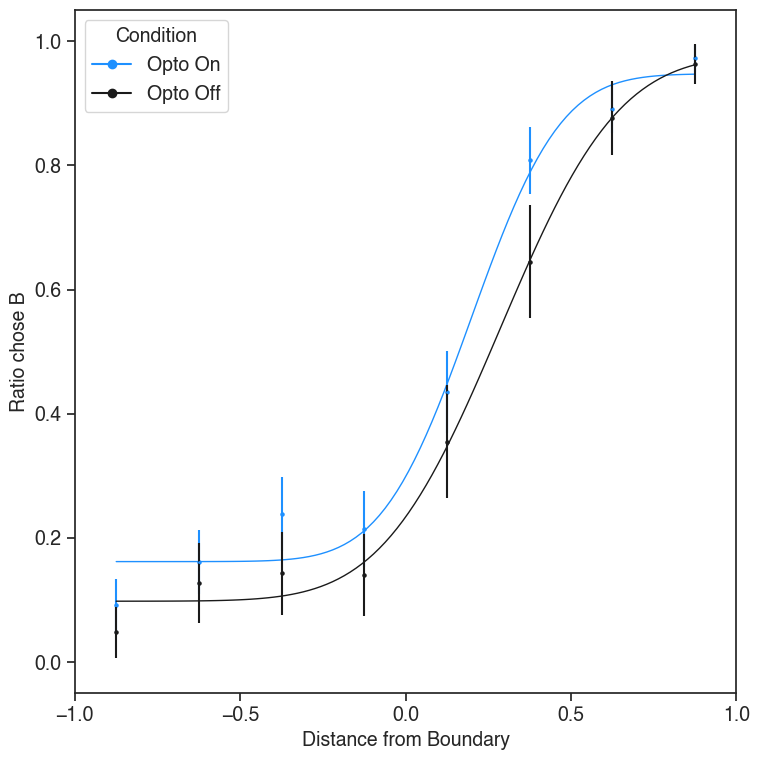

In [ ]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(8,8))
color_dict = {True: 'dodgerblue', False: 'k'}
legend_labels = {True: 'Opto On', False: 'Opto Off'}
legend_lines = []

for group in sub_df['Zapit'].unique():
    group_df = sub_df[sub_df['Zapit'] == group]
    popt, pcov = ut.psycho_fit(group_df)
    ut.psycho_plot(df=group_df, popt=popt, label=group, color=color_dict[group], ax=ax)
    
    # Create a line object for the legend with a custom label
    line = mlines.Line2D([], [], color=color_dict[group], marker='o', linestyle='-', label=legend_labels[group])
    legend_lines.append(line)

# Add custom lines to the legend
ax.legend(handles=legend_lines, title='Condition')
plt.tight_layout()
# save the figure
fig.savefig(figs_path + 'QP094_PPC_Opto_Psychometrics.pdf', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# add rewarded and unrewarded choice columns
for i in range(1, 6):
    sub_df[f'Rewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 1), 1, 
                                          np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 0), -1, 0))
    sub_df[f'Unrewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 1), 1, 
                                            np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 0), -1, 0))

### GLM - Opto On Vs Opto Off

In [ ]:
sub_df = sub_df[sub_df.No_response == False].reset_index(drop=True)
# drop any rows where choice_1, stim_relative_1, stim_relative_binned or choice is nan
sub_df = sub_df.dropna(subset=["stim_relative_binned", "stim_relative_1", "stim_relative_2", "stim_relative_3", "stim_relative_4", "stim_relative_5",
            "Rewarded_Choice_1", "Rewarded_Choice_2", "Rewarded_Choice_3", "Rewarded_Choice_4", "Rewarded_Choice_5",
            "Unrewarded_Choice_1", "Unrewarded_Choice_2", "Unrewarded_Choice_3", "Unrewarded_Choice_4", "Unrewarded_Choice_5", "choice"]).reset_index(drop=True)

In [ ]:
opto_off_df = sub_df[sub_df['Zapit'] == False]

In [ ]:
# Feature selection and data split
X = opto_off_df[[
            "Stim_Relative", 
            "stim_relative_1", "stim_relative_2", "stim_relative_3", "stim_relative_4", "stim_relative_5",
            "Rewarded_Choice_1", "Rewarded_Choice_2", "Rewarded_Choice_3", "Rewarded_Choice_4", "Rewarded_Choice_5",
            "Unrewarded_Choice_1", "Unrewarded_Choice_2", "Unrewarded_Choice_3", "Unrewarded_Choice_4", "Unrewarded_Choice_5"
            ]] 
y = opto_off_df['choice']

# Create a logistic regression model
# logistic = LogisticRegression()
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)

# Perform k-fold cross-validation (e.g., k=5)
k_fold = 5
cv_scores = cross_val_score(log_reg_l1, X, y, cv=k_fold, scoring='accuracy')  # You can change the scoring metric as needed

# Print the cross-validation scores
print(f"{k_fold}-Fold Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

5-Fold Cross-Validation Scores: [0.81460674 0.82022472 0.83050847 0.8700565  0.83050847]
Mean Accuracy: 0.833180981400368


In [ ]:
# Number of bootstrap samples to generate
bootstrap_samples = 100

# Number of folds for cross-validation
k = 5

# Initialize an array to store the coefficients for each bootstrap sample and fold
coefficients = np.zeros((bootstrap_samples, k, X.shape[1]))

# Initialize an array to store the accuracy for each bootstrap sample and fold
accuracies = np.zeros((bootstrap_samples, k))

# Create a KFold object for k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Perform bootstrap sampling
for i in range(bootstrap_samples):
    # Resample the data with replacement
    X_bootstrap, y_bootstrap = resample(X, y, replace=True)
    
    # Perform k-fold cross-validation
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_bootstrap)):
        # Split the data into training and testing sets for this fold
        X_train, X_test = X_bootstrap.iloc[train_index], X_bootstrap.iloc[test_index]
        y_train, y_test = y_bootstrap.iloc[train_index], y_bootstrap.iloc[test_index]
        
        # Initialize the Logistic Regression model with L1 penalty
        model = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
        
        # Train the model on the training data
        model.fit(X_train, y_train)
        
        # Store the coefficients from this fold
        coefficients[i, fold_idx, :] = model.coef_
        
        # Make predictions on the testing data
        y_pred = model.predict(X_test)
        
        # Calculate the accuracy for this fold and store it
        accuracies[i, fold_idx] = accuracy_score(y_test, y_pred)


# Calculate the mean of the coefficients across all folds for each bootstrap sample
coefficients_bootstrap_mean = np.mean(coefficients, axis=1)

# Then calculate the mean of these 1000 averages
coefficients_mean = np.mean(coefficients_bootstrap_mean, axis=0)

# Calculate the 2.5th and 97.5th percentiles of the coefficients
# to get the 95% confidence intervals across all bootstrap samples and folds
conf_int_low = np.percentile(coefficients, 2.5, axis=(0, 1))
conf_int_high = np.percentile(coefficients, 97.5, axis=(0, 1))

# Calculate the average accuracy across all bootstrap samples and folds
average_accuracy = np.mean(accuracies)

# Store regressors, coefficients, confidence intervals, and accuracy in a dataframe
coef_df_opto_off = pd.DataFrame({
    'Regressor': X.columns, 
    'Coefficient': coefficients_mean, 
    'Conf_Int_Low': conf_int_low, 
    'Conf_Int_High': conf_int_high,
    'Accuracy': average_accuracy  # Storing the average accuracy
})

# Rename 'Stim_Relative' to 'stim_relative_0' in the 'Regressor' column
coef_df_opto_off['Regressor'] = coef_df_opto_off['Regressor'].replace('Stim_Relative', 'stim_relative_0')

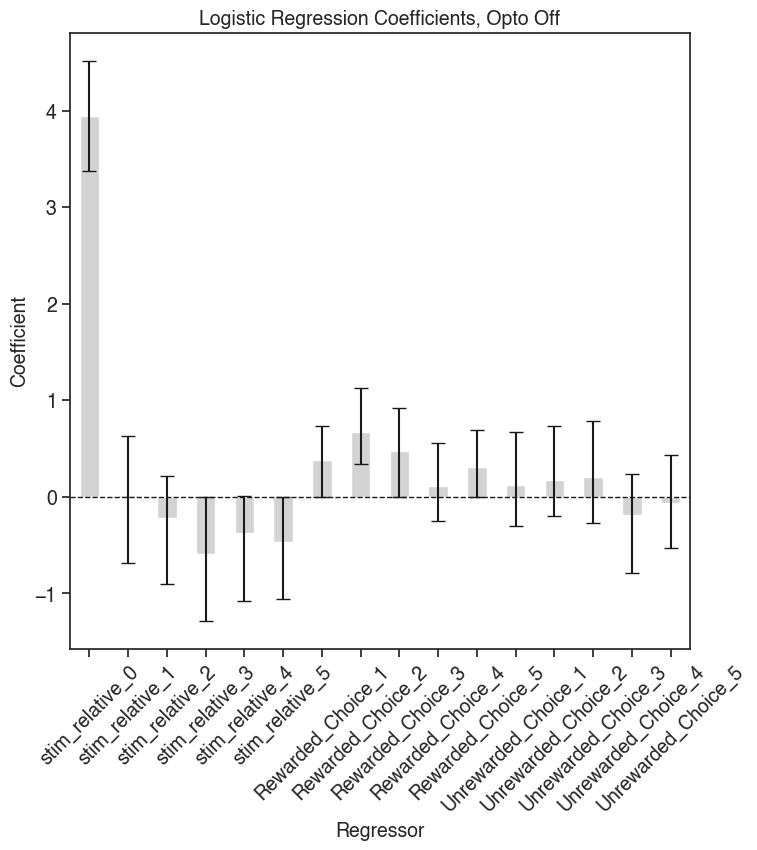

In [ ]:
# plot the coefficients Vs the regressors, with the confidence intervals
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the coefficients
coef_df_opto_off.plot(x='Regressor', y='Coefficient', kind='bar', ax=ax, color='lightgray', legend=False)

# Plot the confidence intervals
plt.errorbar(x=np.arange(len(coef_df_opto_off)), y=coef_df_opto_off['Coefficient'],
                yerr=[coef_df_opto_off['Coefficient'] - coef_df_opto_off['Conf_Int_Low'], coef_df_opto_off['Conf_Int_High'] - coef_df_opto_off['Coefficient']],
                fmt='none', ecolor='k', capsize=5)

# Add a horizontal line at y=0
ax.axhline(y=0, linestyle='--', color='k', linewidth=1)

# Set the x-axis tick labels to be the regressors
ax.set_xticklabels(coef_df_opto_off['Regressor'], rotation=45)

# Set the y-axis label
ax.set_ylabel('Coefficient')

# Set the title
ax.set_title('Logistic Regression Coefficients, Opto Off')

# Show the plot
plt.show()

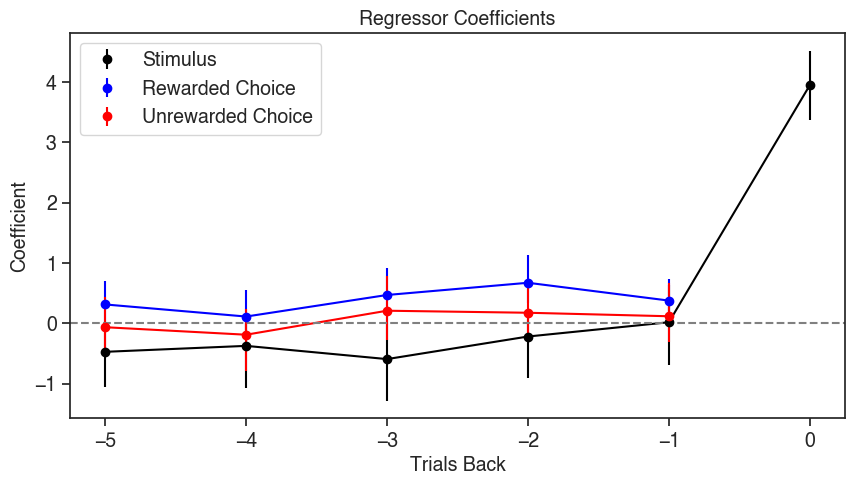

In [ ]:
# Separating the data based on categories
stim_data = coef_df_opto_off[coef_df_opto_off['Regressor'].str.contains('stim')]
rewarded_data = coef_df_opto_off[coef_df_opto_off['Regressor'].str.contains('Rewarded')]
unrewarded_data = coef_df_opto_off[coef_df_opto_off['Regressor'].str.contains('Unrewarded')]

# Mapping x-axis values
trial_numbers = np.arange(0, -6, -1)

plt.figure(figsize=(10, 5))

# Stimulus data
plt.errorbar(trial_numbers[:6], stim_data['Coefficient'], 
             yerr=[stim_data['Coefficient'] - stim_data['Conf_Int_Low'], stim_data['Conf_Int_High'] - stim_data['Coefficient']], 
             fmt='o', color='black', label='Stimulus')
plt.plot(trial_numbers[:6], stim_data['Coefficient'], color='black')

# Rewarded Choices
plt.errorbar(trial_numbers[1:], rewarded_data['Coefficient'], 
             yerr=[rewarded_data['Coefficient'] - rewarded_data['Conf_Int_Low'], rewarded_data['Conf_Int_High'] - rewarded_data['Coefficient']], 
             fmt='o', color='blue', label='Rewarded Choice')
plt.plot(trial_numbers[1:], rewarded_data['Coefficient'], color='blue')

# Unrewarded Choices
plt.errorbar(trial_numbers[1:], unrewarded_data['Coefficient'], 
             yerr=[unrewarded_data['Coefficient'] - unrewarded_data['Conf_Int_Low'], unrewarded_data['Conf_Int_High'] - unrewarded_data['Coefficient']], 
             fmt='o', color='red', label='Unrewarded Choice')
plt.plot(trial_numbers[1:], unrewarded_data['Coefficient'], color='red')

# Adding labels and title
plt.xlabel('Trials Back')
plt.ylabel('Coefficient')
plt.title('Regressor Coefficients')
plt.axhline(0, color='grey', linestyle='--')
plt.legend()
plt.show()

In [ ]:
opto_on_df = sub_df[sub_df['Zapit'] == True]

In [ ]:
# Feature selection and data split
X = opto_on_df[[
            "Stim_Relative", 
            "stim_relative_1", "stim_relative_2", "stim_relative_3", "stim_relative_4", "stim_relative_5",
            "Rewarded_Choice_1", "Rewarded_Choice_2", "Rewarded_Choice_3", "Rewarded_Choice_4", "Rewarded_Choice_5",
            "Unrewarded_Choice_1", "Unrewarded_Choice_2", "Unrewarded_Choice_3", "Unrewarded_Choice_4", "Unrewarded_Choice_5"
            ]] 
y = opto_on_df['choice']

# Create a logistic regression model
# logistic = LogisticRegression()
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)

# Perform k-fold cross-validation (e.g., k=5)
k_fold = 5
cv_scores = cross_val_score(log_reg_l1, X, y, cv=k_fold, scoring='accuracy')  # You can change the scoring metric as needed

# Print the cross-validation scores
print(f"{k_fold}-Fold Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

5-Fold Cross-Validation Scores: [0.7962963  0.83641975 0.80246914 0.80555556 0.86728395]
Mean Accuracy: 0.8216049382716049


In [ ]:
# Number of bootstrap samples to generate
bootstrap_samples = 100

# Number of folds for cross-validation
k = 5

# Initialize an array to store the coefficients for each bootstrap sample and fold
coefficients = np.zeros((bootstrap_samples, k, X.shape[1]))

# Initialize an array to store the accuracy for each bootstrap sample and fold
accuracies = np.zeros((bootstrap_samples, k))

# Create a KFold object for k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Perform bootstrap sampling
for i in range(bootstrap_samples):
    # Resample the data with replacement
    X_bootstrap, y_bootstrap = resample(X, y, replace=True)
    
    # Perform k-fold cross-validation
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_bootstrap)):
        # Split the data into training and testing sets for this fold
        X_train, X_test = X_bootstrap.iloc[train_index], X_bootstrap.iloc[test_index]
        y_train, y_test = y_bootstrap.iloc[train_index], y_bootstrap.iloc[test_index]
        
        # Initialize the Logistic Regression model with L1 penalty
        model = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
        
        # Train the model on the training data
        model.fit(X_train, y_train)
        
        # Store the coefficients from this fold
        coefficients[i, fold_idx, :] = model.coef_
        
        # Make predictions on the testing data
        y_pred = model.predict(X_test)
        
        # Calculate the accuracy for this fold and store it
        accuracies[i, fold_idx] = accuracy_score(y_test, y_pred)


# Calculate the mean of the coefficients across all folds for each bootstrap sample
coefficients_bootstrap_mean = np.mean(coefficients, axis=1)

# Then calculate the mean of these 1000 averages
coefficients_mean = np.mean(coefficients_bootstrap_mean, axis=0)

# Calculate the 2.5th and 97.5th percentiles of the coefficients
# to get the 95% confidence intervals across all bootstrap samples and folds
conf_int_low = np.percentile(coefficients, 2.5, axis=(0, 1))
conf_int_high = np.percentile(coefficients, 97.5, axis=(0, 1))

# Calculate the average accuracy across all bootstrap samples and folds
average_accuracy = np.mean(accuracies)

# Store regressors, coefficients, confidence intervals, and accuracy in a dataframe
coef_df_opto_on = pd.DataFrame({
    'Regressor': X.columns, 
    'Coefficient': coefficients_mean, 
    'Conf_Int_Low': conf_int_low, 
    'Conf_Int_High': conf_int_high,
    'Accuracy': average_accuracy  # Storing the average accuracy
})

# Rename 'Stim_Relative' to 'stim_relative_0' in the 'Regressor' column
coef_df_opto_on['Regressor'] = coef_df_opto_on['Regressor'].replace('Stim_Relative', 'stim_relative_0')

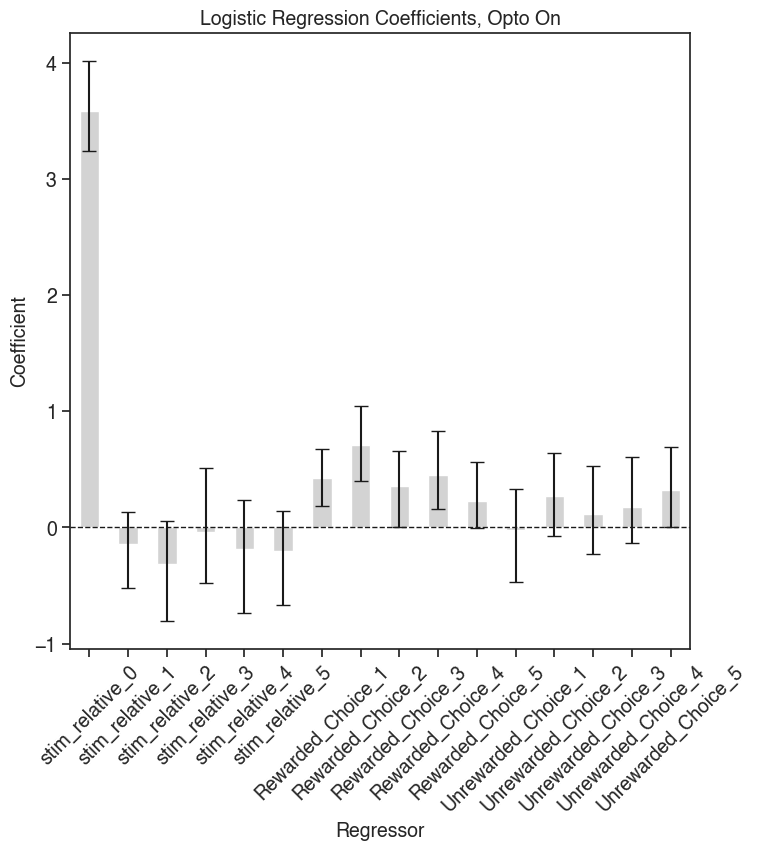

In [ ]:
# plot the coefficients Vs the regressors, with the confidence intervals
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the coefficients
coef_df_opto_on.plot(x='Regressor', y='Coefficient', kind='bar', ax=ax, color='lightgray', legend=False)

# Plot the confidence intervals
plt.errorbar(x=np.arange(len(coef_df_opto_on)), y=coef_df_opto_on['Coefficient'],
                yerr=[coef_df_opto_on['Coefficient'] - coef_df_opto_on['Conf_Int_Low'], coef_df_opto_on['Conf_Int_High'] - coef_df_opto_on['Coefficient']],
                fmt='none', ecolor='k', capsize=5)

# Add a horizontal line at y=0
ax.axhline(y=0, linestyle='--', color='k', linewidth=1)

# Set the x-axis tick labels to be the regressors
ax.set_xticklabels(coef_df_opto_on['Regressor'], rotation=45)

# Set the y-axis label
ax.set_ylabel('Coefficient')

# Set the title
ax.set_title('Logistic Regression Coefficients, Opto On')

# Show the plot
plt.show()

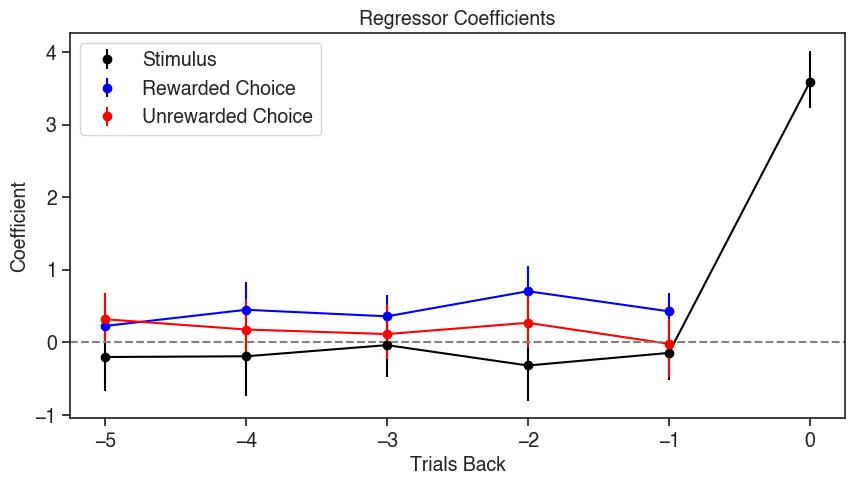

In [ ]:
# Separating the data based on categories
stim_data = coef_df_opto_on[coef_df_opto_on['Regressor'].str.contains('stim')]
rewarded_data = coef_df_opto_on[coef_df_opto_on['Regressor'].str.contains('Rewarded')]
unrewarded_data = coef_df_opto_on[coef_df_opto_on['Regressor'].str.contains('Unrewarded')]

# Mapping x-axis values
trial_numbers = np.arange(0, -6, -1)

plt.figure(figsize=(10, 5))

# Stimulus data
plt.errorbar(trial_numbers[:6], stim_data['Coefficient'], 
             yerr=[stim_data['Coefficient'] - stim_data['Conf_Int_Low'], stim_data['Conf_Int_High'] - stim_data['Coefficient']], 
             fmt='o', color='black', label='Stimulus')
plt.plot(trial_numbers[:6], stim_data['Coefficient'], color='black')

# Rewarded Choices
plt.errorbar(trial_numbers[1:], rewarded_data['Coefficient'], 
             yerr=[rewarded_data['Coefficient'] - rewarded_data['Conf_Int_Low'], rewarded_data['Conf_Int_High'] - rewarded_data['Coefficient']], 
             fmt='o', color='blue', label='Rewarded Choice')
plt.plot(trial_numbers[1:], rewarded_data['Coefficient'], color='blue')

# Unrewarded Choices
plt.errorbar(trial_numbers[1:], unrewarded_data['Coefficient'], 
             yerr=[unrewarded_data['Coefficient'] - unrewarded_data['Conf_Int_Low'], unrewarded_data['Conf_Int_High'] - unrewarded_data['Coefficient']], 
             fmt='o', color='red', label='Unrewarded Choice')
plt.plot(trial_numbers[1:], unrewarded_data['Coefficient'], color='red')

# Adding labels and title
plt.xlabel('Trials Back')
plt.ylabel('Coefficient')
plt.title('Regressor Coefficients')
plt.axhline(0, color='grey', linestyle='--')
plt.legend()
plt.show()

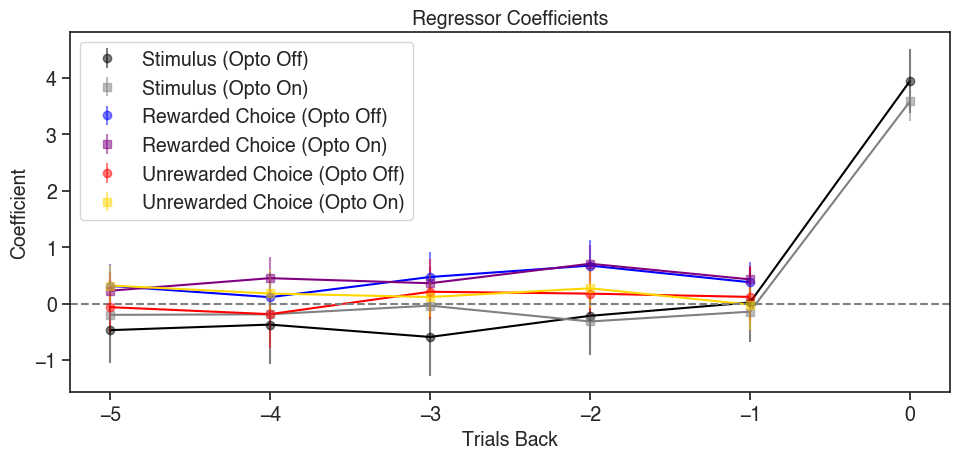

In [ ]:
# Separating the data based on categories for opto_off
stim_data_off = coef_df_opto_off[coef_df_opto_off['Regressor'].str.contains('stim')]
rewarded_data_off = coef_df_opto_off[coef_df_opto_off['Regressor'].str.contains('Rewarded')]
unrewarded_data_off = coef_df_opto_off[coef_df_opto_off['Regressor'].str.contains('Unrewarded')]

# Separating the data based on categories for opto_on
stim_data_on = coef_df_opto_on[coef_df_opto_on['Regressor'].str.contains('stim')]
rewarded_data_on = coef_df_opto_on[coef_df_opto_on['Regressor'].str.contains('Rewarded')]
unrewarded_data_on = coef_df_opto_on[coef_df_opto_on['Regressor'].str.contains('Unrewarded')]

# Mapping x-axis values
trial_numbers = np.arange(0, -6, -1)

plt.figure(figsize=(10, 5))

# Stimulus data for opto_off
plt.errorbar(trial_numbers[:6], stim_data_off['Coefficient'], 
             yerr=[stim_data_off['Coefficient'] - stim_data_off['Conf_Int_Low'], stim_data_off['Conf_Int_High'] - stim_data_off['Coefficient']], 
             fmt='o', color='black', label='Stimulus (Opto Off)', alpha=0.5)
plt.plot(trial_numbers[:6], stim_data_off['Coefficient'], color='black')

# Stimulus data for opto_on
plt.errorbar(trial_numbers[:6], stim_data_on['Coefficient'], 
             yerr=[stim_data_on['Coefficient'] - stim_data_on['Conf_Int_Low'], stim_data_on['Conf_Int_High'] - stim_data_on['Coefficient']], 
             fmt='s', color='gray', label='Stimulus (Opto On)', alpha=0.5)
plt.plot(trial_numbers[:6], stim_data_on['Coefficient'], color='gray')

# Rewarded Choices for opto_off
plt.errorbar(trial_numbers[1:], rewarded_data_off['Coefficient'], 
             yerr=[rewarded_data_off['Coefficient'] - rewarded_data_off['Conf_Int_Low'], rewarded_data_off['Conf_Int_High'] - rewarded_data_off['Coefficient']], 
             fmt='o', color='blue', label='Rewarded Choice (Opto Off)', alpha=0.5)
plt.plot(trial_numbers[1:], rewarded_data_off['Coefficient'], color='blue')

# Rewarded Choices for opto_on
plt.errorbar(trial_numbers[1:], rewarded_data_on['Coefficient'], 
             yerr=[rewarded_data_on['Coefficient'] - rewarded_data_on['Conf_Int_Low'], rewarded_data_on['Conf_Int_High'] - rewarded_data_on['Coefficient']], 
             fmt='s', color='purple', label='Rewarded Choice (Opto On)', alpha=0.5)
plt.plot(trial_numbers[1:], rewarded_data_on['Coefficient'], color='purple')

# Unrewarded Choices for opto_off
plt.errorbar(trial_numbers[1:], unrewarded_data_off['Coefficient'], 
             yerr=[unrewarded_data_off['Coefficient'] - unrewarded_data_off['Conf_Int_Low'], unrewarded_data_off['Conf_Int_High'] - unrewarded_data_off['Coefficient']], 
             fmt='o', color='red', label='Unrewarded Choice (Opto Off)', alpha=0.5)
plt.plot(trial_numbers[1:], unrewarded_data_off['Coefficient'], color='red')

# Unrewarded Choices for opto_on
plt.errorbar(trial_numbers[1:], unrewarded_data_on['Coefficient'], 
             yerr=[unrewarded_data_on['Coefficient'] - unrewarded_data_on['Conf_Int_Low'], unrewarded_data_on['Conf_Int_High'] - unrewarded_data_on['Coefficient']], 
             fmt='s', color='gold', label='Unrewarded Choice (Opto On)', alpha=0.5)
plt.plot(trial_numbers[1:], unrewarded_data_on['Coefficient'], color='gold')

# Adding labels and title
plt.xlabel('Trials Back')
plt.ylabel('Coefficient')
plt.title('Regressor Coefficients')
plt.axhline(0, color='grey', linestyle='--')
plt.legend()
plt.tight_layout()
# save as pdf in the figures folder
plt.savefig(figs_path + 'QP094_PPC_Opto_Coefficients.pdf', dpi=300, bbox_inches='tight')
plt.show()


## Track Distributions

In [ ]:
# only keep date where Distribution is in ['Uniform', 'Asym_Left', 'Asym_Right', np.nan]
df = df[df['Distribution'].isin(['Uniform', 'Asym_Left', 'Asym_Right', np.nan])]
df['Distribution'] = df['Distribution'].astype('category')

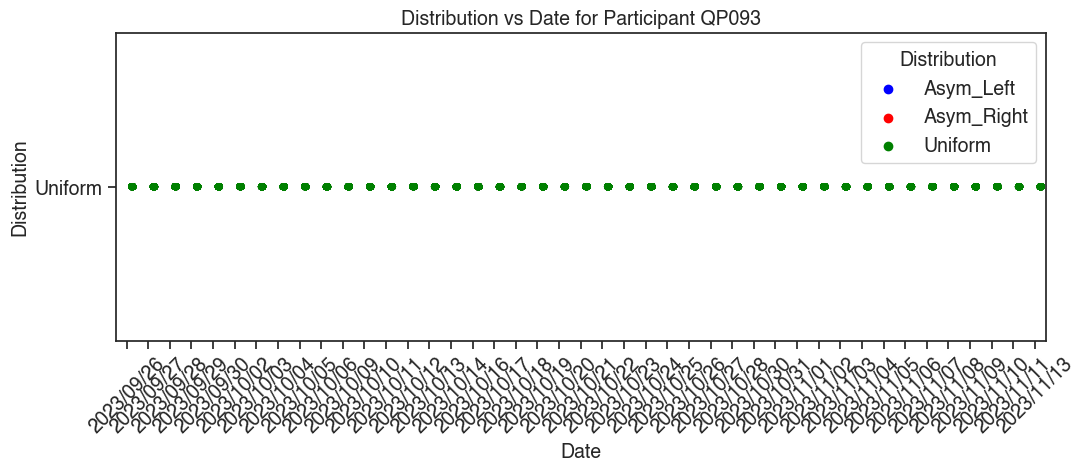

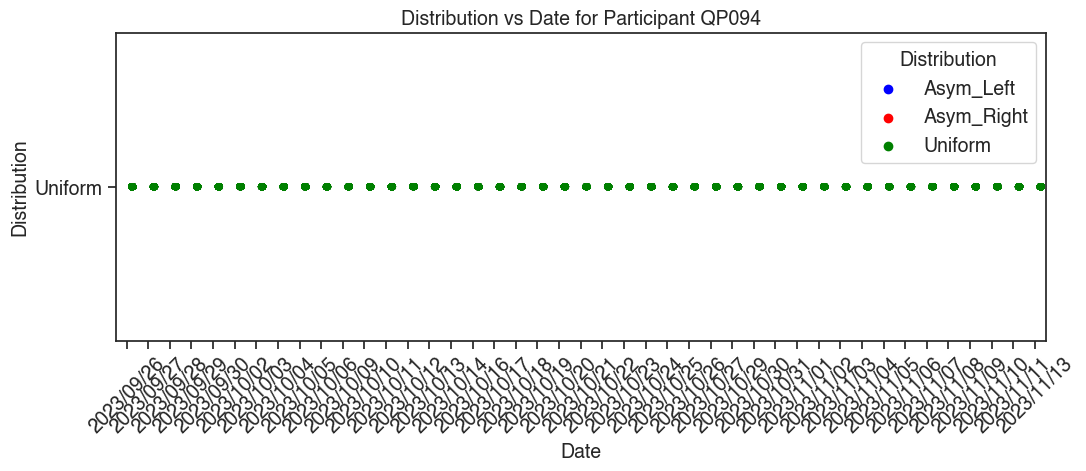

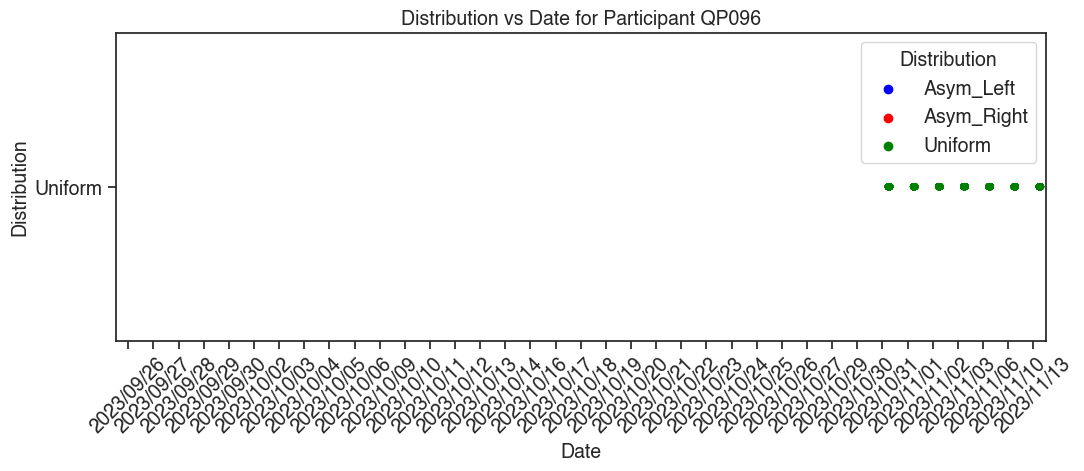

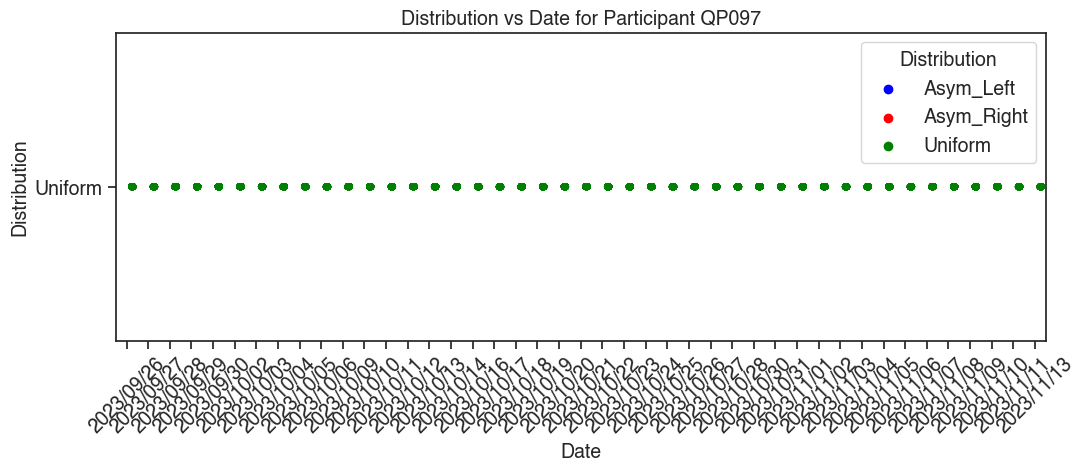

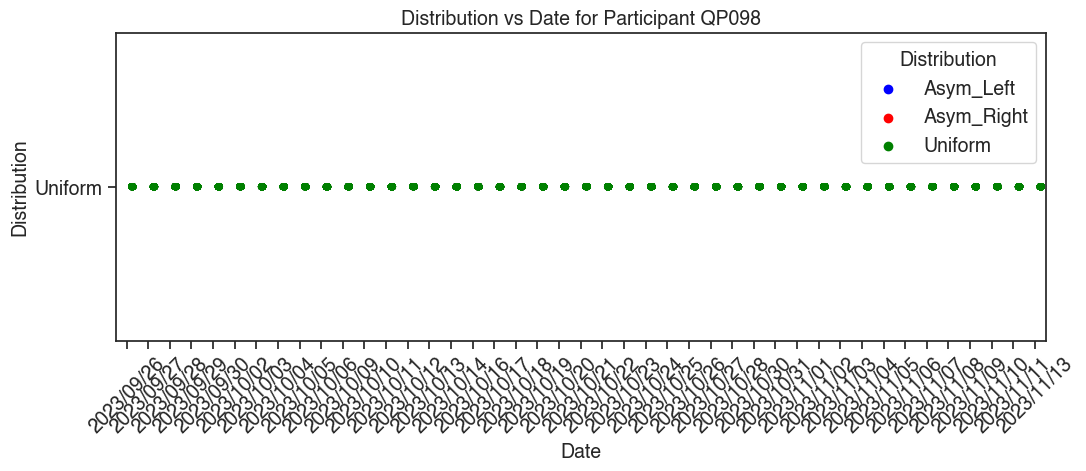

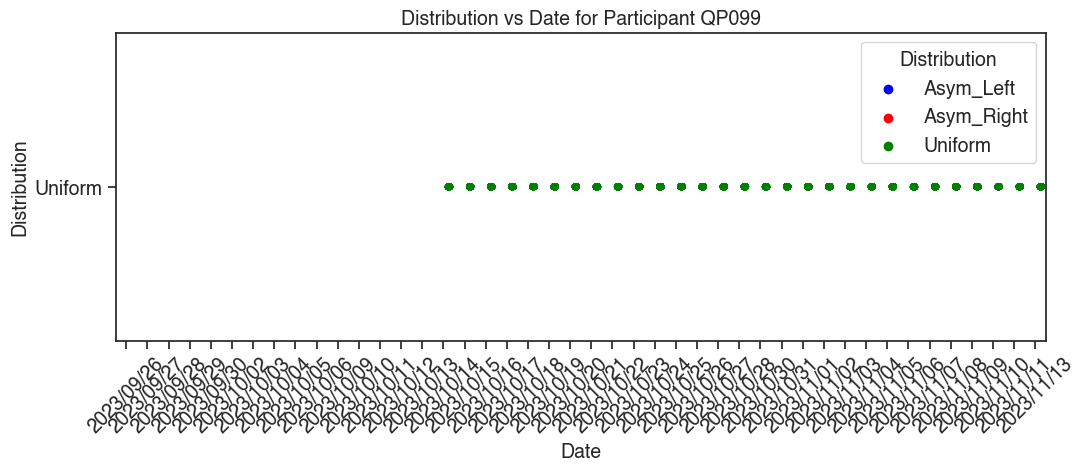

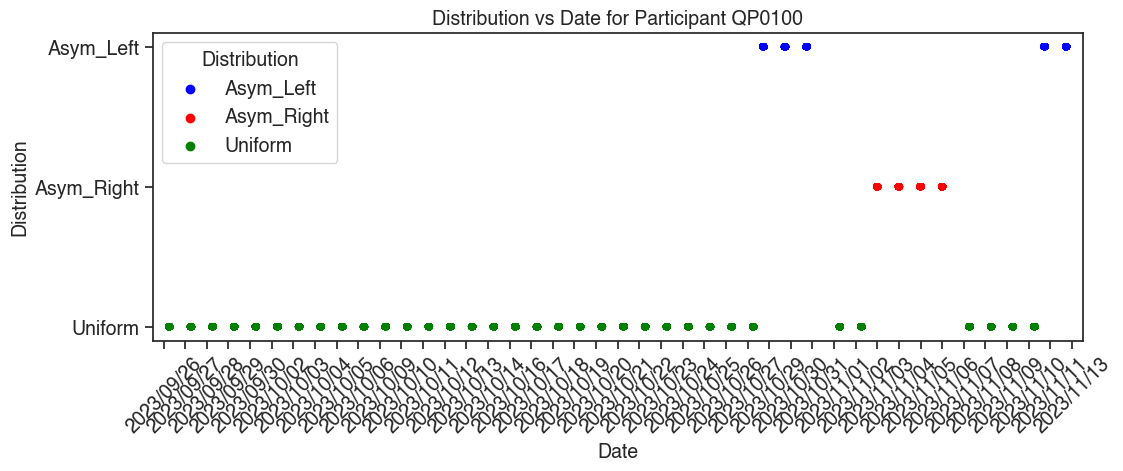

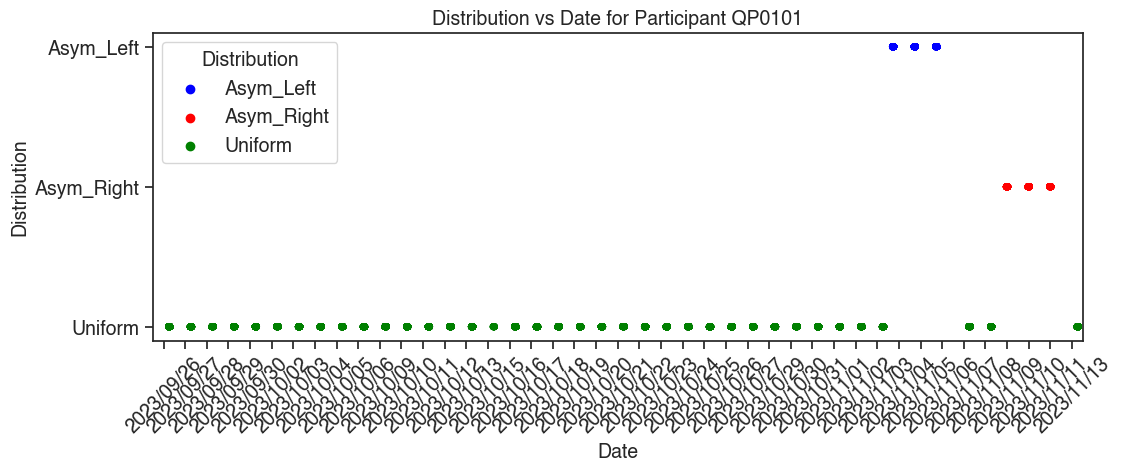

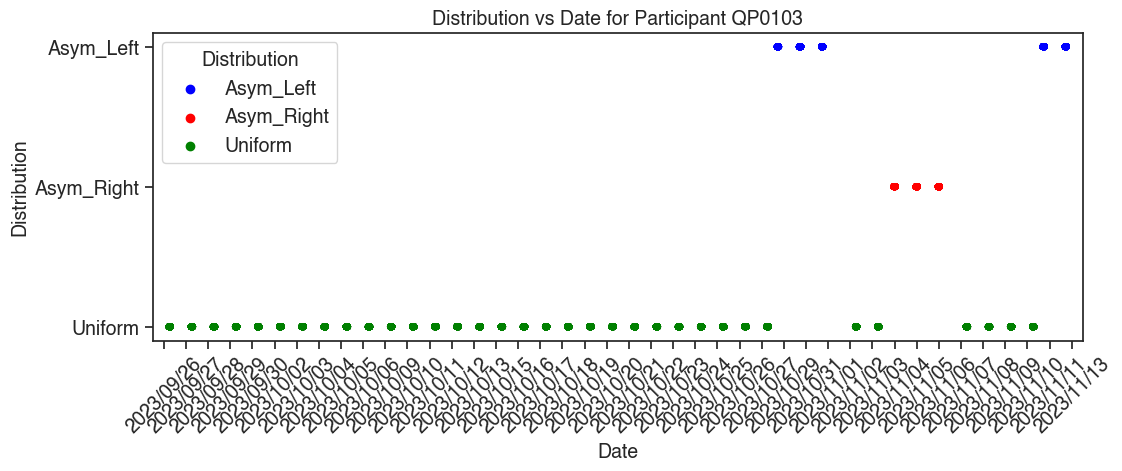

In [ ]:
# Convert 'Distribution' to categorical type if it's not already
df['Distribution'] = df['Distribution'].astype('category')

# Get unique Participant IDs
participant_ids = df['Participant_ID'].unique()
color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}

# Create a separate plot for each Participant_ID
for pid in participant_ids:
    plt.figure(figsize=(12, 4))
    
    # Filter the DataFrame for the current Participant_ID
    participant_df = df[df['Participant_ID'] == pid]
    
    try:
        # Create the plot
        sns.stripplot(data=participant_df, x='Date', y='Distribution', hue='Distribution', jitter=True, dodge=True, marker='o', alpha=0.7, palette=color_dict)
        
        # Customize the plot
        plt.title(f'Distribution vs Date for Participant {pid}')
        plt.xlabel('Date')
        plt.ylabel('Distribution')
        plt.xticks(rotation=45)
        plt.legend(title='Distribution')
        
        # Show the plot
        plt.show()
        
    except Exception as e:
        print(f"An error occurred for Participant_ID {pid}: {str(e)}")
        continue


In [ ]:
date_df = df[df['Date'] == '2023/11/02']

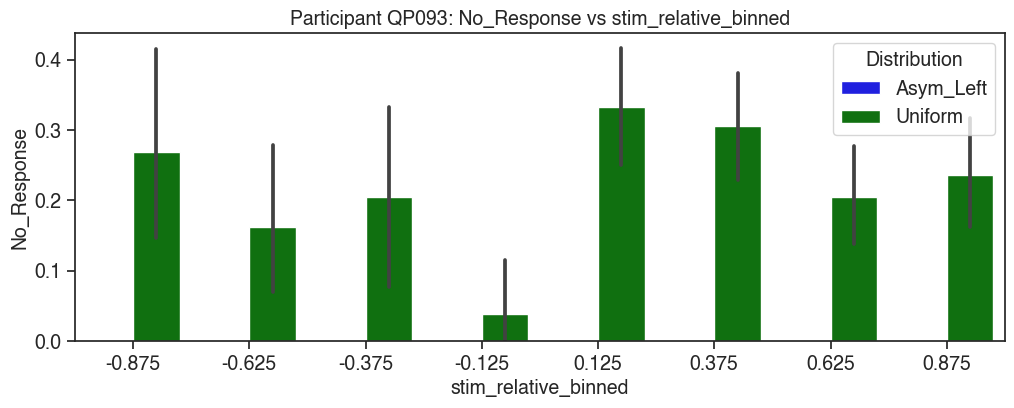

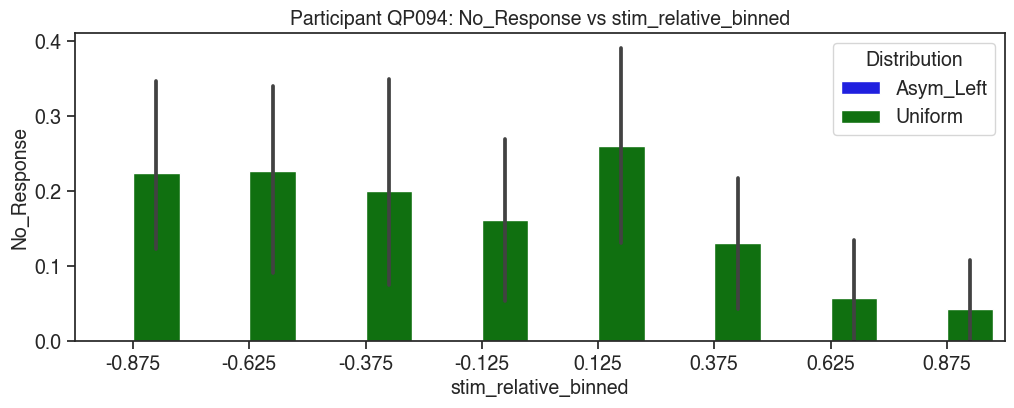

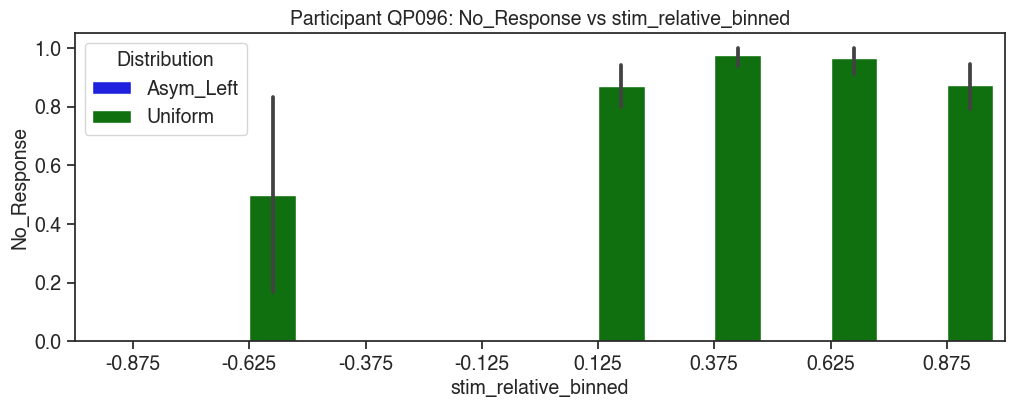

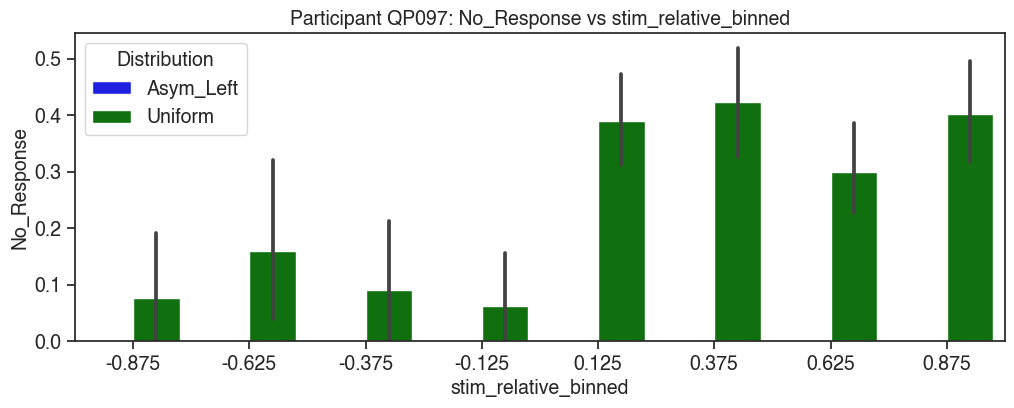

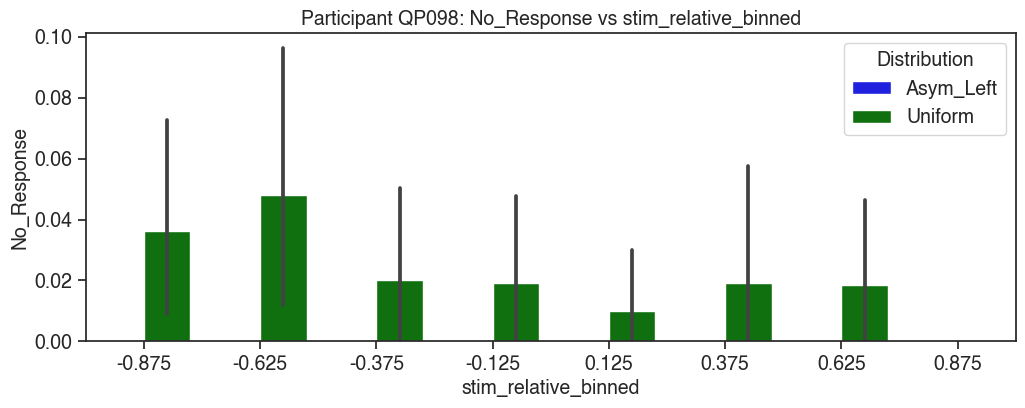

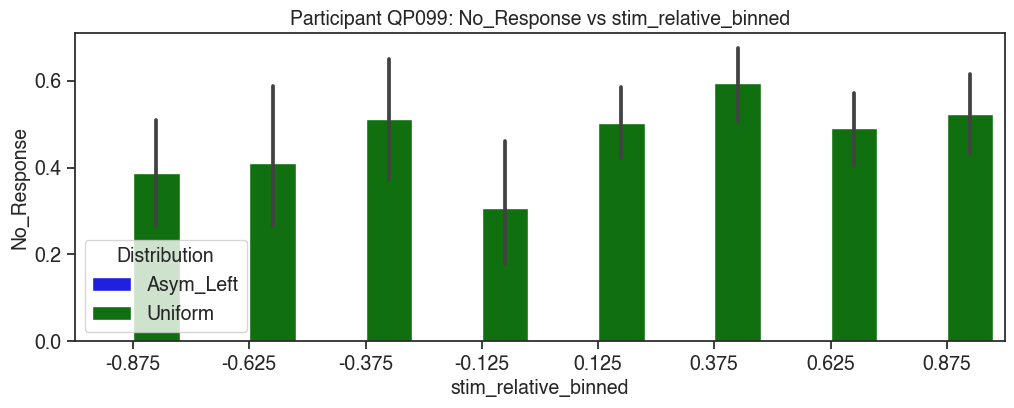

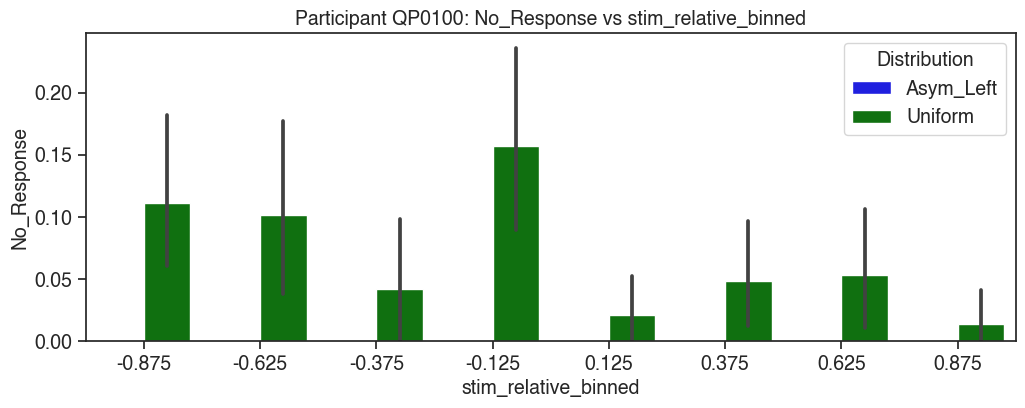

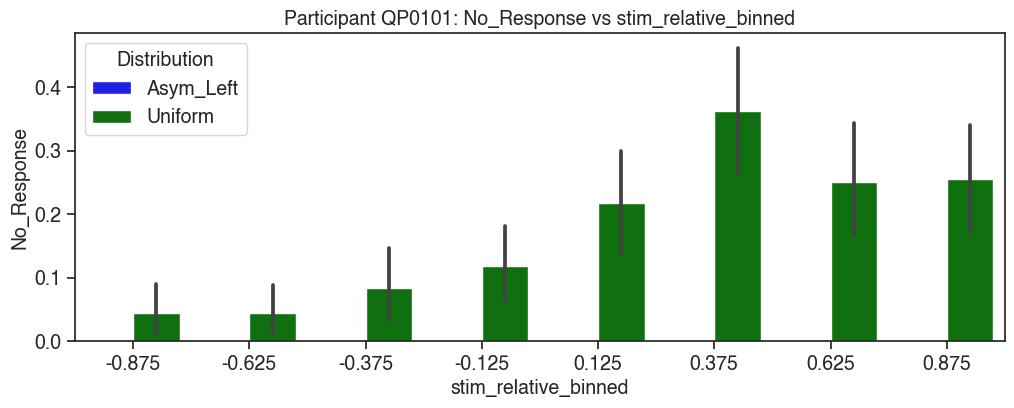

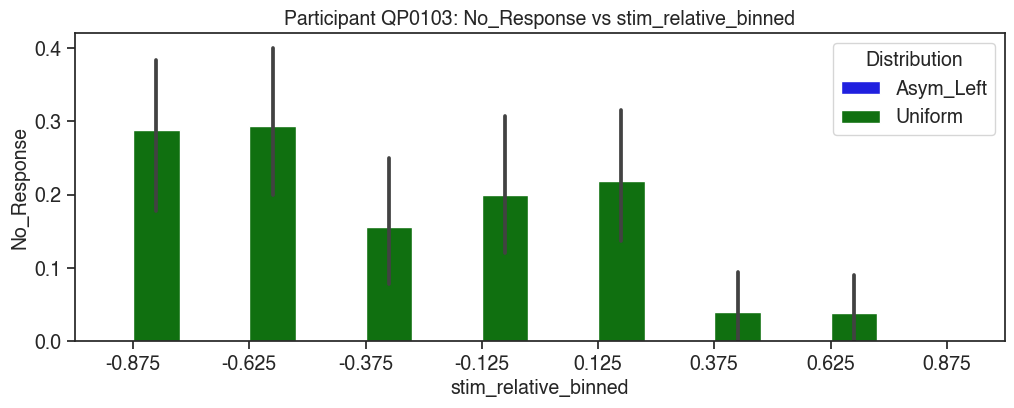

In [ ]:
# for every participant, show me the number of No_Response trials as a function of stim_relative_binned
# I want 4 columns (max 4 articipants per row) and as many rows as needed
# do this with a barplot
for p_id in date_df['Participant_ID'].unique():
    plt.figure(figsize=(12, 4))
    sns.barplot(data=date_df[date_df['Participant_ID'] == p_id], x='stim_relative_binned', y='No_Response', hue='Distribution', palette=color_dict)
    plt.title(f'Participant {p_id}: No_Response vs stim_relative_binned')
    plt.xlabel('stim_relative_binned')
    plt.ylabel('No_Response')
    plt.show()